## I. Camera Calibration
### I.1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, cv2
import collections
%matplotlib inline

In [2]:
def calibration_lazy(func):
    """
    Decorator for calibration function to avoid re-computing calibration every time.
    """    

    def wrapper(*args, **kwargs):
        calibration_cache = 'camera_cal/calibration.pickle'
        if os.path.exists(calibration_cache):
            print('Loading cached camera calibration...', end=' ')
            with open(calibration_cache, 'rb') as dump_file:
                calibration = pickle.load(dump_file)
        else:
            print('Computing camera calibration...', end=' ')
            calibration = func(*args, **kwargs)
            with open(calibration_cache, 'wb') as dump_file:
                pickle.dump(calibration, dump_file)
        print('Done.')
        return calibration

    return wrapper

In [3]:
@calibration_lazy
def camera_calibration(calib_dir, plot=False):
    """
    Calibrate the camera given a directory containing calibration chessboards.

    :param calib_dir: directory containing chessboard frames
    :param plot: if True, draw and show chessboard corners
    :return: calibration parameters
    """

    assert os.path.exists(calib_dir), '"{}" must exist and contain calibration images.'.format(calib_dir)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # 9x6 chessboard images
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d points in real world space
    imgpoints = []  # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for filename in os.listdir(calib_dir):
        if filename.endswith(".jpg"):
            img = cv2.imread(calib_dir + "/" + filename)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            pattern_found, corners = cv2.findChessboardCorners(gray, (9, 6), None)

            if pattern_found is True:
                objpoints.append(objp)
                imgpoints.append(corners)

                if plot:
                    # Draw and display the corners
                    img = cv2.drawChessboardCorners(img, (9, 6), corners, pattern_found)
                    plt.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs


def undistort_image(frame, mtx, dist, plot=False):
    """
    Undistort a frame given camera matrix and distortion coefficients.
    :param frame: input frame
    :param mtx: camera matrix
    :param dist: distortion coefficients
    :param plot: if True, show frame before/after distortion correction
    :return: undistorted frame
    """
    frame_undistorted = cv2.undistort(frame, mtx, dist, newCameraMatrix=mtx)

    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,9))
        ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(frame_undistorted, cv2.COLOR_BGR2RGB))
        plt.show()

    return frame_undistorted


Loading cached camera calibration... Done.


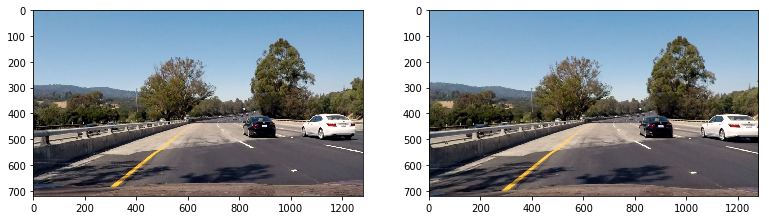

True

In [4]:
ret, mtx, dist, rvecs, tvecs = camera_calibration(calib_dir='camera_cal', plot=True)

img = cv2.imread('test_images/test4.jpg')

img_undistorted = undistort_image(img, mtx, dist, True)

cv2.imwrite('output_images/before_distortion_correction.jpg', img)
cv2.imwrite('output_images/after_distortion_correction.jpg', img_undistorted)

img2 = cv2.imread('camera_cal/calibration4.jpg')

img_undistorted2 = undistort_image(img2, mtx, dist)

cv2.imwrite('output_images/before_distortion_correction_chess.jpg', img2)
cv2.imwrite('output_images/after_distortion_correction_chess.jpg', img_undistorted2)

## II. Pipeline (single images)
### II.1. Provide an example of a distortion-corrected image.

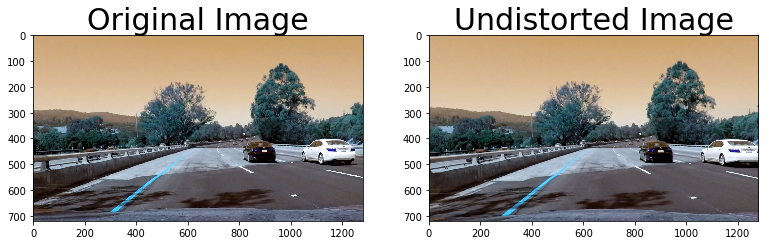

In [5]:
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

### II.2. Use color transforms, gradients, etc., to create a thresholded binary image

In [6]:

# selected threshold to highlight yellow lines
yellow_HSV_th_min = np.array([0, 70, 70])
yellow_HSV_th_max = np.array([50, 255, 255])


def thresh_in_HSV(frame, min_values, max_values, plot=False):
    """
    Threshold a color frame in HSV space
    """
    HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    min_th_ok = np.all(HSV > min_values, axis=2)
    max_th_ok = np.all(HSV < max_values, axis=2)

    out = np.logical_and(min_th_ok, max_th_ok)

    if plot:
        plt.imshow(out, cmap='gray')
        plt.show()

    return out


def thresh_sobel(frame, kernel_size):
    """
    Apply Sobel edge detection to an input frame, then threshold the result
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)

    sobel_mag = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_mag = np.uint8(sobel_mag / np.max(sobel_mag) * 255)

    _, sobel_mag = cv2.threshold(sobel_mag, 50, 1, cv2.THRESH_BINARY)

    return sobel_mag.astype(bool)


def get_binary_from_equalized_grayscale(frame):
    """
    Apply histogram equalization to an input frame, threshold it and return the (binary) result.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    eq_global = cv2.equalizeHist(gray)

    _, th = cv2.threshold(eq_global, thresh=250, maxval=255, type=cv2.THRESH_BINARY)

    return th


def binarize(image, plot=False):
    """
    Convert an input frame to a binary image which highlight as most as possible the lane-lines.

    :param image: input color frame
    :param plot: if True, show intermediate results
    :return: binarized frame
    """
    h, w = image.shape[:2]

    binary = np.zeros(shape=(h, w), dtype=np.uint8)

    # highlight yellow lines by threshold in HSV color space
    HSV_yellow_mask = thresh_in_HSV(image, yellow_HSV_th_min, yellow_HSV_th_max, plot=False)
    binary = np.logical_or(binary, HSV_yellow_mask)

    # highlight white lines by thresholding the equalized frame
    eq_white_mask = get_binary_from_equalized_grayscale(image)
    binary = np.logical_or(binary, eq_white_mask)

    # get Sobel binary mask (thresholded gradients)
    sobel_mask = thresh_sobel(image, kernel_size=9)
    binary = np.logical_or(binary, sobel_mask)

    # apply a light morphology to "fill the gaps" in the binary image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    if plot:
        f, ax = plt.subplots(2, 3 , figsize=(13,9))
        f.set_facecolor('white')
        ax[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0, 0].set_title('input_frame')
        ax[0, 0].set_axis_off()
        ax[0, 0].set_facecolor('red')
        ax[0, 1].imshow(eq_white_mask, cmap='gray')
        ax[0, 1].set_title('white mask')
        ax[0, 1].set_axis_off()

        ax[0, 2].imshow(HSV_yellow_mask, cmap='gray')
        ax[0, 2].set_title('yellow mask')
        ax[0, 2].set_axis_off()

        ax[1, 0].imshow(sobel_mask, cmap='gray')
        ax[1, 0].set_title('sobel mask')
        ax[1, 0].set_axis_off()

        ax[1, 1].imshow(binary, cmap='gray')
        ax[1, 1].set_title('before closure')
        ax[1, 1].set_axis_off()

        ax[1, 2].imshow(closing, cmap='gray')
        ax[1, 2].set_title('after closure')
        ax[1, 2].set_axis_off()
        plt.show()

    return closing


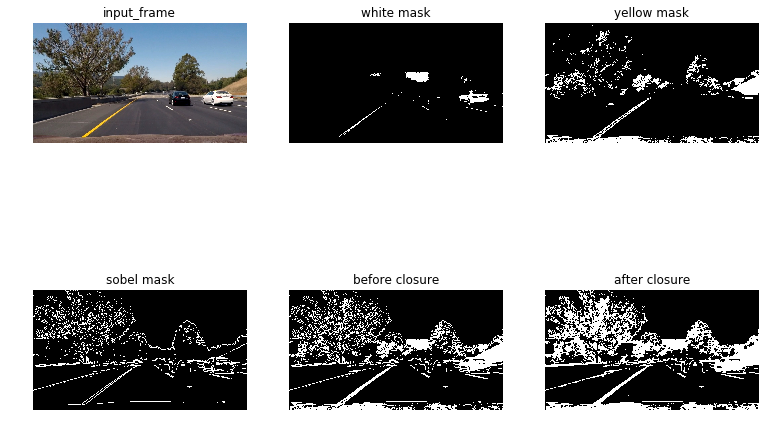

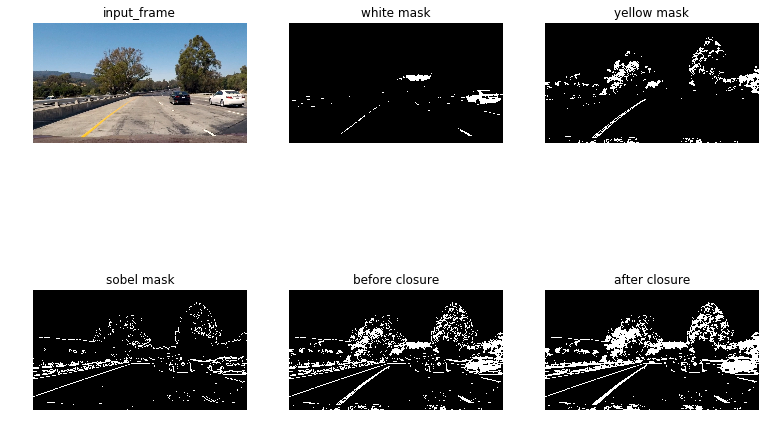

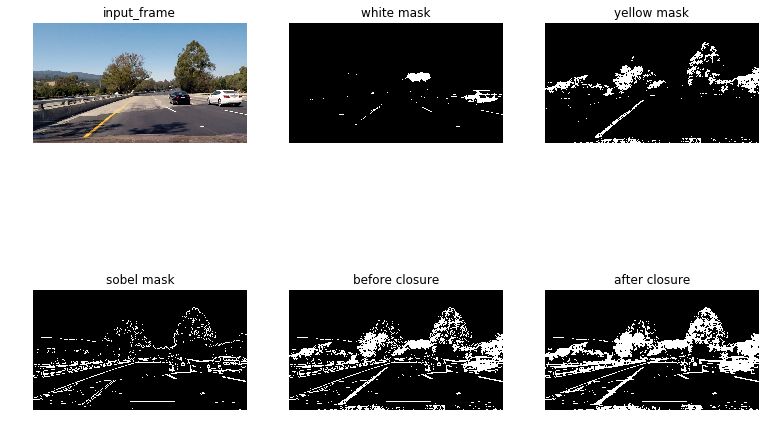

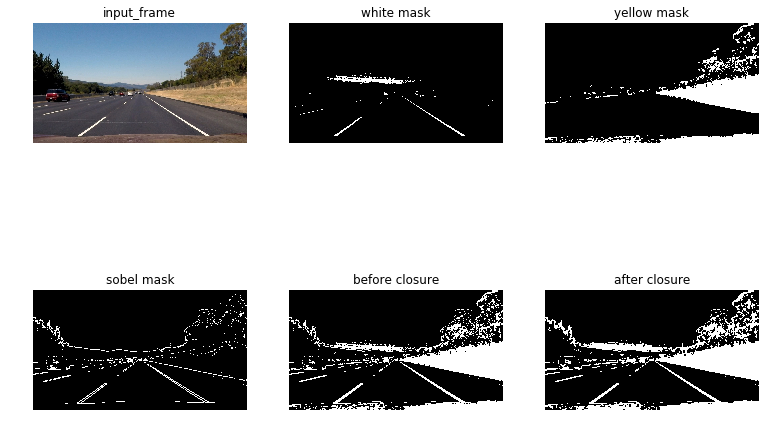

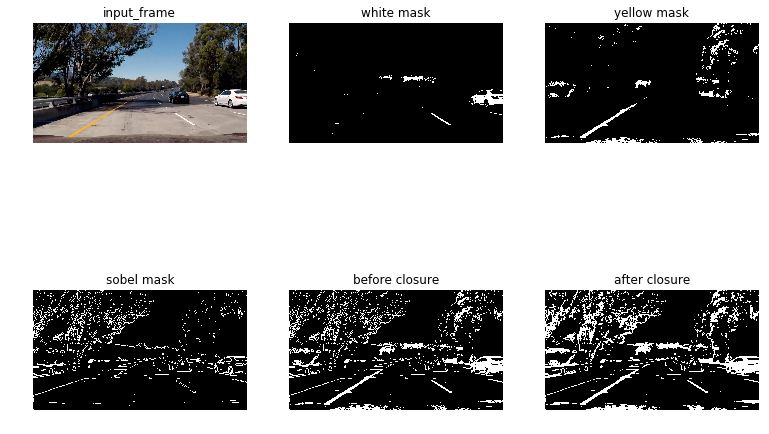

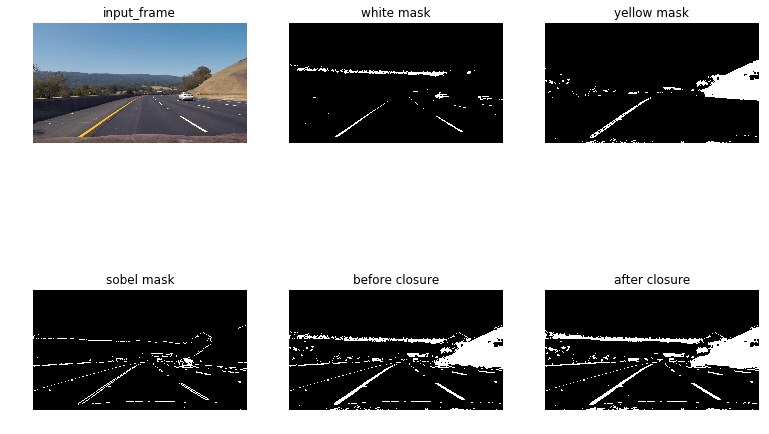

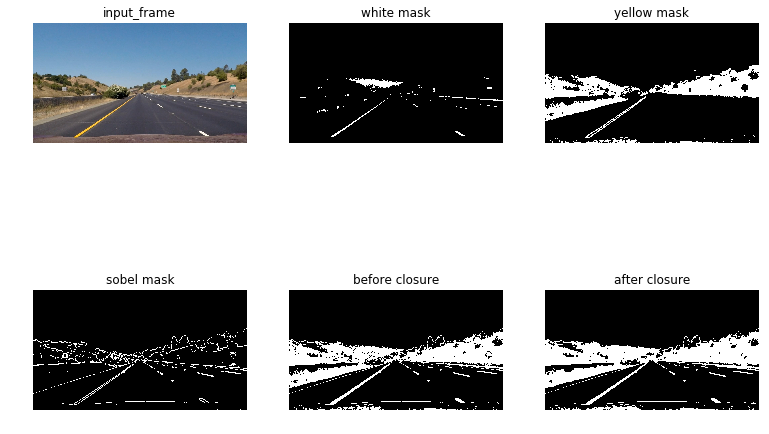

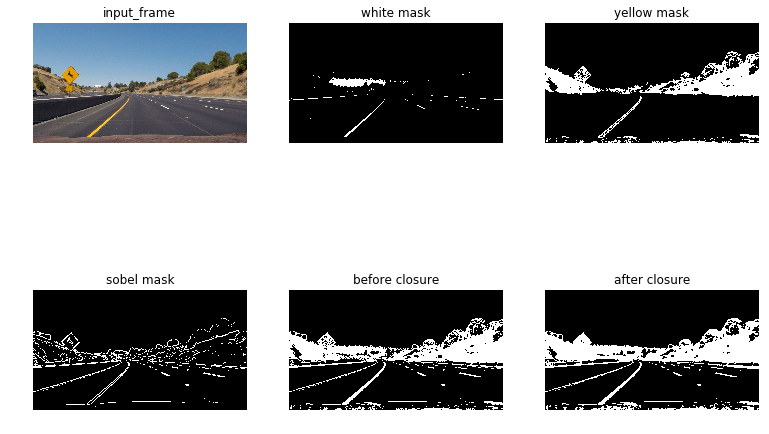

In [7]:
for filename in os.listdir("test_images"):
    if filename.endswith(".jpg"):
        image = cv2.imread("test_images" + "/" + filename)
        binarize(image=image, plot=True)

### II.3. Apply a perspective transform to rectify binary image ("birds-eye view").

In [8]:
def birdeye(img, plot=False):
    """
    Apply perspective transform to input frame to get the bird's eye view.
    :param img: input color frame
    :param plot: if True, show the transformation result
    :return: warped image, and both forward and backward transformation matrices
    """
    h, w = img.shape[:2]

    src = np.float32([[w, h-10],    # bottom right
                      [0, h-10],    # bottom left
                      [546, 460],   # top left
                      [732, 460]])  # top right
    dst = np.float32([[w, h],       # bottom right
                      [0, h],       # bottom left
                      [0, 0],       # top left
                      [w, 0]])      # top right

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)

    if plot:
        f, axarray = plt.subplots(1, 2, figsize=(13,9))
        f.set_facecolor('white')
        axarray[0].set_title('Before perspective transform')
        axarray[0].imshow(img, cmap='gray')
        for point in src:
            axarray[0].plot(*point, '.')
        axarray[1].set_title('After perspective transform')
        axarray[1].imshow(warped, cmap='gray')
        for point in dst:
            axarray[1].plot(*point, '.')
        for axis in axarray:
            axis.set_axis_off()
        plt.show()

    return warped, M, Minv


Loading cached camera calibration... Done.


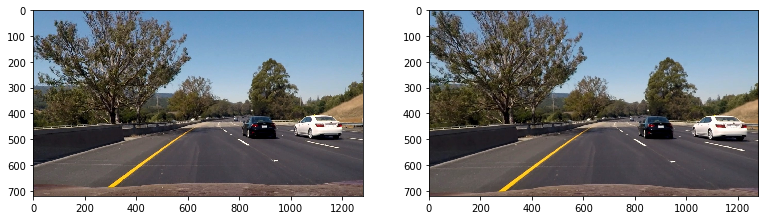

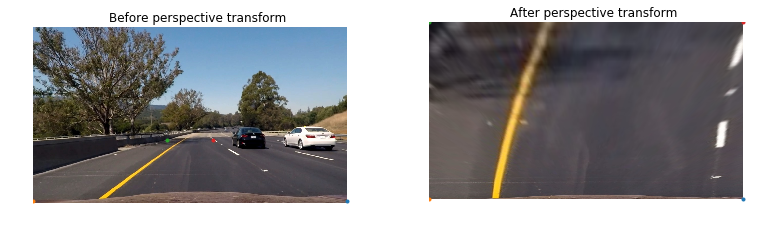

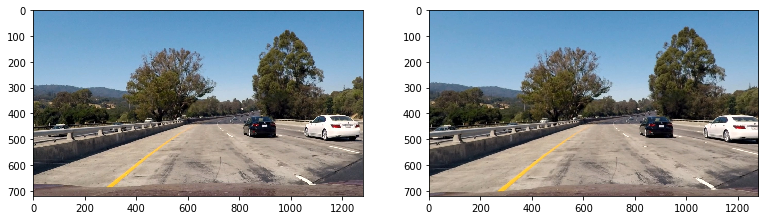

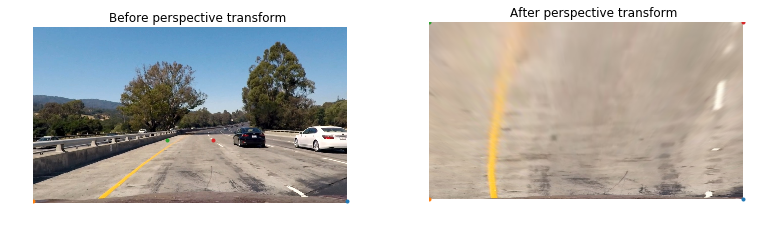

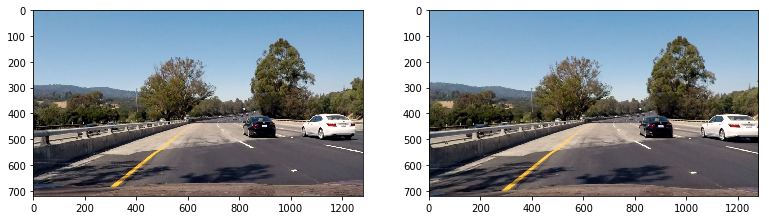

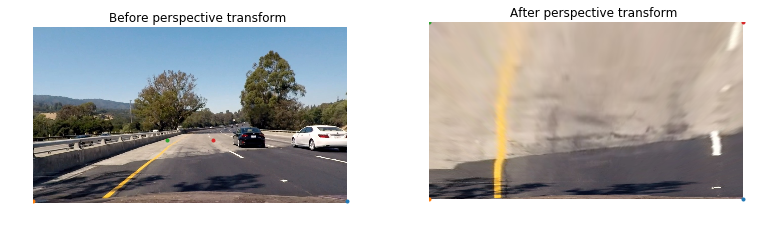

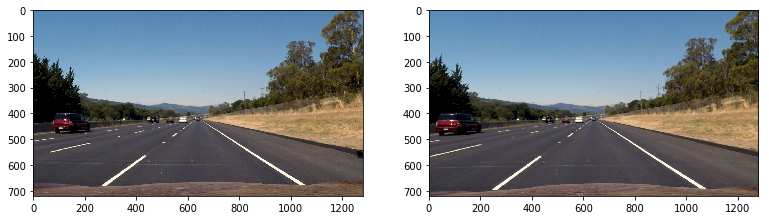

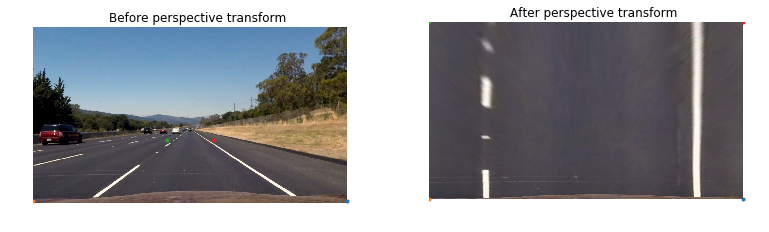

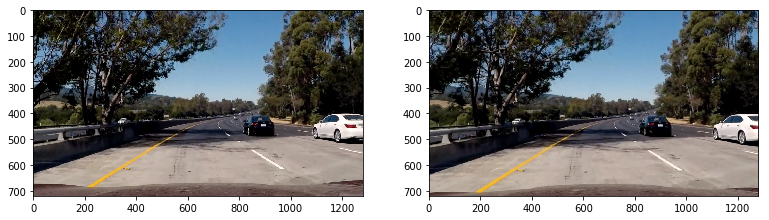

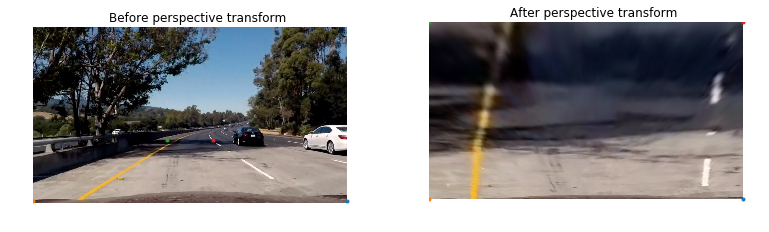

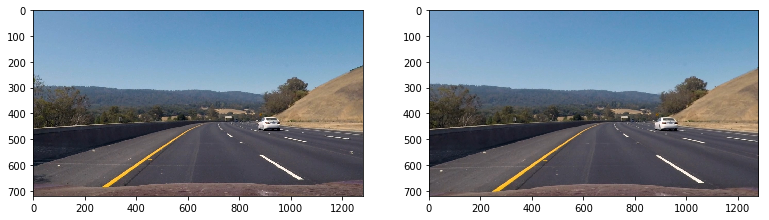

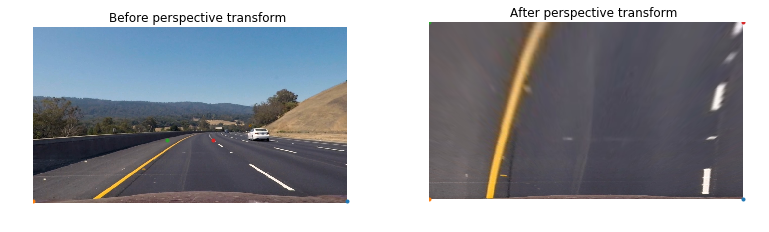

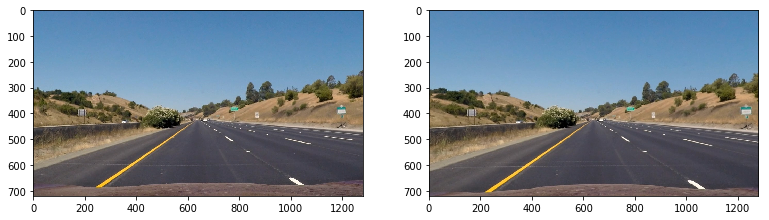

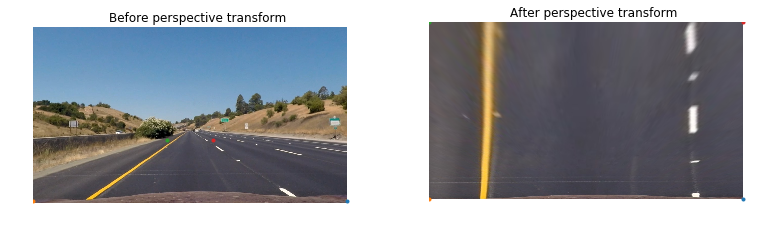

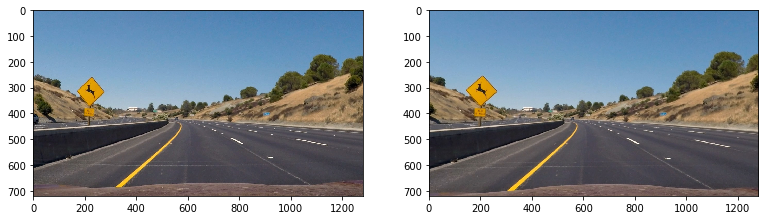

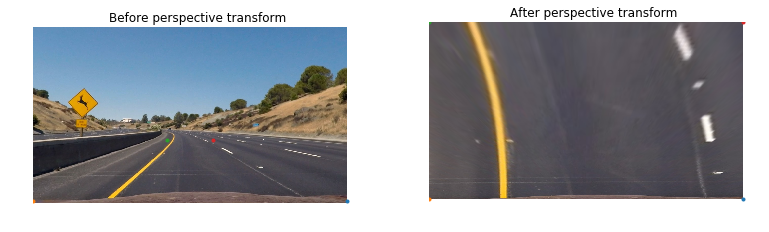

In [9]:
ret, mtx, dist, rvecs, tvecs = camera_calibration(calib_dir='camera_cal')
# show result on test images
for filename in os.listdir("test_images"):
    if filename.endswith(".jpg"):
        img = cv2.imread("test_images" + "/" + filename)

        img_undistorted = undistort_image(img, mtx, dist, plot=True)

        img_binary = binarize(img_undistorted, plot=False)

        img_birdeye, M, Minv = birdeye(cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2RGB), plot=True)
        #img_birdeye, M, Minv = birdeye(img_binary, plot=True)
        


### II.4. Detect lane pixels and fit to find lane boundary.

### II.5.  Determine the curvature of the lane and vehicle position with respect to center.

### II.6.  Warp the detected lane boundaries back onto the original image.

In [10]:
ym_per_pix = 30 / 720   # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

time_window = 10        # results are averaged over this number of frames

class Line:
    """
    Class to model a lane-line. It will make it easy to have individual methods to draw a line or find curvature.
    """
    def __init__(self, buffer_len=10):

        # flag to mark if the line was detected the last iteration
        self.detected = False

        # polynomial coefficients fitted on the last iteration
        self.last_fit_pixel = None
        self.last_fit_meter = None

        # list of polynomial coefficients of the last N iterations
        self.recent_fits_pixel = collections.deque(maxlen=buffer_len)
        self.recent_fits_meter = collections.deque(maxlen=2 * buffer_len)

        self.radius_of_curvature = None

        # store all pixels coords (x, y) of line detected
        self.all_x = None
        self.all_y = None

    def update_line(self, new_fit_pixel, new_fit_meter, detected, clear_buffer=False):
        """
        Update Line with new fitted coefficients.

        :param new_fit_pixel: new polynomial coefficients (pixel)
        :param new_fit_meter: new polynomial coefficients (meter)
        :param detected: if the Line was detected or inferred
        :param clear_buffer: if True, reset state
        :return: None
        """
        self.detected = detected

        if clear_buffer:
            self.recent_fits_pixel = []
            self.recent_fits_meter = []

        self.last_fit_pixel = new_fit_pixel
        self.last_fit_meter = new_fit_meter

        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)

    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        h, w, c = mask.shape

        plot_y = np.linspace(0, h - 1, h)
        coeffs = self.average_fit if average else self.last_fit_pixel

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

    @property
    # average of polynomial coefficients of the last N iterations
    def average_fit(self):
        return np.mean(self.recent_fits_pixel, axis=0)

    @property
    # radius of curvature of the line (averaged)
    def curvature(self):
        y_eval = 0
        coeffs = self.average_fit
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])

    @property
    # radius of curvature of the line (averaged)
    def curvature_meter(self):
        y_eval = 0
        coeffs = np.mean(self.recent_fits_meter, axis=0)
        return ((1 + (2 * coeffs[0] * y_eval + coeffs[1]) ** 2) ** 1.5) / np.absolute(2 * coeffs[0])


def get_fits_by_sliding_windows(birdeye_binary_image, line_lt, line_rt, n_windows=9, plot=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.

    :param birdeye_binary_image: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param n_windows: number of sliding windows used to search for the lines
    :param plot: if True, display intermediate output
    :return: updated lane lines and output image
    """
    height, width = birdeye_binary_image.shape

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(birdeye_binary_image[height//2:-30, :], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((birdeye_binary_image, birdeye_binary_image, birdeye_binary_image)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    

    midpoint = len(histogram) // 2
    leftx_base = np.argmax(histogram[:midpoint]) 
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(height / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = birdeye_binary_image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 100  # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = height - (window + 1) * window_height
        win_y_high = height - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low)
                          & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low)
                           & (nonzero_x < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    out_img[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    if plot:
        f, ax = plt.subplots(1, 2,figsize=(13,10))
        f.set_facecolor('white')
        ax[0].imshow(birdeye_binary_image, cmap='gray')
        ax[1].imshow(out_img)
        ax[1].plot(left_fitx, ploty, color='yellow')
        ax[1].plot(right_fitx, ploty, color='yellow')
        ax[1].set_xlim(0, 1280)
        ax[1].set_ylim(720, 0)

        plt.show()

    return line_lt, line_rt, out_img


def get_fits_by_previous_fits(birdeye_binary_image, line_lt, line_rt, plot=False):
    """
    Get polynomial coefficients for lane-lines detected in an binary image.
    This function starts from previously detected lane-lines to speed-up the search of lane-lines in the current frame.

    :param birdeye_binary_image: input bird's eye view binary image
    :param line_lt: left lane-line previously detected
    :param line_rt: left lane-line previously detected
    :param plot: if True, display intermediate output
    :return: updated lane lines and output image
    """

    height, width = birdeye_binary_image.shape

    left_fit_pixel = line_lt.last_fit_pixel
    right_fit_pixel = line_rt.last_fit_pixel

    nonzero = birdeye_binary_image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    margin = 100
    left_lane_inds = (
    (nonzero_x > (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] - margin)) & (
    nonzero_x < (left_fit_pixel[0] * (nonzero_y ** 2) + left_fit_pixel[1] * nonzero_y + left_fit_pixel[2] + margin)))
    right_lane_inds = (
    (nonzero_x > (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] - margin)) & (
    nonzero_x < (right_fit_pixel[0] * (nonzero_y ** 2) + right_fit_pixel[1] * nonzero_y + right_fit_pixel[2] + margin)))

    # Extract left and right line pixel positions
    line_lt.all_x, line_lt.all_y = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
    line_rt.all_x, line_rt.all_y = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

    detected = True
    if not list(line_lt.all_x) or not list(line_lt.all_y):
        left_fit_pixel = line_lt.last_fit_pixel
        left_fit_meter = line_lt.last_fit_meter
        detected = False
    else:
        left_fit_pixel = np.polyfit(line_lt.all_y, line_lt.all_x, 2)
        left_fit_meter = np.polyfit(line_lt.all_y * ym_per_pix, line_lt.all_x * xm_per_pix, 2)

    if not list(line_rt.all_x) or not list(line_rt.all_y):
        right_fit_pixel = line_rt.last_fit_pixel
        right_fit_meter = line_rt.last_fit_meter
        detected = False
    else:
        right_fit_pixel = np.polyfit(line_rt.all_y, line_rt.all_x, 2)
        right_fit_meter = np.polyfit(line_rt.all_y * ym_per_pix, line_rt.all_x * xm_per_pix, 2)

    line_lt.update_line(left_fit_pixel, left_fit_meter, detected=detected)
    line_rt.update_line(right_fit_pixel, right_fit_meter, detected=detected)

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit_pixel[0] * ploty ** 2 + left_fit_pixel[1] * ploty + left_fit_pixel[2]
    right_fitx = right_fit_pixel[0] * ploty ** 2 + right_fit_pixel[1] * ploty + right_fit_pixel[2]

    # Create an image to draw on and an image to show the selection window
    img_fit = np.dstack((birdeye_binary_image, birdeye_binary_image, birdeye_binary_image)) * 255
    window_img = np.zeros_like(img_fit)

    # Color in left and right line pixels
    img_fit[nonzero_y[left_lane_inds], nonzero_x[left_lane_inds]] = [255, 0, 0]
    img_fit[nonzero_y[right_lane_inds], nonzero_x[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(img_fit, 1, window_img, 0.3, 0)

    if plot:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

        plt.show()

    return line_lt, line_rt, img_fit




def compute_offset_from_center(line_lt, line_rt, frame_width):
    """
    Compute offset from center of the inferred lane.
    The offset from the lane center can be computed under the hypothesis that the camera is fixed
    and mounted in the midpoint of the car roof. In this case, we can approximate the car's deviation
    from the lane center as the distance between the center of the image and the midpoint at the bottom
    of the image of the two lane-lines detected.

    :param line_lt: detected left lane-line
    :param line_rt: detected right lane-line
    :param frame_width: width of the undistorted frame
    :return: inferred offset
    """
    if line_lt.detected and line_rt.detected:
        line_lt_bottom = np.mean(line_lt.all_x[line_lt.all_y > 0.95 * line_lt.all_y.max()])
        line_rt_bottom = np.mean(line_rt.all_x[line_rt.all_y > 0.95 * line_rt.all_y.max()])
        lane_width = line_rt_bottom - line_lt_bottom
        midpoint = frame_width / 2
        offset_pix = abs((line_lt_bottom + lane_width / 2) - midpoint)
        offset_meter = xm_per_pix * offset_pix
    else:
        offset_meter = -1

    return offset_meter




def draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state):
    """
    Draw both the drivable lane area and the detected lane-lines onto the original (undistorted) frame.
    :param img_undistorted: original undistorted color frame
    :param Minv: (inverse) perspective transform matrix used to re-project on original frame
    :param line_lt: left lane-line previously detected
    :param line_rt: right lane-line previously detected
    :param keep_state: if True, line state is maintained
    :return: color blend
    """
    height, width, _ = img_undistorted.shape

    left_fit = line_lt.average_fit if keep_state else line_lt.last_fit_pixel
    right_fit = line_rt.average_fit if keep_state else line_rt.last_fit_pixel

    # Generate x and y values for plotting
    ploty = np.linspace(0, height - 1, height)
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # draw road as green polygon on original frame
    road_warp = np.zeros_like(img_undistorted, dtype=np.uint8)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(road_warp, np.int_([pts]), (0, 255, 0))
    road_dewarped = cv2.warpPerspective(road_warp, Minv, (width, height))  # Warp back to original image space

    blend_onto_road = cv2.addWeighted(img_undistorted, 1., road_dewarped, 0.3, 0)

    # now separately draw solid lines to highlight them
    line_warp = np.zeros_like(img_undistorted)
    line_warp = line_lt.draw(line_warp, color=(255, 0, 0), average=keep_state)
    line_warp = line_rt.draw(line_warp, color=(0, 0, 255), average=keep_state)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (width, height))

    lines_mask = blend_onto_road.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]

    blend_onto_road = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=blend_onto_road, beta=0.5, gamma=0.)

    return blend_onto_road


Loading cached camera calibration... Done.


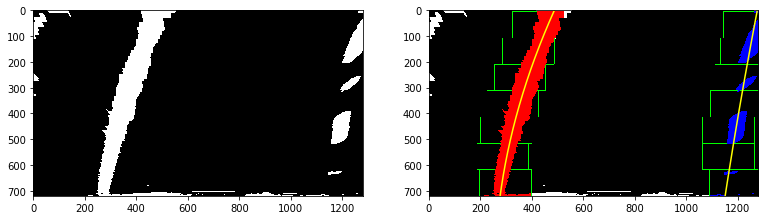

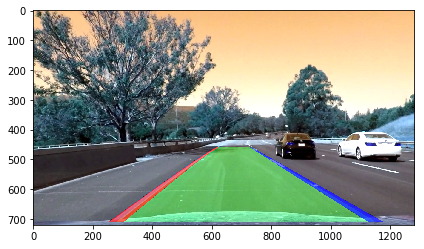

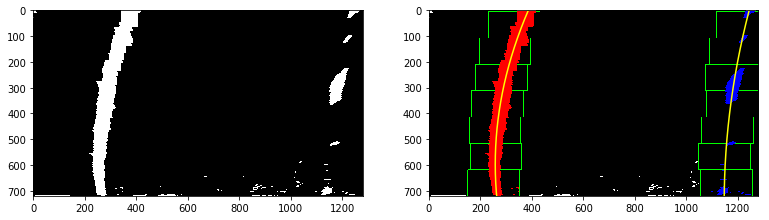

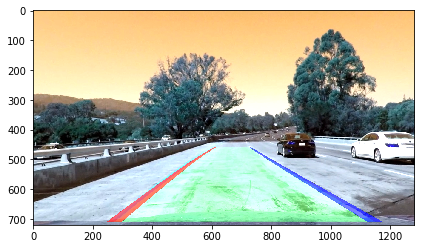

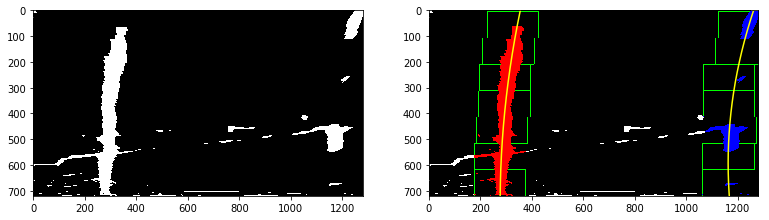

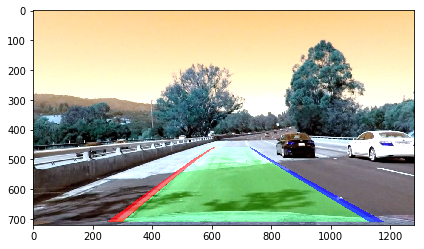

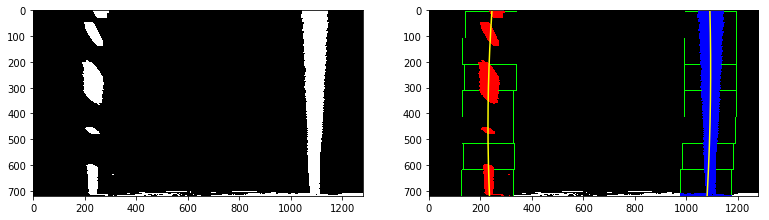

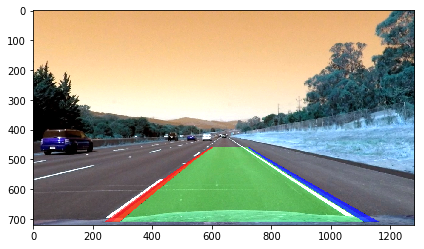

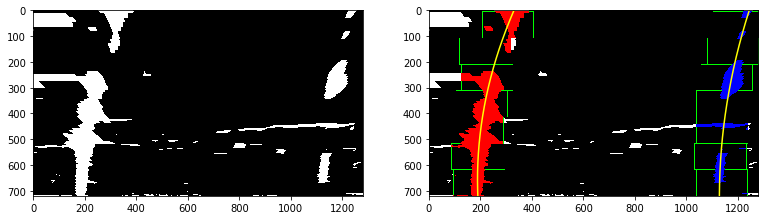

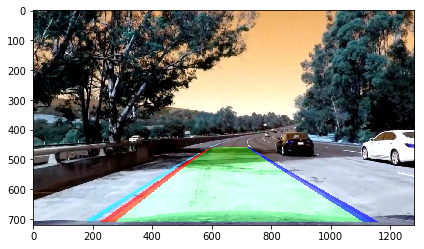

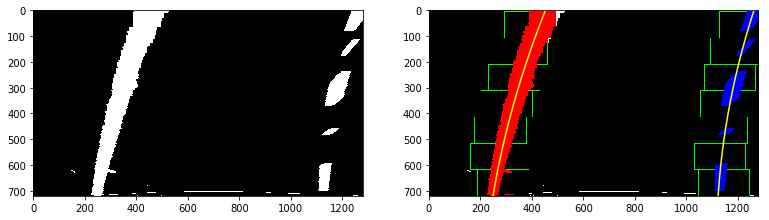

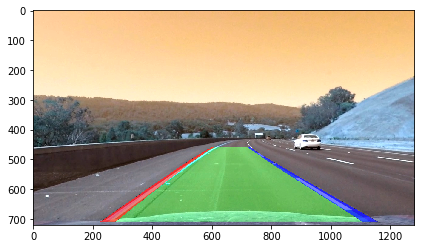

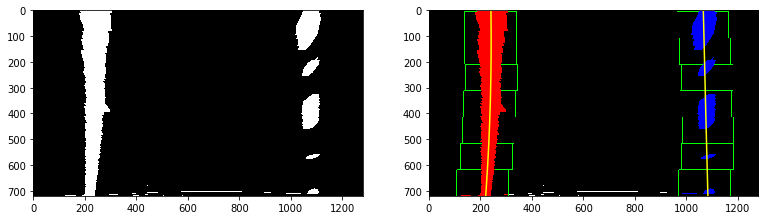

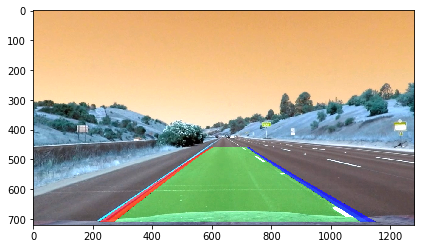

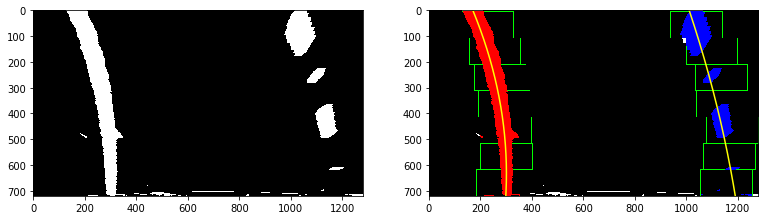

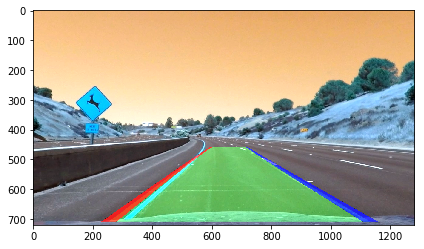

In [11]:
line_lt, line_rt = Line(buffer_len=10), Line(buffer_len=10)

ret, mtx, dist, rvecs, tvecs = camera_calibration(calib_dir='camera_cal')

for filename in os.listdir("test_images"):
    if filename.endswith(".jpg"):
        img = cv2.imread("test_images" + "/" + filename)

        img_undistorted = undistort_image(img, mtx, dist, plot=False)

        img_binary = binarize(img_undistorted, plot=False)

        img_birdeye, M, Minv = birdeye(img_binary, plot=False)

        line_lt, line_rt, img_out = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=7, plot=True)
        
        blend_onto_road = draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state = True)
        
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.imshow(blend_onto_road)
        plt.tight_layout()

In [12]:
from moviepy.editor import VideoFileClip

In [13]:
def sanity_check(left_fit, right_fit):
    #Performs a sanity check on the lane lines.

    #1. Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        print("delta_lines ",delta_lines)
        if delta_lines >= 150 and delta_lines <=950: #approx delta in pixels based on my experiments with code
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
         # Calculate slope of left and right lanes at top of y (i.e. 720)
        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        delta_slope_top =  np.abs(L_1-R_1)
        
        #Check if lines are parallel at the middle
        print("delta_slope_mid ",delta_slope_mid)
        if delta_slope_mid<=0.125:  #max slope allowed based on my experiments with code
            status = True
        else:
            status = False
    print("Status is ",status)
    return status

In [14]:
import copy

processed_frames = 0                    # counter of frames processed (when processing video)
line_lt = Line(buffer_len=time_window)  # line on the left of the lane
line_rt = Line(buffer_len=time_window)  # line on the right of the lane


def prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter):
    """
    Prepare the final pretty pretty output blend, given all intermediate pipeline images

    :param blend_on_road: color image of lane blend onto the road
    :param img_binary: thresholded binary image
    :param img_birdeye: bird's eye view of the thresholded binary image
    :param img_fit: bird's eye view with detected lane-lines highlighted
    :param line_lt: detected left lane-line
    :param line_rt: detected right lane-line
    :param offset_meter: offset from the center of the lane
    :return: pretty blend with all images and stuff stitched
    """
    h, w = blend_on_road.shape[:2]

    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)

    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = blend_on_road.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(w, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    blend_on_road = cv2.addWeighted(src1=mask, alpha=0.2, src2=blend_on_road, beta=0.8, gamma=0)

    # add thumbnail of binary image
    thumb_binary = cv2.resize(img_binary, dsize=(thumb_w, thumb_h))
    thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255
    blend_on_road[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary

    # add thumbnail of bird's eye view
    thumb_birdeye = cv2.resize(img_birdeye, dsize=(thumb_w, thumb_h))
    thumb_birdeye = np.dstack([thumb_birdeye, thumb_birdeye, thumb_birdeye]) * 255
    blend_on_road[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_birdeye

    # add thumbnail of bird's eye view (lane-line highlighted)
    thumb_img_fit = cv2.resize(img_fit, dsize=(thumb_w, thumb_h))
    blend_on_road[off_y:thumb_h+off_y, 3*off_x+2*thumb_w:3*(off_x+thumb_w), :] = thumb_img_fit

    # add text (curvature and offset info) on the upper right of the blend
    mean_curvature_meter = np.mean([line_lt.curvature_meter, line_rt.curvature_meter])
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blend_on_road, 'Curvature radius: {:.02f}m'.format(mean_curvature_meter), (860, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(blend_on_road, 'Offset from center: {:.02f}m'.format(offset_meter), (860, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)

    return blend_on_road




def process_pipeline(frame, keep_state=True):
    """
    Apply whole lane detection pipeline to an input color frame.
    :param frame: input color frame
    :param keep_state: if True, lane-line state is conserved (this permits to average results)
    :return: output blend with detected lane overlaid
    """

    global line_lt, line_rt, processed_frames,last_left, last_right

    # undistort the image using coefficients found in calibration
    img_undistorted = undistort_image(frame, mtx, dist, plot=False)

    # binarize the frame s.t. lane lines are highlighted as much as possible
    img_binary = binarize(img_undistorted, plot=False)

    # compute perspective transform to obtain bird's eye view
    img_birdeye, M, Minv = birdeye(img_binary, plot=False)

    # fit 2-degree polynomial curve onto lane lines found
    if processed_frames > 0 and keep_state and line_lt.detected and line_rt.detected:
        line_lt, line_rt, img_fit = get_fits_by_previous_fits(img_birdeye, line_lt, line_rt, plot=False)
    else:
        line_lt, line_rt, img_fit = get_fits_by_sliding_windows(img_birdeye, line_lt, line_rt, n_windows=9, plot=False)

        
        
    # Do Sanity check
    status =sanity_check(line_lt.last_fit_pixel, line_rt.last_fit_pixel)
    
    
    
    #Decide if to use calculated points
    if status == True:        
        #Save as last reliable fit
        last_left, last_right = copy.deepcopy(line_lt), copy.deepcopy(line_rt)        
        processed_frames += 1
    else:        #Use the last realible fit
        line_lt, line_rt = copy.deepcopy(last_left), copy.deepcopy(last_right)
        
        
    # compute offset in meter from center of the lane
    offset_meter = compute_offset_from_center(line_lt, line_rt, frame_width=frame.shape[1])

    # draw the surface enclosed by lane lines back onto the original frame
    blend_on_road = draw_back_onto_the_road(img_undistorted, Minv, line_lt, line_rt, keep_state)

    # stitch on the top of final output images from different steps of the pipeline
    blend_output = prepare_out_blend_frame(blend_on_road, img_binary, img_birdeye, img_fit, line_lt, line_rt, offset_meter)

    #processed_frames += 1

    return blend_output


### II.7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Loading cached camera calibration... Done.
delta_lines  788.7890458059803
delta_slope_mid  0.12042673661882691
Status is  True


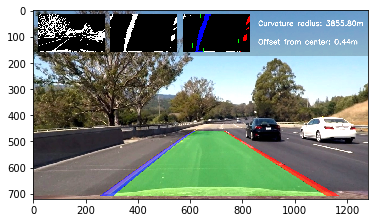

delta_lines  860.5175845861061
delta_slope_mid  0.03474286094824297
Status is  True


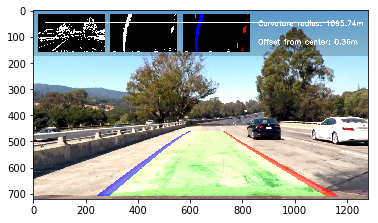

delta_lines  904.4629324872201
delta_slope_mid  0.02275856602014166
Status is  True


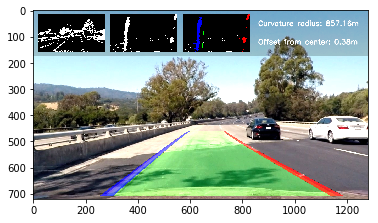

delta_lines  844.8267151923668
delta_slope_mid  0.0009725182480891936
Status is  True


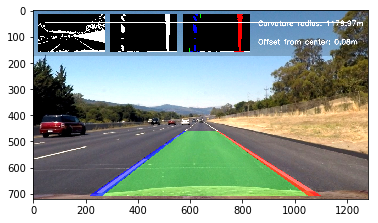

delta_lines  906.1896203055318
delta_slope_mid  0.04636610884722206
Status is  True


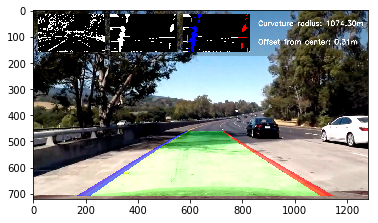

delta_lines  806.7341364249228
delta_slope_mid  0.09376323606634207
Status is  True


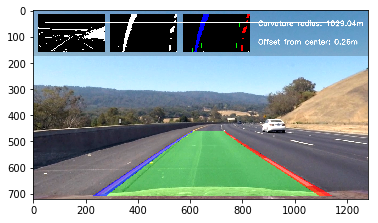

delta_lines  825.1106463232043
delta_slope_mid  0.05247304571657806
Status is  True


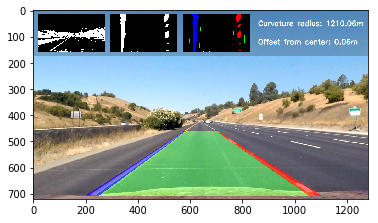

delta_lines  839.8793088336508
delta_slope_mid  0.07308598463733484
Status is  True


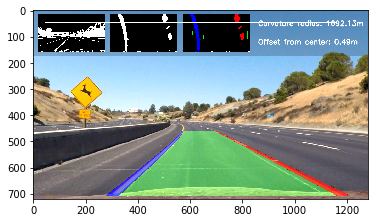

In [15]:
# first things first: calibrate the camera
ret, mtx, dist, rvecs, tvecs = camera_calibration(calib_images_dir='camera_cal')

for filename in os.listdir("test_images"):
    if filename.endswith(".jpg"):
        frame = cv2.imread("test_images" + "/" + filename)

        blend = process_pipeline(frame, keep_state=False)

        cv2.imwrite('output_images/{}'.format(filename), blend)

        plt.imshow(cv2.cvtColor(blend, code=cv2.COLOR_BGR2RGB))
        plt.show()


## Process Video

In [16]:
selector = 'project' #first phrase in video's name

clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(process_pipeline)
clip.write_videofile('out_{}_{}.mp4'.format(selector, time_window), audio=False)

delta_lines  845.9568816534651
delta_slope_mid  0.053393639567680035
Status is  True
[MoviePy] >>>> Building video out_project_10.mp4
[MoviePy] Writing video out_project_10.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

delta_lines  845.4831897038351
delta_slope_mid  0.05240763052819253
Status is  True


  0%|          | 2/1261 [00:00<05:17,  3.96it/s]

delta_lines  827.6743299483294
delta_slope_mid  0.07072348629320468
Status is  True


  0%|          | 3/1261 [00:00<05:09,  4.06it/s]

delta_lines  798.4702770512624
delta_slope_mid  0.10303444311160809
Status is  True


  0%|          | 4/1261 [00:00<05:01,  4.17it/s]

delta_lines  791.6700625569625
delta_slope_mid  0.12029511872294973
Status is  True


  0%|          | 5/1261 [00:01<04:54,  4.26it/s]

delta_lines  801.3742711263928
delta_slope_mid  0.10913047526819711
Status is  True


  0%|          | 6/1261 [00:01<04:50,  4.32it/s]

delta_lines  804.3802643792601
delta_slope_mid  0.10414197031901218
Status is  True


  1%|          | 7/1261 [00:01<04:50,  4.31it/s]

delta_lines  816.1796787312744
delta_slope_mid  0.08759388077118027
Status is  True


  1%|          | 8/1261 [00:01<04:52,  4.28it/s]

delta_lines  819.2738777435665
delta_slope_mid  0.10073524590395155
Status is  True


  1%|          | 9/1261 [00:02<04:48,  4.33it/s]

delta_lines  834.8931609029369
delta_slope_mid  0.0926978660028196
Status is  True


  1%|          | 10/1261 [00:02<04:55,  4.24it/s]

delta_lines  836.4152629882703
delta_slope_mid  0.08509601411300896
Status is  True


  1%|          | 11/1261 [00:02<04:53,  4.26it/s]

delta_lines  822.8890780032494
delta_slope_mid  0.08228348975370522
Status is  True


  1%|          | 12/1261 [00:02<04:49,  4.32it/s]

delta_lines  857.8880587044312
delta_slope_mid  0.03480825006639718
Status is  True


  1%|          | 13/1261 [00:03<04:46,  4.35it/s]

delta_lines  844.8409833560138
delta_slope_mid  0.04590205581170326
Status is  True


  1%|          | 14/1261 [00:03<04:51,  4.28it/s]

delta_lines  845.1451159586913
delta_slope_mid  0.047070180779056864
Status is  True


  1%|          | 15/1261 [00:03<05:00,  4.15it/s]

delta_lines  789.305742030662
delta_slope_mid  0.09876018026121375
Status is  True


  1%|▏         | 16/1261 [00:03<04:58,  4.17it/s]

delta_lines  766.8667191289984
delta_slope_mid  0.12821330682913812
Status is  False


  1%|▏         | 17/1261 [00:03<04:51,  4.27it/s]

delta_lines  774.602238628136
delta_slope_mid  0.12412563779093538
Status is  True


  1%|▏         | 18/1261 [00:04<04:46,  4.34it/s]

delta_lines  774.987728223045
delta_slope_mid  0.1237071310093649
Status is  True


  2%|▏         | 19/1261 [00:04<04:58,  4.16it/s]

delta_lines  793.2426647779574
delta_slope_mid  0.10060626095018194
Status is  True


  2%|▏         | 20/1261 [00:04<04:53,  4.23it/s]

delta_lines  807.6094378486822
delta_slope_mid  0.08288216618389782
Status is  True


  2%|▏         | 21/1261 [00:04<04:49,  4.28it/s]

delta_lines  827.1451379198728
delta_slope_mid  0.06974014388739844
Status is  True


  2%|▏         | 22/1261 [00:05<04:47,  4.31it/s]

delta_lines  847.0664889192074
delta_slope_mid  0.050930972273805886
Status is  True


  2%|▏         | 23/1261 [00:05<04:46,  4.32it/s]

delta_lines  865.2822065746607
delta_slope_mid  0.0338429564836345
Status is  True


  2%|▏         | 24/1261 [00:05<04:43,  4.37it/s]

delta_lines  839.1811468499372
delta_slope_mid  0.04906064192348303
Status is  True


  2%|▏         | 25/1261 [00:05<04:39,  4.42it/s]

delta_lines  830.2769098031725
delta_slope_mid  0.05800376510917271
Status is  True


  2%|▏         | 26/1261 [00:06<04:50,  4.25it/s]

delta_lines  848.1999298416024
delta_slope_mid  0.03967773282515091
Status is  True


  2%|▏         | 27/1261 [00:06<04:51,  4.24it/s]

delta_lines  856.1759017356237
delta_slope_mid  0.04181637865837673
Status is  True


  2%|▏         | 28/1261 [00:06<04:53,  4.20it/s]

delta_lines  881.6867865226635
delta_slope_mid  0.018077390709628882
Status is  True


  2%|▏         | 29/1261 [00:06<04:46,  4.30it/s]

delta_lines  845.4422019593749
delta_slope_mid  0.0631577390692058
Status is  True


  2%|▏         | 30/1261 [00:07<04:45,  4.32it/s]

delta_lines  811.4670384166508
delta_slope_mid  0.10522666441107362
Status is  True


  2%|▏         | 31/1261 [00:07<04:45,  4.30it/s]

delta_lines  808.1826605297325
delta_slope_mid  0.11452298405072014
Status is  True


  3%|▎         | 32/1261 [00:07<04:43,  4.34it/s]

delta_lines  799.8400552906037
delta_slope_mid  0.1278839574624739
Status is  False


  3%|▎         | 33/1261 [00:07<04:39,  4.39it/s]

delta_lines  819.1650874110672
delta_slope_mid  0.10023803883527188
Status is  True


  3%|▎         | 34/1261 [00:07<04:35,  4.45it/s]

delta_lines  822.2907550698177
delta_slope_mid  0.11647039376411422
Status is  True


  3%|▎         | 35/1261 [00:08<04:38,  4.41it/s]

delta_lines  823.4861167178215
delta_slope_mid  0.11674695907684418
Status is  True


  3%|▎         | 36/1261 [00:08<04:39,  4.39it/s]

delta_lines  816.6927353715635
delta_slope_mid  0.12037709398923568
Status is  True


  3%|▎         | 37/1261 [00:08<04:35,  4.44it/s]

delta_lines  801.1248098380466
delta_slope_mid  0.11686515318467205
Status is  True


  3%|▎         | 38/1261 [00:08<04:33,  4.47it/s]

delta_lines  791.2437987022657
delta_slope_mid  0.11946323916338336
Status is  True


  3%|▎         | 39/1261 [00:09<04:43,  4.31it/s]

delta_lines  753.2341757617082
delta_slope_mid  0.147730210544941
Status is  False


  3%|▎         | 40/1261 [00:09<04:43,  4.30it/s]

delta_lines  758.6243432321633
delta_slope_mid  0.14669103253413518
Status is  False


  3%|▎         | 41/1261 [00:09<04:43,  4.31it/s]

delta_lines  760.9952689055333
delta_slope_mid  0.1510722163990914
Status is  False


  3%|▎         | 42/1261 [00:09<04:43,  4.29it/s]

delta_lines  773.9777329706774
delta_slope_mid  0.14430381055962366
Status is  False


  3%|▎         | 43/1261 [00:10<05:02,  4.03it/s]

delta_lines  786.9798576097553
delta_slope_mid  0.12377782210994415
Status is  True


  3%|▎         | 44/1261 [00:10<04:56,  4.11it/s]

delta_lines  806.2149557846802
delta_slope_mid  0.09907562637737422
Status is  True


  4%|▎         | 45/1261 [00:10<04:48,  4.21it/s]

delta_lines  822.3458567636422
delta_slope_mid  0.076950353719066
Status is  True


  4%|▎         | 46/1261 [00:10<04:50,  4.18it/s]

delta_lines  833.4790403213643
delta_slope_mid  0.06727830931999457
Status is  True


  4%|▎         | 47/1261 [00:10<04:45,  4.25it/s]

delta_lines  845.3899879020486
delta_slope_mid  0.0651301389304072
Status is  True


  4%|▍         | 48/1261 [00:11<04:53,  4.13it/s]

delta_lines  844.4908500109466
delta_slope_mid  0.07247683845089115
Status is  True


  4%|▍         | 49/1261 [00:11<04:50,  4.17it/s]

delta_lines  856.0614949667813
delta_slope_mid  0.04578787827141817
Status is  True


  4%|▍         | 50/1261 [00:11<04:55,  4.10it/s]

delta_lines  837.9338203850493
delta_slope_mid  0.048282132366553765
Status is  True


  4%|▍         | 51/1261 [00:11<04:53,  4.12it/s]

delta_lines  838.8756809071095
delta_slope_mid  0.045754737367969145
Status is  True


  4%|▍         | 52/1261 [00:12<05:03,  3.99it/s]

delta_lines  810.7235401004457
delta_slope_mid  0.07219232889538368
Status is  True


  4%|▍         | 53/1261 [00:12<05:05,  3.96it/s]

delta_lines  786.075167687586
delta_slope_mid  0.09404382492092722
Status is  True


  4%|▍         | 54/1261 [00:12<04:55,  4.08it/s]

delta_lines  774.6538116987323
delta_slope_mid  0.11453921750641854
Status is  True


  4%|▍         | 55/1261 [00:12<04:51,  4.14it/s]

delta_lines  783.412839683132
delta_slope_mid  0.112248928118415
Status is  True


  4%|▍         | 56/1261 [00:13<04:55,  4.08it/s]

delta_lines  793.9472148847385
delta_slope_mid  0.1005388565561835
Status is  True


  5%|▍         | 57/1261 [00:13<04:52,  4.12it/s]

delta_lines  797.8021157115346
delta_slope_mid  0.10386915788785545
Status is  True


  5%|▍         | 58/1261 [00:13<04:51,  4.13it/s]

delta_lines  807.1706368352932
delta_slope_mid  0.10228652809274028
Status is  True


  5%|▍         | 59/1261 [00:13<04:46,  4.20it/s]

delta_lines  790.0799279097793
delta_slope_mid  0.13395319019265
Status is  False


  5%|▍         | 60/1261 [00:14<04:43,  4.24it/s]

delta_lines  763.8740744339871
delta_slope_mid  0.15142879961935363
Status is  False


  5%|▍         | 61/1261 [00:14<04:44,  4.22it/s]

delta_lines  765.0209884048634
delta_slope_mid  0.1579065159144969
Status is  False


  5%|▍         | 62/1261 [00:14<04:42,  4.24it/s]

delta_lines  738.9336045415913
delta_slope_mid  0.1766081662913183
Status is  False


  5%|▍         | 63/1261 [00:14<04:41,  4.26it/s]

delta_lines  748.3132138179674
delta_slope_mid  0.1632189305828267
Status is  False


  5%|▌         | 64/1261 [00:15<04:39,  4.28it/s]

delta_lines  731.1781387047748
delta_slope_mid  0.18307675181517424
Status is  False


  5%|▌         | 65/1261 [00:15<04:39,  4.28it/s]

delta_lines  742.0226742690556
delta_slope_mid  0.1723096025332896
Status is  False


  5%|▌         | 66/1261 [00:15<04:49,  4.13it/s]

delta_lines  740.7557406519556
delta_slope_mid  0.1785714068685112
Status is  False


  5%|▌         | 67/1261 [00:15<04:47,  4.16it/s]

delta_lines  753.6565409197416
delta_slope_mid  0.16250968136382984
Status is  False


  5%|▌         | 68/1261 [00:16<04:52,  4.07it/s]

delta_lines  770.6880378545031
delta_slope_mid  0.14615533322999372
Status is  False


  5%|▌         | 69/1261 [00:16<04:47,  4.15it/s]

delta_lines  766.2582882414255
delta_slope_mid  0.1498208410405071
Status is  False


  6%|▌         | 70/1261 [00:16<04:41,  4.23it/s]

delta_lines  785.2547128876614
delta_slope_mid  0.12952795342961232
Status is  False


  6%|▌         | 71/1261 [00:16<04:56,  4.01it/s]

delta_lines  787.793033087897
delta_slope_mid  0.14233510792642362
Status is  False


  6%|▌         | 72/1261 [00:17<04:57,  4.00it/s]

delta_lines  799.7450509718035
delta_slope_mid  0.11709609082274641
Status is  True


  6%|▌         | 73/1261 [00:17<04:46,  4.15it/s]

delta_lines  802.5934190406658
delta_slope_mid  0.09998093752652215
Status is  True


  6%|▌         | 74/1261 [00:17<04:52,  4.05it/s]

delta_lines  800.053895372997
delta_slope_mid  0.09486114750266689
Status is  True


  6%|▌         | 75/1261 [00:17<04:48,  4.11it/s]

delta_lines  803.2274376665756
delta_slope_mid  0.07645283601003472
Status is  True


  6%|▌         | 76/1261 [00:17<04:46,  4.14it/s]

delta_lines  765.2605130829081
delta_slope_mid  0.09951245415360932
Status is  True


  6%|▌         | 77/1261 [00:18<04:40,  4.21it/s]

delta_lines  796.7512411769849
delta_slope_mid  0.06682289917353526
Status is  True


  6%|▌         | 78/1261 [00:18<04:48,  4.10it/s]

delta_lines  793.7686595868324
delta_slope_mid  0.07788055288048357
Status is  True


  6%|▋         | 79/1261 [00:18<04:40,  4.21it/s]

delta_lines  795.0636377794194
delta_slope_mid  0.08308454856427919
Status is  True


  6%|▋         | 80/1261 [00:18<04:41,  4.20it/s]

delta_lines  797.4198428003408
delta_slope_mid  0.09135356428866015
Status is  True


  6%|▋         | 81/1261 [00:19<04:38,  4.23it/s]

delta_lines  790.5391541933052
delta_slope_mid  0.10622097676096215
Status is  True


  7%|▋         | 82/1261 [00:19<04:45,  4.13it/s]

delta_lines  804.3207896431359
delta_slope_mid  0.09481912117379715
Status is  True


  7%|▋         | 83/1261 [00:19<04:49,  4.06it/s]

delta_lines  815.6709918858597
delta_slope_mid  0.08949135161830268
Status is  True


  7%|▋         | 84/1261 [00:19<04:48,  4.08it/s]

delta_lines  844.6983491451061
delta_slope_mid  0.07658318106940176
Status is  True


  7%|▋         | 85/1261 [00:20<04:40,  4.19it/s]

delta_lines  847.6449761275824
delta_slope_mid  0.09267710945470978
Status is  True


  7%|▋         | 86/1261 [00:20<04:48,  4.08it/s]

delta_lines  851.2563644416398
delta_slope_mid  0.0968996288236883
Status is  True


  7%|▋         | 87/1261 [00:20<04:42,  4.15it/s]

delta_lines  810.9696775598771
delta_slope_mid  0.12276815662480811
Status is  True


  7%|▋         | 88/1261 [00:20<04:40,  4.19it/s]

delta_lines  790.9617343380901
delta_slope_mid  0.14201210859772304
Status is  False


  7%|▋         | 89/1261 [00:21<04:37,  4.23it/s]

delta_lines  760.2131417430608
delta_slope_mid  0.16679624746868033
Status is  False


  7%|▋         | 90/1261 [00:21<04:39,  4.18it/s]

delta_lines  732.0240697792186
delta_slope_mid  0.2054100304389502
Status is  False


  7%|▋         | 91/1261 [00:21<04:46,  4.08it/s]

delta_lines  746.4374242537176
delta_slope_mid  0.19234906723310793
Status is  False


  7%|▋         | 92/1261 [00:21<04:49,  4.03it/s]

delta_lines  757.3927923699166
delta_slope_mid  0.1813582483708032
Status is  False


  7%|▋         | 93/1261 [00:22<04:50,  4.02it/s]

delta_lines  757.5133281640935
delta_slope_mid  0.1786160847050667
Status is  False


  7%|▋         | 94/1261 [00:22<04:40,  4.16it/s]

delta_lines  762.8968653990443
delta_slope_mid  0.16706528750046507
Status is  False


  8%|▊         | 95/1261 [00:22<04:39,  4.18it/s]

delta_lines  777.9252634441575
delta_slope_mid  0.14858813208903662
Status is  False


  8%|▊         | 96/1261 [00:22<04:41,  4.14it/s]

delta_lines  787.1872716841249
delta_slope_mid  0.14859507854048154
Status is  False


  8%|▊         | 97/1261 [00:23<04:44,  4.09it/s]

delta_lines  786.8267904019727
delta_slope_mid  0.13600517493853245
Status is  False


  8%|▊         | 98/1261 [00:23<04:45,  4.08it/s]

delta_lines  799.6973819606344
delta_slope_mid  0.11405473865434565
Status is  True


  8%|▊         | 99/1261 [00:23<04:45,  4.07it/s]

delta_lines  782.9787382530562
delta_slope_mid  0.1192589473371776
Status is  True


  8%|▊         | 100/1261 [00:23<04:39,  4.15it/s]

delta_lines  793.5209464827174
delta_slope_mid  0.0982192317436148
Status is  True


  8%|▊         | 101/1261 [00:24<04:40,  4.13it/s]

delta_lines  780.4575533329822
delta_slope_mid  0.10585219433829426
Status is  True


  8%|▊         | 102/1261 [00:24<04:36,  4.20it/s]

delta_lines  755.5748580840182
delta_slope_mid  0.12683998019074028
Status is  False


  8%|▊         | 103/1261 [00:24<04:35,  4.21it/s]

delta_lines  755.4090593675891
delta_slope_mid  0.13409000205077962
Status is  False


  8%|▊         | 104/1261 [00:24<04:35,  4.20it/s]

delta_lines  758.1532362151939
delta_slope_mid  0.13570572571911138
Status is  False


  8%|▊         | 105/1261 [00:24<04:27,  4.32it/s]

delta_lines  777.916144528318
delta_slope_mid  0.11969831984672144
Status is  True


  8%|▊         | 106/1261 [00:25<04:25,  4.35it/s]

delta_lines  794.5515036981823
delta_slope_mid  0.10007309700291389
Status is  True


  8%|▊         | 107/1261 [00:25<04:22,  4.40it/s]

delta_lines  811.0565946632971
delta_slope_mid  0.0812271602902448
Status is  True


  9%|▊         | 108/1261 [00:25<04:22,  4.39it/s]

delta_lines  807.9144421670571
delta_slope_mid  0.08747538640740135
Status is  True


  9%|▊         | 109/1261 [00:25<04:28,  4.28it/s]

delta_lines  816.458828525051
delta_slope_mid  0.08385200948856933
Status is  True


  9%|▊         | 110/1261 [00:26<04:30,  4.26it/s]

delta_lines  825.8230868532783
delta_slope_mid  0.08417713889792372
Status is  True


  9%|▉         | 111/1261 [00:26<04:32,  4.22it/s]

delta_lines  825.9004354081595
delta_slope_mid  0.08228635864818717
Status is  True


  9%|▉         | 112/1261 [00:26<04:35,  4.18it/s]

delta_lines  845.5012591390902
delta_slope_mid  0.04993600401824402
Status is  True


  9%|▉         | 113/1261 [00:26<04:35,  4.17it/s]

delta_lines  814.881547991454
delta_slope_mid  0.07859054267173693
Status is  True


  9%|▉         | 114/1261 [00:27<04:36,  4.15it/s]

delta_lines  811.0867425627692
delta_slope_mid  0.07804820250262703
Status is  True


  9%|▉         | 115/1261 [00:27<04:29,  4.26it/s]

delta_lines  773.0225505427933
delta_slope_mid  0.11616398924931856
Status is  True


  9%|▉         | 116/1261 [00:27<04:30,  4.24it/s]

delta_lines  759.2637546577121
delta_slope_mid  0.13710075687167614
Status is  False


  9%|▉         | 117/1261 [00:27<04:25,  4.31it/s]

delta_lines  765.4228837902017
delta_slope_mid  0.13718503346522137
Status is  False


  9%|▉         | 118/1261 [00:28<04:33,  4.18it/s]

delta_lines  769.7902941623574
delta_slope_mid  0.13733280424283828
Status is  False


  9%|▉         | 119/1261 [00:28<04:32,  4.19it/s]

delta_lines  777.8844485788159
delta_slope_mid  0.12836085045252987
Status is  False


 10%|▉         | 120/1261 [00:28<04:39,  4.08it/s]

delta_lines  774.3150258917759
delta_slope_mid  0.13358773215987663
Status is  False


 10%|▉         | 121/1261 [00:28<04:42,  4.03it/s]

delta_lines  785.8025749953335
delta_slope_mid  0.12136034208443852
Status is  True


 10%|▉         | 122/1261 [00:29<04:38,  4.09it/s]

delta_lines  782.547945104983
delta_slope_mid  0.13205357231207487
Status is  False


 10%|▉         | 123/1261 [00:29<04:36,  4.11it/s]

delta_lines  771.4491346146634
delta_slope_mid  0.13768728518085088
Status is  False


 10%|▉         | 124/1261 [00:29<04:40,  4.06it/s]

delta_lines  766.5497297802696
delta_slope_mid  0.14193396553332333
Status is  False


 10%|▉         | 125/1261 [00:29<04:34,  4.14it/s]

delta_lines  744.3368879377704
delta_slope_mid  0.15307546988566956
Status is  False


 10%|▉         | 126/1261 [00:29<04:32,  4.16it/s]

delta_lines  757.5085897585881
delta_slope_mid  0.12691747178669743
Status is  False


 10%|█         | 127/1261 [00:30<04:29,  4.20it/s]

delta_lines  744.3115326143851
delta_slope_mid  0.14871100232748086
Status is  False


 10%|█         | 128/1261 [00:30<04:28,  4.21it/s]

delta_lines  755.0129773719497
delta_slope_mid  0.14239906399749166
Status is  False


 10%|█         | 129/1261 [00:30<04:30,  4.19it/s]

delta_lines  739.7542981466215
delta_slope_mid  0.17300826792515217
Status is  False


 10%|█         | 130/1261 [00:30<04:28,  4.22it/s]

delta_lines  753.4072240877607
delta_slope_mid  0.15966392039307725
Status is  False


 10%|█         | 131/1261 [00:31<04:26,  4.24it/s]

delta_lines  757.2945755912342
delta_slope_mid  0.15058171778534635
Status is  False


 10%|█         | 132/1261 [00:31<04:25,  4.26it/s]

delta_lines  758.5779940644898
delta_slope_mid  0.14737840293028237
Status is  False


 11%|█         | 133/1261 [00:31<04:27,  4.22it/s]

delta_lines  769.12020093676
delta_slope_mid  0.14100070476868382
Status is  False


 11%|█         | 134/1261 [00:31<04:20,  4.33it/s]

delta_lines  771.2306662422857
delta_slope_mid  0.15155865390140325
Status is  False


 11%|█         | 135/1261 [00:32<04:32,  4.14it/s]

delta_lines  776.0618103381723
delta_slope_mid  0.13433378344402874
Status is  False


 11%|█         | 136/1261 [00:32<04:27,  4.21it/s]

delta_lines  781.8381064660176
delta_slope_mid  0.12559923690509542
Status is  False


 11%|█         | 137/1261 [00:32<04:27,  4.20it/s]

delta_lines  785.3537343329978
delta_slope_mid  0.10990140395735967
Status is  True


 11%|█         | 138/1261 [00:32<04:33,  4.11it/s]

delta_lines  807.8284179681586
delta_slope_mid  0.09007214101227984
Status is  True


 11%|█         | 139/1261 [00:33<04:28,  4.17it/s]

delta_lines  803.9074433277189
delta_slope_mid  0.0956037853057439
Status is  True


 11%|█         | 140/1261 [00:33<04:32,  4.11it/s]

delta_lines  814.2181392408208
delta_slope_mid  0.08056815185288413
Status is  True


 11%|█         | 141/1261 [00:33<04:29,  4.16it/s]

delta_lines  798.594157568285
delta_slope_mid  0.10083788448253711
Status is  True


 11%|█▏        | 142/1261 [00:33<04:23,  4.24it/s]

delta_lines  793.7221559259549
delta_slope_mid  0.1141338211595177
Status is  True


 11%|█▏        | 143/1261 [00:34<04:17,  4.34it/s]

delta_lines  783.6801576784126
delta_slope_mid  0.12720747774949862
Status is  False


 11%|█▏        | 144/1261 [00:34<04:29,  4.15it/s]

delta_lines  789.9956812482993
delta_slope_mid  0.11928738976562292
Status is  True


 11%|█▏        | 145/1261 [00:34<04:27,  4.17it/s]

delta_lines  798.2738812289723
delta_slope_mid  0.11027022912862444
Status is  True


 12%|█▏        | 146/1261 [00:34<04:23,  4.23it/s]

delta_lines  795.5084699433364
delta_slope_mid  0.12091973039961726
Status is  True


 12%|█▏        | 147/1261 [00:35<04:40,  3.97it/s]

delta_lines  803.5029858961786
delta_slope_mid  0.11538578933625324
Status is  True


 12%|█▏        | 148/1261 [00:35<04:40,  3.97it/s]

delta_lines  765.5910060150933
delta_slope_mid  0.14431787005750737
Status is  False


 12%|█▏        | 149/1261 [00:35<04:35,  4.04it/s]

delta_lines  760.5625254507097
delta_slope_mid  0.14318076685918507
Status is  False


 12%|█▏        | 150/1261 [00:35<04:33,  4.07it/s]

delta_lines  762.7308863619498
delta_slope_mid  0.12706102656865534
Status is  False


 12%|█▏        | 151/1261 [00:35<04:25,  4.18it/s]

delta_lines  753.0229460910502
delta_slope_mid  0.12385419805121575
Status is  True


 12%|█▏        | 152/1261 [00:36<04:19,  4.27it/s]

delta_lines  762.3310787878025
delta_slope_mid  0.11755543547222838
Status is  True


 12%|█▏        | 153/1261 [00:36<04:18,  4.28it/s]

delta_lines  747.5211843583744
delta_slope_mid  0.146908408826908
Status is  False


 12%|█▏        | 154/1261 [00:36<04:15,  4.33it/s]

delta_lines  767.8174541677467
delta_slope_mid  0.1295969134559748
Status is  False


 12%|█▏        | 155/1261 [00:36<04:13,  4.36it/s]

delta_lines  781.6163593448092
delta_slope_mid  0.1251701849058656
Status is  False


 12%|█▏        | 156/1261 [00:37<04:34,  4.02it/s]

delta_lines  789.1603154772172
delta_slope_mid  0.12120869812047186
Status is  True


 12%|█▏        | 157/1261 [00:37<04:38,  3.96it/s]

delta_lines  798.674115756434
delta_slope_mid  0.11365041808634069
Status is  True


 13%|█▎        | 158/1261 [00:37<04:35,  4.00it/s]

delta_lines  790.6746725053662
delta_slope_mid  0.12797590342515192
Status is  False


 13%|█▎        | 159/1261 [00:37<04:25,  4.16it/s]

delta_lines  804.761539588289
delta_slope_mid  0.1324781738579738
Status is  False


 13%|█▎        | 160/1261 [00:38<04:22,  4.19it/s]

delta_lines  799.6163384314455
delta_slope_mid  0.13253227088446443
Status is  False


 13%|█▎        | 161/1261 [00:38<04:18,  4.25it/s]

delta_lines  816.4944952795538
delta_slope_mid  0.11019719278975362
Status is  True


 13%|█▎        | 162/1261 [00:38<04:19,  4.24it/s]

delta_lines  826.641771877115
delta_slope_mid  0.10197679340666743
Status is  True


 13%|█▎        | 163/1261 [00:38<04:16,  4.28it/s]

delta_lines  832.7798318356033
delta_slope_mid  0.08301017055881652
Status is  True


 13%|█▎        | 164/1261 [00:39<04:15,  4.29it/s]

delta_lines  790.675073718748
delta_slope_mid  0.1165102581121426
Status is  True


 13%|█▎        | 165/1261 [00:39<04:19,  4.22it/s]

delta_lines  756.0559055321601
delta_slope_mid  0.1575779440243944
Status is  False


 13%|█▎        | 166/1261 [00:39<04:14,  4.30it/s]

delta_lines  767.8030649447903
delta_slope_mid  0.14906867147953676
Status is  False


 13%|█▎        | 167/1261 [00:39<04:13,  4.31it/s]

delta_lines  769.3653487697621
delta_slope_mid  0.15260301669205775
Status is  False


 13%|█▎        | 168/1261 [00:39<04:15,  4.28it/s]

delta_lines  795.6609948983408
delta_slope_mid  0.11603256805925882
Status is  True


 13%|█▎        | 169/1261 [00:40<04:11,  4.34it/s]

delta_lines  810.3360051379161
delta_slope_mid  0.09752759731987795
Status is  True


 13%|█▎        | 170/1261 [00:40<04:11,  4.34it/s]

delta_lines  830.4901707496301
delta_slope_mid  0.06974679408777698
Status is  True


 14%|█▎        | 171/1261 [00:40<04:11,  4.34it/s]

delta_lines  838.8242106324103
delta_slope_mid  0.054013179129074884
Status is  True


 14%|█▎        | 172/1261 [00:40<04:13,  4.30it/s]

delta_lines  839.5908506141323
delta_slope_mid  0.05979301805716894
Status is  True


 14%|█▎        | 173/1261 [00:41<04:19,  4.19it/s]

delta_lines  821.3728537185874
delta_slope_mid  0.07253604846330439
Status is  True


 14%|█▍        | 174/1261 [00:41<04:22,  4.14it/s]

delta_lines  789.1849207100616
delta_slope_mid  0.10003111564345399
Status is  True


 14%|█▍        | 175/1261 [00:41<04:24,  4.11it/s]

delta_lines  740.1457909833348
delta_slope_mid  0.1376338309844252
Status is  False


 14%|█▍        | 176/1261 [00:41<04:21,  4.15it/s]

delta_lines  726.2626801535766
delta_slope_mid  0.15480472642115506
Status is  False


 14%|█▍        | 177/1261 [00:42<04:16,  4.23it/s]

delta_lines  747.6680534822411
delta_slope_mid  0.13889204558838023
Status is  False


 14%|█▍        | 178/1261 [00:42<04:17,  4.20it/s]

delta_lines  755.0605667098224
delta_slope_mid  0.14580537205079339
Status is  False


 14%|█▍        | 179/1261 [00:42<04:14,  4.24it/s]

delta_lines  763.3303200185376
delta_slope_mid  0.15216480641815838
Status is  False


 14%|█▍        | 180/1261 [00:42<04:11,  4.30it/s]

delta_lines  779.6067906698916
delta_slope_mid  0.1504438511726625
Status is  False


 14%|█▍        | 181/1261 [00:43<04:16,  4.21it/s]

delta_lines  776.5861275604027
delta_slope_mid  0.1633564225761408
Status is  False


 14%|█▍        | 182/1261 [00:43<04:16,  4.21it/s]

delta_lines  793.0915480875442
delta_slope_mid  0.14933241331723776
Status is  False


 15%|█▍        | 183/1261 [00:43<04:12,  4.27it/s]

delta_lines  784.5445043372151
delta_slope_mid  0.17137257980547005
Status is  False


 15%|█▍        | 184/1261 [00:43<04:12,  4.26it/s]

delta_lines  772.1477217674618
delta_slope_mid  0.19783277901180035
Status is  False


 15%|█▍        | 185/1261 [00:44<04:10,  4.29it/s]

delta_lines  755.6678760775096
delta_slope_mid  0.2130408973633377
Status is  False


 15%|█▍        | 186/1261 [00:44<04:04,  4.40it/s]

delta_lines  705.724356003146
delta_slope_mid  0.25891638907470177
Status is  False


 15%|█▍        | 187/1261 [00:44<04:09,  4.31it/s]

delta_lines  701.499295038278
delta_slope_mid  0.26139749931824074
Status is  False


 15%|█▍        | 188/1261 [00:44<04:14,  4.22it/s]

delta_lines  703.5232369668553
delta_slope_mid  0.26466853780137417
Status is  False


 15%|█▍        | 189/1261 [00:44<04:10,  4.28it/s]

delta_lines  710.2453797484997
delta_slope_mid  0.25377122042976524
Status is  False


 15%|█▌        | 190/1261 [00:45<04:09,  4.29it/s]

delta_lines  712.782958156957
delta_slope_mid  0.24636788413424487
Status is  False


 15%|█▌        | 191/1261 [00:45<04:09,  4.30it/s]

delta_lines  713.538459414323
delta_slope_mid  0.24199244836091977
Status is  False


 15%|█▌        | 192/1261 [00:45<04:11,  4.26it/s]

delta_lines  723.1460448770329
delta_slope_mid  0.2256083474551921
Status is  False


 15%|█▌        | 193/1261 [00:45<04:16,  4.17it/s]

delta_lines  718.2383386304067
delta_slope_mid  0.22420202995665967
Status is  False


 15%|█▌        | 194/1261 [00:46<04:08,  4.30it/s]

delta_lines  723.5247219792842
delta_slope_mid  0.21161347926225232
Status is  False


 15%|█▌        | 195/1261 [00:46<04:09,  4.27it/s]

delta_lines  725.1737280942226
delta_slope_mid  0.20491958073057637
Status is  False


 16%|█▌        | 196/1261 [00:46<04:08,  4.28it/s]

delta_lines  774.8652334076648
delta_slope_mid  0.1423923018358032
Status is  False


 16%|█▌        | 197/1261 [00:46<04:08,  4.28it/s]

delta_lines  817.5723777719426
delta_slope_mid  0.09900869981119154
Status is  True


 16%|█▌        | 198/1261 [00:47<04:10,  4.25it/s]

delta_lines  863.0559538149655
delta_slope_mid  0.06399554097542287
Status is  True


 16%|█▌        | 199/1261 [00:47<04:05,  4.33it/s]

delta_lines  899.0488655871359
delta_slope_mid  0.024661201068232996
Status is  True


 16%|█▌        | 200/1261 [00:47<04:12,  4.20it/s]

delta_lines  886.224455055693
delta_slope_mid  0.028049558498567467
Status is  True


 16%|█▌        | 201/1261 [00:47<04:14,  4.16it/s]

delta_lines  880.196782649776
delta_slope_mid  0.020431778855393185
Status is  True


 16%|█▌        | 202/1261 [00:48<04:10,  4.23it/s]

delta_lines  857.2810560676304
delta_slope_mid  0.051043670666888946
Status is  True


 16%|█▌        | 203/1261 [00:48<04:10,  4.23it/s]

delta_lines  815.7323266346759
delta_slope_mid  0.09504227001895887
Status is  True


 16%|█▌        | 204/1261 [00:48<04:14,  4.15it/s]

delta_lines  811.4072189598688
delta_slope_mid  0.11113099655295092
Status is  True


 16%|█▋        | 205/1261 [00:48<04:15,  4.14it/s]

delta_lines  791.6970452200177
delta_slope_mid  0.13938931502231094
Status is  False


 16%|█▋        | 206/1261 [00:48<04:19,  4.07it/s]

delta_lines  796.7874558032333
delta_slope_mid  0.13395098406878825
Status is  False


 16%|█▋        | 207/1261 [00:49<04:15,  4.13it/s]

delta_lines  778.4498861684003
delta_slope_mid  0.16216308813406166
Status is  False


 16%|█▋        | 208/1261 [00:49<04:27,  3.94it/s]

delta_lines  768.036912767288
delta_slope_mid  0.18616086285606856
Status is  False


 17%|█▋        | 209/1261 [00:49<04:29,  3.90it/s]

delta_lines  785.5835825915271
delta_slope_mid  0.1686520847095824
Status is  False


 17%|█▋        | 210/1261 [00:49<04:21,  4.02it/s]

delta_lines  799.3276274020164
delta_slope_mid  0.1430166587298564
Status is  False


 17%|█▋        | 211/1261 [00:50<04:16,  4.10it/s]

delta_lines  828.2305890760186
delta_slope_mid  0.10386393070088179
Status is  True


 17%|█▋        | 212/1261 [00:50<04:14,  4.12it/s]

delta_lines  812.0551236782601
delta_slope_mid  0.11661612226844326
Status is  True


 17%|█▋        | 213/1261 [00:50<04:08,  4.21it/s]

delta_lines  818.3961853878498
delta_slope_mid  0.1079030637912238
Status is  True


 17%|█▋        | 214/1261 [00:50<04:06,  4.25it/s]

delta_lines  803.3775290041212
delta_slope_mid  0.12247157750847545
Status is  True


 17%|█▋        | 215/1261 [00:51<04:10,  4.18it/s]

delta_lines  777.5037590932745
delta_slope_mid  0.14793783781866202
Status is  False


 17%|█▋        | 216/1261 [00:51<04:08,  4.21it/s]

delta_lines  780.5454875552447
delta_slope_mid  0.149208403824689
Status is  False


 17%|█▋        | 217/1261 [00:51<04:09,  4.19it/s]

delta_lines  782.0679628366158
delta_slope_mid  0.14461975504748806
Status is  False


 17%|█▋        | 218/1261 [00:51<04:05,  4.25it/s]

delta_lines  803.6024037257719
delta_slope_mid  0.11449637222819747
Status is  True


 17%|█▋        | 219/1261 [00:52<04:08,  4.19it/s]

delta_lines  797.848974779667
delta_slope_mid  0.12030089891783538
Status is  True


 17%|█▋        | 220/1261 [00:52<04:02,  4.30it/s]

delta_lines  820.5840571154251
delta_slope_mid  0.09700226611894269
Status is  True


 18%|█▊        | 221/1261 [00:52<04:00,  4.33it/s]

delta_lines  831.9225140260702
delta_slope_mid  0.10561218496169014
Status is  True


 18%|█▊        | 222/1261 [00:52<03:58,  4.36it/s]

delta_lines  836.7732133208585
delta_slope_mid  0.1014405130009669
Status is  True


 18%|█▊        | 223/1261 [00:53<03:56,  4.38it/s]

delta_lines  837.1561975797955
delta_slope_mid  0.08700792663210227
Status is  True


 18%|█▊        | 224/1261 [00:53<04:04,  4.24it/s]

delta_lines  812.3705258722716
delta_slope_mid  0.10087313257474573
Status is  True


 18%|█▊        | 225/1261 [00:53<04:12,  4.10it/s]

delta_lines  811.127041736965
delta_slope_mid  0.08503976618323211
Status is  True


 18%|█▊        | 226/1261 [00:53<04:19,  3.99it/s]

delta_lines  765.6169066716429
delta_slope_mid  0.12167741466047008
Status is  True


 18%|█▊        | 227/1261 [00:54<04:14,  4.06it/s]

delta_lines  770.8128852297739
delta_slope_mid  0.11948971361867836
Status is  True


 18%|█▊        | 228/1261 [00:54<04:17,  4.01it/s]

delta_lines  783.1769246425272
delta_slope_mid  0.11010557063077644
Status is  True


 18%|█▊        | 229/1261 [00:54<04:29,  3.83it/s]

delta_lines  793.0419250727359
delta_slope_mid  0.1019953182737858
Status is  True


 18%|█▊        | 230/1261 [00:54<04:21,  3.95it/s]

delta_lines  813.4470765221301
delta_slope_mid  0.07786948776336952
Status is  True


 18%|█▊        | 231/1261 [00:55<04:18,  3.98it/s]

delta_lines  809.8714400082645
delta_slope_mid  0.08263975756832379
Status is  True


 18%|█▊        | 232/1261 [00:55<04:10,  4.10it/s]

delta_lines  827.6004293898006
delta_slope_mid  0.05873725645441091
Status is  True


 18%|█▊        | 233/1261 [00:55<04:16,  4.01it/s]

delta_lines  833.1879726254762
delta_slope_mid  0.06951867130727818
Status is  True


 19%|█▊        | 234/1261 [00:55<04:51,  3.52it/s]

delta_lines  831.9602275776318
delta_slope_mid  0.06758747810704013
Status is  True


 19%|█▊        | 235/1261 [00:56<05:05,  3.35it/s]

delta_lines  832.7439967895447
delta_slope_mid  0.06798400808977456
Status is  True


 19%|█▊        | 236/1261 [00:56<05:27,  3.13it/s]

delta_lines  800.195367336845
delta_slope_mid  0.10288271143768607
Status is  True


 19%|█▉        | 237/1261 [00:56<05:17,  3.23it/s]

delta_lines  771.6026123048894
delta_slope_mid  0.11105902698827172
Status is  True


 19%|█▉        | 238/1261 [00:57<05:17,  3.22it/s]

delta_lines  742.54857904734
delta_slope_mid  0.1447766931061385
Status is  False


 19%|█▉        | 239/1261 [00:57<05:01,  3.39it/s]

delta_lines  738.9717585211856
delta_slope_mid  0.16487388596589717
Status is  False


 19%|█▉        | 240/1261 [00:57<05:02,  3.38it/s]

delta_lines  749.4008376377179
delta_slope_mid  0.1631908962814103
Status is  False


 19%|█▉        | 241/1261 [00:58<04:44,  3.59it/s]

delta_lines  757.821349993094
delta_slope_mid  0.15962053477774407
Status is  False


 19%|█▉        | 242/1261 [00:58<04:27,  3.81it/s]

delta_lines  778.4232139918757
delta_slope_mid  0.14259452555411167
Status is  False


 19%|█▉        | 243/1261 [00:58<04:34,  3.71it/s]

delta_lines  769.7856818280277
delta_slope_mid  0.15778116034548736
Status is  False


 19%|█▉        | 244/1261 [00:58<04:25,  3.83it/s]

delta_lines  783.4957942333083
delta_slope_mid  0.14072675371633395
Status is  False


 19%|█▉        | 245/1261 [00:59<04:19,  3.92it/s]

delta_lines  771.3417772464139
delta_slope_mid  0.1626209003782092
Status is  False


 20%|█▉        | 246/1261 [00:59<04:17,  3.94it/s]

delta_lines  765.864706613338
delta_slope_mid  0.1659751318863916
Status is  False


 20%|█▉        | 247/1261 [00:59<04:14,  3.99it/s]

delta_lines  763.1692848836417
delta_slope_mid  0.15751482013670023
Status is  False


 20%|█▉        | 248/1261 [00:59<04:14,  3.98it/s]

delta_lines  712.3506350725854
delta_slope_mid  0.1970814280432149
Status is  False


 20%|█▉        | 249/1261 [01:00<04:14,  3.98it/s]

delta_lines  727.8160474501068
delta_slope_mid  0.1711631373373474
Status is  False


 20%|█▉        | 250/1261 [01:00<04:10,  4.03it/s]

delta_lines  726.8648164354096
delta_slope_mid  0.18647819134789506
Status is  False


 20%|█▉        | 251/1261 [01:00<04:12,  4.01it/s]

delta_lines  743.1855739856462
delta_slope_mid  0.17386468756922338
Status is  False


 20%|█▉        | 252/1261 [01:00<04:04,  4.13it/s]

delta_lines  757.7404463038143
delta_slope_mid  0.16245659179660352
Status is  False


 20%|██        | 253/1261 [01:00<04:12,  3.99it/s]

delta_lines  761.86338818025
delta_slope_mid  0.16545321702186477
Status is  False


 20%|██        | 254/1261 [01:01<04:09,  4.04it/s]

delta_lines  780.4898820770873
delta_slope_mid  0.14303866175649468
Status is  False


 20%|██        | 255/1261 [01:01<04:13,  3.97it/s]

delta_lines  775.0126205693794
delta_slope_mid  0.14880137275919814
Status is  False


 20%|██        | 256/1261 [01:01<04:07,  4.05it/s]

delta_lines  782.7949708945604
delta_slope_mid  0.13984440210124582
Status is  False


 20%|██        | 257/1261 [01:02<04:15,  3.94it/s]

delta_lines  778.9151597222358
delta_slope_mid  0.15237938428165412
Status is  False


 20%|██        | 258/1261 [01:02<04:21,  3.84it/s]

delta_lines  768.462767919387
delta_slope_mid  0.15378042345927254
Status is  False


 21%|██        | 259/1261 [01:02<04:12,  3.96it/s]

delta_lines  774.5743297733884
delta_slope_mid  0.14632850731931746
Status is  False


 21%|██        | 260/1261 [01:02<04:12,  3.97it/s]

delta_lines  725.6890065495513
delta_slope_mid  0.1725750846916121
Status is  False


 21%|██        | 261/1261 [01:03<04:09,  4.00it/s]

delta_lines  753.2382703028015
delta_slope_mid  0.13846094482832408
Status is  False


 21%|██        | 262/1261 [01:03<04:06,  4.05it/s]

delta_lines  741.4563516436104
delta_slope_mid  0.1546173144363826
Status is  False


 21%|██        | 263/1261 [01:03<04:06,  4.06it/s]

delta_lines  747.354361374935
delta_slope_mid  0.15751987740355092
Status is  False


 21%|██        | 264/1261 [01:03<04:04,  4.08it/s]

delta_lines  759.9612271722697
delta_slope_mid  0.15663220213967996
Status is  False


 21%|██        | 265/1261 [01:03<04:04,  4.07it/s]

delta_lines  770.2486186843449
delta_slope_mid  0.15217897402371156
Status is  False


 21%|██        | 266/1261 [01:04<03:56,  4.20it/s]

delta_lines  786.974105231168
delta_slope_mid  0.13705547208988184
Status is  False


 21%|██        | 267/1261 [01:04<03:54,  4.24it/s]

delta_lines  783.3019720851504
delta_slope_mid  0.14607152693768843
Status is  False


 21%|██▏       | 268/1261 [01:04<04:09,  3.98it/s]

delta_lines  792.0405551562999
delta_slope_mid  0.13403772520614207
Status is  False


 21%|██▏       | 269/1261 [01:04<04:07,  4.01it/s]

delta_lines  801.646713602122
delta_slope_mid  0.11870189623825975
Status is  True


 21%|██▏       | 270/1261 [01:05<04:06,  4.01it/s]

delta_lines  825.4470859993205
delta_slope_mid  0.11967654357582969
Status is  True


 21%|██▏       | 271/1261 [01:05<04:07,  4.00it/s]

delta_lines  814.0274152024724
delta_slope_mid  0.13859926291466082
Status is  False


 22%|██▏       | 272/1261 [01:05<04:02,  4.08it/s]

delta_lines  775.6400262098038
delta_slope_mid  0.16614007052540794
Status is  False


 22%|██▏       | 273/1261 [01:05<03:54,  4.21it/s]

delta_lines  762.3070324353093
delta_slope_mid  0.1712547410347902
Status is  False


 22%|██▏       | 274/1261 [01:06<03:48,  4.31it/s]

delta_lines  736.4449575969103
delta_slope_mid  0.204128692823618
Status is  False


 22%|██▏       | 275/1261 [01:06<04:01,  4.09it/s]

delta_lines  749.575186811864
delta_slope_mid  0.19135892948640443
Status is  False


 22%|██▏       | 276/1261 [01:06<04:00,  4.10it/s]

delta_lines  767.0600944351795
delta_slope_mid  0.17654236286061697
Status is  False


 22%|██▏       | 277/1261 [01:06<03:53,  4.21it/s]

delta_lines  778.4992500127994
delta_slope_mid  0.1579579886331667
Status is  False


 22%|██▏       | 278/1261 [01:07<03:48,  4.31it/s]

delta_lines  793.5853160694948
delta_slope_mid  0.1396028702770651
Status is  False


 22%|██▏       | 279/1261 [01:07<03:42,  4.41it/s]

delta_lines  786.9758598593506
delta_slope_mid  0.14552254354789926
Status is  False


 22%|██▏       | 280/1261 [01:07<03:47,  4.32it/s]

delta_lines  792.5337222582065
delta_slope_mid  0.1377636917811269
Status is  False


 22%|██▏       | 281/1261 [01:07<03:52,  4.22it/s]

delta_lines  795.68049289101
delta_slope_mid  0.15600838451537094
Status is  False


 22%|██▏       | 282/1261 [01:08<03:47,  4.31it/s]

delta_lines  785.533937768884
delta_slope_mid  0.15277878584169058
Status is  False


 22%|██▏       | 283/1261 [01:08<03:43,  4.38it/s]

delta_lines  799.1319303801972
delta_slope_mid  0.13834804000417456
Status is  False


 23%|██▎       | 284/1261 [01:08<03:45,  4.33it/s]

delta_lines  797.0896373640513
delta_slope_mid  0.13626778346134366
Status is  False


 23%|██▎       | 285/1261 [01:08<03:41,  4.41it/s]

delta_lines  793.8958970265442
delta_slope_mid  0.12687162219480885
Status is  False


 23%|██▎       | 286/1261 [01:08<03:41,  4.39it/s]

delta_lines  799.7662069418718
delta_slope_mid  0.12192487911309509
Status is  True


 23%|██▎       | 287/1261 [01:09<03:38,  4.46it/s]

delta_lines  789.5287479623044
delta_slope_mid  0.12433058663748744
Status is  True


 23%|██▎       | 288/1261 [01:09<03:39,  4.44it/s]

delta_lines  798.4458122662472
delta_slope_mid  0.11858064313408312
Status is  True


 23%|██▎       | 289/1261 [01:09<03:42,  4.37it/s]

delta_lines  782.884507806635
delta_slope_mid  0.14180704295273783
Status is  False


 23%|██▎       | 290/1261 [01:09<03:40,  4.40it/s]

delta_lines  792.8722005130261
delta_slope_mid  0.1323484926546205
Status is  False


 23%|██▎       | 291/1261 [01:10<03:42,  4.36it/s]

delta_lines  783.1262935579344
delta_slope_mid  0.14565216375275503
Status is  False


 23%|██▎       | 292/1261 [01:10<03:42,  4.35it/s]

delta_lines  778.9837679534769
delta_slope_mid  0.15013513422811386
Status is  False


 23%|██▎       | 293/1261 [01:10<03:43,  4.33it/s]

delta_lines  790.2526790791179
delta_slope_mid  0.15329771359075145
Status is  False


 23%|██▎       | 294/1261 [01:10<03:40,  4.38it/s]

delta_lines  784.8234640836965
delta_slope_mid  0.15297553408466802
Status is  False


 23%|██▎       | 295/1261 [01:10<03:36,  4.45it/s]

delta_lines  798.1446158533188
delta_slope_mid  0.14086640978247483
Status is  False


 23%|██▎       | 296/1261 [01:11<03:34,  4.49it/s]

delta_lines  763.648871711692
delta_slope_mid  0.15625411832334943
Status is  False


 24%|██▎       | 297/1261 [01:11<03:33,  4.53it/s]

delta_lines  758.5392592166817
delta_slope_mid  0.15398749972122966
Status is  False


 24%|██▎       | 298/1261 [01:11<03:35,  4.46it/s]

delta_lines  763.3172865875365
delta_slope_mid  0.15488923257939674
Status is  False


 24%|██▎       | 299/1261 [01:11<03:36,  4.44it/s]

delta_lines  765.5744466227006
delta_slope_mid  0.1549808331622602
Status is  False


 24%|██▍       | 300/1261 [01:12<03:35,  4.47it/s]

delta_lines  776.1388041375885
delta_slope_mid  0.14955805919459153
Status is  False


 24%|██▍       | 301/1261 [01:12<03:33,  4.51it/s]

delta_lines  778.0557893314802
delta_slope_mid  0.1509568943799796
Status is  False


 24%|██▍       | 302/1261 [01:12<03:34,  4.47it/s]

delta_lines  803.3313381506332
delta_slope_mid  0.11904807381474908
Status is  True


 24%|██▍       | 303/1261 [01:12<03:37,  4.41it/s]

delta_lines  802.9966453320556
delta_slope_mid  0.12428522930613438
Status is  True


 24%|██▍       | 304/1261 [01:12<03:37,  4.41it/s]

delta_lines  808.1795314679346
delta_slope_mid  0.121655890236924
Status is  True


 24%|██▍       | 305/1261 [01:13<03:36,  4.41it/s]

delta_lines  824.5512777679785
delta_slope_mid  0.12825753072232415
Status is  False


 24%|██▍       | 306/1261 [01:13<03:37,  4.38it/s]

delta_lines  805.680246468893
delta_slope_mid  0.1508128841647785
Status is  False


 24%|██▍       | 307/1261 [01:13<03:43,  4.27it/s]

delta_lines  826.1423007895719
delta_slope_mid  0.11908812383637576
Status is  True


 24%|██▍       | 308/1261 [01:13<03:44,  4.25it/s]

delta_lines  797.370534641487
delta_slope_mid  0.15599927553112283
Status is  False


 25%|██▍       | 309/1261 [01:14<03:40,  4.31it/s]

delta_lines  787.9302295796076
delta_slope_mid  0.14877421614715564
Status is  False


 25%|██▍       | 310/1261 [01:14<03:44,  4.23it/s]

delta_lines  758.9091515505648
delta_slope_mid  0.17158222294020717
Status is  False


 25%|██▍       | 311/1261 [01:14<03:41,  4.29it/s]

delta_lines  752.1074966574042
delta_slope_mid  0.1836098924497167
Status is  False


 25%|██▍       | 312/1261 [01:14<03:37,  4.37it/s]

delta_lines  752.9240663907618
delta_slope_mid  0.18206394238415644
Status is  False


 25%|██▍       | 313/1261 [01:15<03:40,  4.31it/s]

delta_lines  739.0845381416209
delta_slope_mid  0.20079930507568064
Status is  False


 25%|██▍       | 314/1261 [01:15<03:44,  4.22it/s]

delta_lines  752.886698289294
delta_slope_mid  0.1749627690890268
Status is  False


 25%|██▍       | 315/1261 [01:15<03:44,  4.21it/s]

delta_lines  760.5772060241342
delta_slope_mid  0.1634271898779876
Status is  False


 25%|██▌       | 316/1261 [01:15<03:40,  4.28it/s]

delta_lines  774.173858123681
delta_slope_mid  0.1455109887678236
Status is  False


 25%|██▌       | 317/1261 [01:16<03:37,  4.34it/s]

delta_lines  791.4801414272056
delta_slope_mid  0.1399303355734412
Status is  False


 25%|██▌       | 318/1261 [01:16<03:44,  4.20it/s]

delta_lines  767.0656810890953
delta_slope_mid  0.16128023048092793
Status is  False


 25%|██▌       | 319/1261 [01:16<03:45,  4.18it/s]

delta_lines  766.2896225983097
delta_slope_mid  0.14350615874299189
Status is  False


 25%|██▌       | 320/1261 [01:16<03:38,  4.31it/s]

delta_lines  728.522341525692
delta_slope_mid  0.1733435156268136
Status is  False


 25%|██▌       | 321/1261 [01:16<03:34,  4.38it/s]

delta_lines  736.4404871215587
delta_slope_mid  0.16565794351049754
Status is  False


 26%|██▌       | 322/1261 [01:17<03:33,  4.39it/s]

delta_lines  735.1310277949458
delta_slope_mid  0.16865897708004382
Status is  False


 26%|██▌       | 323/1261 [01:17<03:32,  4.42it/s]

delta_lines  741.5454335336232
delta_slope_mid  0.16922730349392756
Status is  False


 26%|██▌       | 324/1261 [01:17<03:33,  4.40it/s]

delta_lines  765.8114362730001
delta_slope_mid  0.14203648057924395
Status is  False


 26%|██▌       | 325/1261 [01:17<03:32,  4.40it/s]

delta_lines  763.2737545233069
delta_slope_mid  0.15288559283385958
Status is  False


 26%|██▌       | 326/1261 [01:18<03:38,  4.27it/s]

delta_lines  769.5792444463175
delta_slope_mid  0.14290989825314132
Status is  False


 26%|██▌       | 327/1261 [01:18<03:42,  4.21it/s]

delta_lines  780.9404604402351
delta_slope_mid  0.13469692414585344
Status is  False


 26%|██▌       | 328/1261 [01:18<03:40,  4.23it/s]

delta_lines  789.9052714990162
delta_slope_mid  0.12776206866611156
Status is  False


 26%|██▌       | 329/1261 [01:18<03:38,  4.27it/s]

delta_lines  816.7211450815641
delta_slope_mid  0.12228053136103445
Status is  True


 26%|██▌       | 330/1261 [01:19<03:36,  4.30it/s]

delta_lines  803.7375556638647
delta_slope_mid  0.13854776466030147
Status is  False


 26%|██▌       | 331/1261 [01:19<03:35,  4.31it/s]

delta_lines  791.3075605721225
delta_slope_mid  0.14610924379545284
Status is  False


 26%|██▋       | 332/1261 [01:19<03:35,  4.31it/s]

delta_lines  732.3080743508276
delta_slope_mid  0.19386105614325577
Status is  False


 26%|██▋       | 333/1261 [01:19<03:32,  4.37it/s]

delta_lines  715.6947600785019
delta_slope_mid  0.21599232864239448
Status is  False


 26%|██▋       | 334/1261 [01:19<03:29,  4.42it/s]

delta_lines  726.5899346092692
delta_slope_mid  0.2059131305674161
Status is  False


 27%|██▋       | 335/1261 [01:20<03:27,  4.46it/s]

delta_lines  732.4733706711474
delta_slope_mid  0.20317036909517833
Status is  False


 27%|██▋       | 336/1261 [01:20<03:28,  4.44it/s]

delta_lines  766.6821637932551
delta_slope_mid  0.16059163686336142
Status is  False


 27%|██▋       | 337/1261 [01:20<03:27,  4.44it/s]

delta_lines  774.2383150065777
delta_slope_mid  0.15606638950117585
Status is  False


 27%|██▋       | 338/1261 [01:20<03:29,  4.41it/s]

delta_lines  782.857399495698
delta_slope_mid  0.13780978241804404
Status is  False


 27%|██▋       | 339/1261 [01:21<03:26,  4.46it/s]

delta_lines  785.3748317657072
delta_slope_mid  0.1370172959123228
Status is  False


 27%|██▋       | 340/1261 [01:21<03:25,  4.49it/s]

delta_lines  775.1308077061196
delta_slope_mid  0.148452502437846
Status is  False


 27%|██▋       | 341/1261 [01:21<03:28,  4.42it/s]

delta_lines  779.2380557985268
delta_slope_mid  0.14860666121113986
Status is  False


 27%|██▋       | 342/1261 [01:21<03:27,  4.44it/s]

delta_lines  753.3068047630908
delta_slope_mid  0.18059337779665485
Status is  False


 27%|██▋       | 343/1261 [01:21<03:25,  4.47it/s]

delta_lines  761.5838596965938
delta_slope_mid  0.1570078191047785
Status is  False


 27%|██▋       | 344/1261 [01:22<03:22,  4.52it/s]

delta_lines  769.7413553631052
delta_slope_mid  0.14120820330943948
Status is  False


 27%|██▋       | 345/1261 [01:22<03:23,  4.49it/s]

delta_lines  776.0137345071779
delta_slope_mid  0.1292856347487441
Status is  False


 27%|██▋       | 346/1261 [01:22<03:24,  4.49it/s]

delta_lines  780.9024032634327
delta_slope_mid  0.11985714032241555
Status is  True


 28%|██▊       | 347/1261 [01:22<03:21,  4.53it/s]

delta_lines  763.1169276960878
delta_slope_mid  0.13724716063428188
Status is  False


 28%|██▊       | 348/1261 [01:23<03:24,  4.48it/s]

delta_lines  781.1367651377656
delta_slope_mid  0.12083024573376877
Status is  True


 28%|██▊       | 349/1261 [01:23<03:26,  4.41it/s]

delta_lines  777.4092870593674
delta_slope_mid  0.13857751277763153
Status is  False


 28%|██▊       | 350/1261 [01:23<03:26,  4.41it/s]

delta_lines  794.4147160987152
delta_slope_mid  0.11609860646712503
Status is  True


 28%|██▊       | 351/1261 [01:23<03:31,  4.30it/s]

delta_lines  796.9937967083678
delta_slope_mid  0.11891997619976792
Status is  True


 28%|██▊       | 352/1261 [01:24<03:29,  4.35it/s]

delta_lines  807.2318297243203
delta_slope_mid  0.10508548188499386
Status is  True


 28%|██▊       | 353/1261 [01:24<03:27,  4.38it/s]

delta_lines  830.3817067487798
delta_slope_mid  0.06777488787003748
Status is  True


 28%|██▊       | 354/1261 [01:24<03:28,  4.34it/s]

delta_lines  831.7787399748753
delta_slope_mid  0.08928516659309654
Status is  True


 28%|██▊       | 355/1261 [01:24<03:24,  4.42it/s]

delta_lines  840.5436461113047
delta_slope_mid  0.08426439835660196
Status is  True


 28%|██▊       | 356/1261 [01:24<03:24,  4.43it/s]

delta_lines  841.178712232427
delta_slope_mid  0.07862662810905485
Status is  True


 28%|██▊       | 357/1261 [01:25<03:20,  4.50it/s]

delta_lines  803.78870963361
delta_slope_mid  0.09950367647679612
Status is  True


 28%|██▊       | 358/1261 [01:25<03:20,  4.50it/s]

delta_lines  799.8269887071849
delta_slope_mid  0.09400397471030641
Status is  True


 28%|██▊       | 359/1261 [01:25<03:18,  4.54it/s]

delta_lines  774.1527647774761
delta_slope_mid  0.12281179277115614
Status is  True


 29%|██▊       | 360/1261 [01:25<03:18,  4.55it/s]

delta_lines  784.6206115628163
delta_slope_mid  0.11428412587072273
Status is  True


 29%|██▊       | 361/1261 [01:26<03:20,  4.49it/s]

delta_lines  791.1781317248734
delta_slope_mid  0.11065780566488165
Status is  True


 29%|██▊       | 362/1261 [01:26<03:20,  4.49it/s]

delta_lines  781.8308727982528
delta_slope_mid  0.11347275033224086
Status is  True


 29%|██▉       | 363/1261 [01:26<03:25,  4.37it/s]

delta_lines  790.159053708501
delta_slope_mid  0.10070141813393911
Status is  True


 29%|██▉       | 364/1261 [01:26<03:24,  4.40it/s]

delta_lines  760.059724145992
delta_slope_mid  0.13443985835481942
Status is  False


 29%|██▉       | 365/1261 [01:26<03:22,  4.42it/s]

delta_lines  776.3796022811732
delta_slope_mid  0.12324310048090967
Status is  True


 29%|██▉       | 366/1261 [01:27<03:21,  4.43it/s]

delta_lines  766.8395545665171
delta_slope_mid  0.12980511917649049
Status is  False


 29%|██▉       | 367/1261 [01:27<03:19,  4.49it/s]

delta_lines  776.8491260055577
delta_slope_mid  0.1170264335143002
Status is  True


 29%|██▉       | 368/1261 [01:27<03:22,  4.42it/s]

delta_lines  775.9579870828062
delta_slope_mid  0.10763961727887272
Status is  True


 29%|██▉       | 369/1261 [01:27<03:20,  4.46it/s]

delta_lines  741.9869492748976
delta_slope_mid  0.1475952838678351
Status is  False


 29%|██▉       | 370/1261 [01:28<03:18,  4.48it/s]

delta_lines  751.3551231664159
delta_slope_mid  0.13584482506169995
Status is  False


 29%|██▉       | 371/1261 [01:28<03:20,  4.44it/s]

delta_lines  745.3486077703049
delta_slope_mid  0.15673927037993057
Status is  False


 30%|██▉       | 372/1261 [01:28<03:19,  4.45it/s]

delta_lines  762.7841093507716
delta_slope_mid  0.14268723844068543
Status is  False


 30%|██▉       | 373/1261 [01:28<03:21,  4.41it/s]

delta_lines  773.6422203524924
delta_slope_mid  0.13926109017572968
Status is  False


 30%|██▉       | 374/1261 [01:28<03:20,  4.42it/s]

delta_lines  768.5855656104717
delta_slope_mid  0.15668837760051213
Status is  False


 30%|██▉       | 375/1261 [01:29<03:17,  4.48it/s]

delta_lines  770.5888428312257
delta_slope_mid  0.15958931528066028
Status is  False


 30%|██▉       | 376/1261 [01:29<03:17,  4.48it/s]

delta_lines  749.7818355453171
delta_slope_mid  0.1880016959619899
Status is  False


 30%|██▉       | 377/1261 [01:29<03:17,  4.47it/s]

delta_lines  757.3663480851027
delta_slope_mid  0.18264096010488554
Status is  False


 30%|██▉       | 378/1261 [01:29<03:23,  4.33it/s]

delta_lines  750.4387928139042
delta_slope_mid  0.18272518353881545
Status is  False


 30%|███       | 379/1261 [01:30<03:22,  4.36it/s]

delta_lines  767.5677254675471
delta_slope_mid  0.16739775389044775
Status is  False


 30%|███       | 380/1261 [01:30<03:22,  4.34it/s]

delta_lines  776.5967662885553
delta_slope_mid  0.1528579567621214
Status is  False


 30%|███       | 381/1261 [01:30<03:20,  4.39it/s]

delta_lines  784.7825939812903
delta_slope_mid  0.1378879519986489
Status is  False


 30%|███       | 382/1261 [01:30<03:19,  4.41it/s]

delta_lines  779.4841183556356
delta_slope_mid  0.13122583011366656
Status is  False


 30%|███       | 383/1261 [01:30<03:16,  4.47it/s]

delta_lines  765.1374156352499
delta_slope_mid  0.15099960202087837
Status is  False


 30%|███       | 384/1261 [01:31<03:20,  4.38it/s]

delta_lines  764.5466439757574
delta_slope_mid  0.15341678287834098
Status is  False


 31%|███       | 385/1261 [01:31<03:19,  4.39it/s]

delta_lines  772.5558544941922
delta_slope_mid  0.14451374421432156
Status is  False


 31%|███       | 386/1261 [01:31<03:19,  4.38it/s]

delta_lines  785.6895866091855
delta_slope_mid  0.1310971429851617
Status is  False


 31%|███       | 387/1261 [01:31<03:20,  4.35it/s]

delta_lines  806.2949496400481
delta_slope_mid  0.10334042493852297
Status is  True


 31%|███       | 388/1261 [01:32<03:19,  4.37it/s]

delta_lines  805.2213821588821
delta_slope_mid  0.1056471575295812
Status is  True


 31%|███       | 389/1261 [01:32<03:23,  4.29it/s]

delta_lines  820.237309900214
delta_slope_mid  0.08660753944801602
Status is  True


 31%|███       | 390/1261 [01:32<03:25,  4.24it/s]

delta_lines  837.6562606380023
delta_slope_mid  0.07754593920281777
Status is  True


 31%|███       | 391/1261 [01:32<03:21,  4.31it/s]

delta_lines  838.2546843118049
delta_slope_mid  0.07329352511645126
Status is  True


 31%|███       | 392/1261 [01:33<03:20,  4.33it/s]

delta_lines  843.3419198423483
delta_slope_mid  0.05700275800440296
Status is  True


 31%|███       | 393/1261 [01:33<03:19,  4.36it/s]

delta_lines  822.1788413806744
delta_slope_mid  0.0756255780012691
Status is  True


 31%|███       | 394/1261 [01:33<03:23,  4.27it/s]

delta_lines  838.5392254563734
delta_slope_mid  0.05755549215380951
Status is  True


 31%|███▏      | 395/1261 [01:33<03:21,  4.29it/s]

delta_lines  824.1752227961118
delta_slope_mid  0.07167425967257418
Status is  True


 31%|███▏      | 396/1261 [01:33<03:19,  4.35it/s]

delta_lines  821.8708428656792
delta_slope_mid  0.0742147371276497
Status is  True


 31%|███▏      | 397/1261 [01:34<03:22,  4.26it/s]

delta_lines  832.3321254081009
delta_slope_mid  0.06601925386423128
Status is  True


 32%|███▏      | 398/1261 [01:34<03:22,  4.26it/s]

delta_lines  829.7956622065892
delta_slope_mid  0.06717990695183483
Status is  True


 32%|███▏      | 399/1261 [01:34<03:21,  4.28it/s]

delta_lines  842.0030660002878
delta_slope_mid  0.05335422774298166
Status is  True


 32%|███▏      | 400/1261 [01:34<03:19,  4.32it/s]

delta_lines  840.4783629898408
delta_slope_mid  0.05454639544185326
Status is  True


 32%|███▏      | 401/1261 [01:35<03:16,  4.37it/s]

delta_lines  854.7844871913792
delta_slope_mid  0.03371116207943159
Status is  True


 32%|███▏      | 402/1261 [01:35<03:27,  4.15it/s]

delta_lines  860.7773154433135
delta_slope_mid  0.03598274635754126
Status is  True


 32%|███▏      | 403/1261 [01:35<03:22,  4.23it/s]

delta_lines  858.8225727075696
delta_slope_mid  0.04364802974867547
Status is  True


 32%|███▏      | 404/1261 [01:35<03:27,  4.13it/s]

delta_lines  873.9066837285775
delta_slope_mid  0.02308715439102401
Status is  True


 32%|███▏      | 405/1261 [01:36<03:26,  4.15it/s]

delta_lines  851.1437483997676
delta_slope_mid  0.03435264869141301
Status is  True


 32%|███▏      | 406/1261 [01:36<03:26,  4.15it/s]

delta_lines  855.1018790097347
delta_slope_mid  0.01930415829576149
Status is  True


 32%|███▏      | 407/1261 [01:36<03:24,  4.18it/s]

delta_lines  861.7522596940528
delta_slope_mid  0.01813427312893486
Status is  True


 32%|███▏      | 408/1261 [01:36<03:25,  4.16it/s]

delta_lines  860.0400357299756
delta_slope_mid  0.017668054615253025
Status is  True


 32%|███▏      | 409/1261 [01:37<03:21,  4.24it/s]

delta_lines  842.8071802562636
delta_slope_mid  0.037867429928580165
Status is  True


 33%|███▎      | 410/1261 [01:37<03:25,  4.14it/s]

delta_lines  824.7327267633215
delta_slope_mid  0.061905480821425246
Status is  True


 33%|███▎      | 411/1261 [01:37<03:22,  4.19it/s]

delta_lines  831.3254762950686
delta_slope_mid  0.05496900244679791
Status is  True


 33%|███▎      | 412/1261 [01:37<03:25,  4.14it/s]

delta_lines  831.8277990635108
delta_slope_mid  0.05787124015482642
Status is  True


 33%|███▎      | 413/1261 [01:38<03:22,  4.18it/s]

delta_lines  838.7642306507756
delta_slope_mid  0.04856529663362794
Status is  True


 33%|███▎      | 414/1261 [01:38<03:23,  4.17it/s]

delta_lines  844.0896697087339
delta_slope_mid  0.052621000816528554
Status is  True


 33%|███▎      | 415/1261 [01:38<03:22,  4.17it/s]

delta_lines  833.2774309577213
delta_slope_mid  0.08489897793141024
Status is  True


 33%|███▎      | 416/1261 [01:38<03:18,  4.26it/s]

delta_lines  855.7044788422496
delta_slope_mid  0.049931226139244805
Status is  True


 33%|███▎      | 417/1261 [01:39<03:19,  4.24it/s]

delta_lines  831.718272390628
delta_slope_mid  0.06869413170008926
Status is  True


 33%|███▎      | 418/1261 [01:39<03:23,  4.14it/s]

delta_lines  843.3197794780357
delta_slope_mid  0.055005279440235665
Status is  True


 33%|███▎      | 419/1261 [01:39<03:24,  4.11it/s]

delta_lines  854.4866908146984
delta_slope_mid  0.043801872708288586
Status is  True


 33%|███▎      | 420/1261 [01:39<03:20,  4.19it/s]

delta_lines  825.4710484229438
delta_slope_mid  0.07329953273947909
Status is  True


 33%|███▎      | 421/1261 [01:40<03:30,  3.99it/s]

delta_lines  821.2124945758557
delta_slope_mid  0.08040462468459099
Status is  True


 33%|███▎      | 422/1261 [01:40<03:32,  3.95it/s]

delta_lines  806.7033058460373
delta_slope_mid  0.0951618793605976
Status is  True


 34%|███▎      | 423/1261 [01:40<03:28,  4.02it/s]

delta_lines  821.7267657781089
delta_slope_mid  0.07520746939022259
Status is  True


 34%|███▎      | 424/1261 [01:40<03:21,  4.16it/s]

delta_lines  829.1383989056476
delta_slope_mid  0.06546664816412084
Status is  True


 34%|███▎      | 425/1261 [01:40<03:24,  4.10it/s]

delta_lines  834.882019011442
delta_slope_mid  0.052962814282285074
Status is  True


 34%|███▍      | 426/1261 [01:41<03:24,  4.09it/s]

delta_lines  860.4585692444243
delta_slope_mid  0.023961980992998566
Status is  True


 34%|███▍      | 427/1261 [01:41<03:19,  4.18it/s]

delta_lines  859.4175284090319
delta_slope_mid  0.03505148739517477
Status is  True


 34%|███▍      | 428/1261 [01:41<03:17,  4.22it/s]

delta_lines  861.1537993582982
delta_slope_mid  0.027146661672684425
Status is  True


 34%|███▍      | 429/1261 [01:41<03:14,  4.27it/s]

delta_lines  845.5806440456121
delta_slope_mid  0.03657520154716103
Status is  True


 34%|███▍      | 430/1261 [01:42<03:28,  3.98it/s]

delta_lines  849.1070769226395
delta_slope_mid  0.031914909674145446
Status is  True


 34%|███▍      | 431/1261 [01:42<03:22,  4.11it/s]

delta_lines  869.925229912818
delta_slope_mid  0.009584373942382166
Status is  True


 34%|███▍      | 432/1261 [01:42<03:18,  4.17it/s]

delta_lines  856.7967468288643
delta_slope_mid  0.022493154206659732
Status is  True


 34%|███▍      | 433/1261 [01:42<03:15,  4.23it/s]

delta_lines  873.0371321720702
delta_slope_mid  0.0031745778932810893
Status is  True


 34%|███▍      | 434/1261 [01:43<03:15,  4.23it/s]

delta_lines  850.070633549072
delta_slope_mid  0.031680976597967196
Status is  True


 34%|███▍      | 435/1261 [01:43<03:24,  4.05it/s]

delta_lines  852.9758598626635
delta_slope_mid  0.02764581977143586
Status is  True


 35%|███▍      | 436/1261 [01:43<03:17,  4.17it/s]

delta_lines  844.6724121728834
delta_slope_mid  0.03975623292438364
Status is  True


 35%|███▍      | 437/1261 [01:43<03:13,  4.26it/s]

delta_lines  827.8391981336766
delta_slope_mid  0.05859726419650916
Status is  True


 35%|███▍      | 438/1261 [01:44<03:11,  4.29it/s]

delta_lines  847.9371354106777
delta_slope_mid  0.047964761749363025
Status is  True


 35%|███▍      | 439/1261 [01:44<03:07,  4.37it/s]

delta_lines  820.2943206436976
delta_slope_mid  0.07981317323560355
Status is  True


 35%|███▍      | 440/1261 [01:44<03:21,  4.07it/s]

delta_lines  791.6720358728419
delta_slope_mid  0.10757366606876152
Status is  True


 35%|███▍      | 441/1261 [01:44<03:16,  4.17it/s]

delta_lines  800.6703540920594
delta_slope_mid  0.09467992211652598
Status is  True


 35%|███▌      | 442/1261 [01:45<03:20,  4.09it/s]

delta_lines  786.8961648523816
delta_slope_mid  0.10487945418723793
Status is  True


 35%|███▌      | 443/1261 [01:45<03:18,  4.12it/s]

delta_lines  843.7701541656457
delta_slope_mid  0.0458640051137291
Status is  True


 35%|███▌      | 444/1261 [01:45<03:15,  4.19it/s]

delta_lines  817.7251875506342
delta_slope_mid  0.07955771442329147
Status is  True


 35%|███▌      | 445/1261 [01:45<03:14,  4.20it/s]

delta_lines  826.0840038905066
delta_slope_mid  0.07746782944847647
Status is  True


 35%|███▌      | 446/1261 [01:46<03:15,  4.17it/s]

delta_lines  815.994044911776
delta_slope_mid  0.09226694828074136
Status is  True


 35%|███▌      | 447/1261 [01:46<03:13,  4.21it/s]

delta_lines  798.5006139164627
delta_slope_mid  0.11625362186570666
Status is  True


 36%|███▌      | 448/1261 [01:46<03:12,  4.23it/s]

delta_lines  806.9257075521398
delta_slope_mid  0.11130592353714663
Status is  True


 36%|███▌      | 449/1261 [01:46<03:13,  4.21it/s]

delta_lines  799.7849473095366
delta_slope_mid  0.13635492655357284
Status is  False


 36%|███▌      | 450/1261 [01:46<03:13,  4.20it/s]

delta_lines  809.0422894667513
delta_slope_mid  0.12742250951884815
Status is  False


 36%|███▌      | 451/1261 [01:47<03:08,  4.29it/s]

delta_lines  804.3376253762126
delta_slope_mid  0.13559433342147909
Status is  False


 36%|███▌      | 452/1261 [01:47<03:07,  4.30it/s]

delta_lines  807.5124578790322
delta_slope_mid  0.12373699826969095
Status is  True


 36%|███▌      | 453/1261 [01:47<03:08,  4.30it/s]

delta_lines  815.5395215022108
delta_slope_mid  0.11493282407512091
Status is  True


 36%|███▌      | 454/1261 [01:47<03:05,  4.36it/s]

delta_lines  767.7573640277685
delta_slope_mid  0.15520723834641534
Status is  False


 36%|███▌      | 455/1261 [01:48<03:06,  4.32it/s]

delta_lines  770.0727743815627
delta_slope_mid  0.15885538231078794
Status is  False


 36%|███▌      | 456/1261 [01:48<03:12,  4.19it/s]

delta_lines  769.8954978914419
delta_slope_mid  0.1653556231643593
Status is  False


 36%|███▌      | 457/1261 [01:48<03:12,  4.18it/s]

delta_lines  772.8357541738235
delta_slope_mid  0.16454054429224851
Status is  False


 36%|███▋      | 458/1261 [01:48<03:10,  4.20it/s]

delta_lines  779.6425149571309
delta_slope_mid  0.1549339707179714
Status is  False


 36%|███▋      | 459/1261 [01:49<03:11,  4.20it/s]

delta_lines  768.512841566335
delta_slope_mid  0.1688170794312548
Status is  False


 36%|███▋      | 460/1261 [01:49<03:08,  4.25it/s]

delta_lines  783.3276045670735
delta_slope_mid  0.14998156691268863
Status is  False


 37%|███▋      | 461/1261 [01:49<03:09,  4.22it/s]

delta_lines  792.4821472669101
delta_slope_mid  0.147178904684385
Status is  False


 37%|███▋      | 462/1261 [01:49<03:05,  4.31it/s]

delta_lines  815.1398560489221
delta_slope_mid  0.12698893879119813
Status is  False


 37%|███▋      | 463/1261 [01:49<03:07,  4.27it/s]

delta_lines  834.1928910982017
delta_slope_mid  0.09864711643697087
Status is  True


 37%|███▋      | 464/1261 [01:50<03:05,  4.29it/s]

delta_lines  807.8001366643878
delta_slope_mid  0.11615548066098189
Status is  True


 37%|███▋      | 465/1261 [01:50<03:05,  4.29it/s]

delta_lines  815.4848511023466
delta_slope_mid  0.10695631641304304
Status is  True


 37%|███▋      | 466/1261 [01:50<03:05,  4.29it/s]

delta_lines  798.3055325349123
delta_slope_mid  0.12481451738234912
Status is  True


 37%|███▋      | 467/1261 [01:50<03:19,  3.98it/s]

delta_lines  802.360721769917
delta_slope_mid  0.11614554429830262
Status is  True


 37%|███▋      | 468/1261 [01:51<03:15,  4.05it/s]

delta_lines  801.9376012057517
delta_slope_mid  0.11518964712137827
Status is  True


 37%|███▋      | 469/1261 [01:51<03:09,  4.17it/s]

delta_lines  804.8682569479158
delta_slope_mid  0.10762442099607274
Status is  True


 37%|███▋      | 470/1261 [01:51<03:23,  3.89it/s]

delta_lines  831.2434634828703
delta_slope_mid  0.0702620960995638
Status is  True


 37%|███▋      | 471/1261 [01:51<03:20,  3.94it/s]

delta_lines  822.8075537214823
delta_slope_mid  0.07606940189568565
Status is  True


 37%|███▋      | 472/1261 [01:52<03:15,  4.04it/s]

delta_lines  835.2755690376838
delta_slope_mid  0.058195281667318584
Status is  True


 38%|███▊      | 473/1261 [01:52<03:19,  3.96it/s]

delta_lines  840.6978237911289
delta_slope_mid  0.04652622566302222
Status is  True


 38%|███▊      | 474/1261 [01:52<03:30,  3.73it/s]

delta_lines  836.6519601762609
delta_slope_mid  0.05027443793936531
Status is  True


 38%|███▊      | 475/1261 [01:53<03:36,  3.62it/s]

delta_lines  865.4556139412304
delta_slope_mid  0.013596094637262149
Status is  True


 38%|███▊      | 476/1261 [01:53<03:30,  3.72it/s]

delta_lines  853.1340690666224
delta_slope_mid  0.01689476764741798
Status is  True


 38%|███▊      | 477/1261 [01:53<03:28,  3.75it/s]

delta_lines  870.9278365035312
delta_slope_mid  0.007791702008010815
Status is  True


 38%|███▊      | 478/1261 [01:53<03:24,  3.84it/s]

delta_lines  881.009499386502
delta_slope_mid  0.019245839557077038
Status is  True


 38%|███▊      | 479/1261 [01:54<03:24,  3.83it/s]

delta_lines  879.6741385124924
delta_slope_mid  0.019122859131114774
Status is  True


 38%|███▊      | 480/1261 [01:54<03:18,  3.93it/s]

delta_lines  898.435373772659
delta_slope_mid  0.03711887895851208
Status is  True


 38%|███▊      | 481/1261 [01:54<03:18,  3.93it/s]

delta_lines  869.7973694569312
delta_slope_mid  0.0014274938170461549
Status is  True


 38%|███▊      | 482/1261 [01:54<03:25,  3.79it/s]

delta_lines  881.2402549697781
delta_slope_mid  0.010085344006707124
Status is  True


 38%|███▊      | 483/1261 [01:55<03:19,  3.90it/s]

delta_lines  886.7319998583889
delta_slope_mid  0.01267246061036736
Status is  True


 38%|███▊      | 484/1261 [01:55<03:13,  4.03it/s]

delta_lines  877.560189838258
delta_slope_mid  0.0016250756536953376
Status is  True


 38%|███▊      | 485/1261 [01:55<03:07,  4.13it/s]

delta_lines  882.0255829430349
delta_slope_mid  0.004224311362012876
Status is  True


 39%|███▊      | 486/1261 [01:55<03:05,  4.18it/s]

delta_lines  870.5559151236994
delta_slope_mid  0.027612434373416594
Status is  True


 39%|███▊      | 487/1261 [01:56<03:10,  4.06it/s]

delta_lines  872.6311917547052
delta_slope_mid  0.03806399148630365
Status is  True


 39%|███▊      | 488/1261 [01:56<03:07,  4.11it/s]

delta_lines  848.7516134299088
delta_slope_mid  0.06175623352947146
Status is  True


 39%|███▉      | 489/1261 [01:56<03:05,  4.16it/s]

delta_lines  833.3194490496635
delta_slope_mid  0.0742100984034473
Status is  True


 39%|███▉      | 490/1261 [01:56<03:12,  4.01it/s]

delta_lines  829.073454392661
delta_slope_mid  0.07269825735834398
Status is  True


 39%|███▉      | 491/1261 [01:57<03:09,  4.07it/s]

delta_lines  805.2300757670599
delta_slope_mid  0.09501575655478885
Status is  True


 39%|███▉      | 492/1261 [01:57<03:04,  4.17it/s]

delta_lines  822.7217550009351
delta_slope_mid  0.07665603291265685
Status is  True


 39%|███▉      | 493/1261 [01:57<03:04,  4.17it/s]

delta_lines  818.744406171617
delta_slope_mid  0.08683659836268393
Status is  True


 39%|███▉      | 494/1261 [01:57<03:04,  4.16it/s]

delta_lines  837.5802632182246
delta_slope_mid  0.06002211389408897
Status is  True


 39%|███▉      | 495/1261 [01:58<03:20,  3.82it/s]

delta_lines  846.9338379126133
delta_slope_mid  0.04848809438673182
Status is  True


 39%|███▉      | 496/1261 [01:58<03:24,  3.75it/s]

delta_lines  846.3239685241197
delta_slope_mid  0.044255043290171166
Status is  True


 39%|███▉      | 497/1261 [01:58<03:17,  3.87it/s]

delta_lines  851.0752045886508
delta_slope_mid  0.03993659290463591
Status is  True


 39%|███▉      | 498/1261 [01:58<03:17,  3.86it/s]

delta_lines  846.8308077763534
delta_slope_mid  0.06036498546208643
Status is  True


 40%|███▉      | 499/1261 [01:59<03:18,  3.84it/s]

delta_lines  861.9307172598719
delta_slope_mid  0.04888580353059628
Status is  True


 40%|███▉      | 500/1261 [01:59<03:20,  3.79it/s]

delta_lines  883.8441456381992
delta_slope_mid  0.0230382110590314
Status is  True


 40%|███▉      | 501/1261 [01:59<03:20,  3.80it/s]

delta_lines  902.2030233968214
delta_slope_mid  0.0064497295883213235
Status is  True


 40%|███▉      | 502/1261 [01:59<03:13,  3.92it/s]

delta_lines  921.9940947829131
delta_slope_mid  0.020916340206842885
Status is  True


 40%|███▉      | 503/1261 [02:00<03:08,  4.02it/s]

delta_lines  892.1462862612598
delta_slope_mid  0.01051897644788407
Status is  True


 40%|███▉      | 504/1261 [02:00<03:15,  3.86it/s]

delta_lines  902.1757618788466
delta_slope_mid  0.0009880445617417959
Status is  True


 40%|████      | 505/1261 [02:00<03:12,  3.93it/s]

delta_lines  900.9315664798518
delta_slope_mid  0.003297758881256694
Status is  True


 40%|████      | 506/1261 [02:00<03:12,  3.92it/s]

delta_lines  885.1017824558379
delta_slope_mid  0.015792445864992177
Status is  True


 40%|████      | 507/1261 [02:01<03:05,  4.06it/s]

delta_lines  888.0694237880537
delta_slope_mid  0.01449491291892602
Status is  True


 40%|████      | 508/1261 [02:01<03:18,  3.79it/s]

delta_lines  884.8797608461725
delta_slope_mid  0.011923851902446589
Status is  True


 40%|████      | 509/1261 [02:01<03:17,  3.81it/s]

delta_lines  896.0661596953389
delta_slope_mid  0.013767878720714145
Status is  True


 40%|████      | 510/1261 [02:01<03:16,  3.83it/s]

delta_lines  894.4455500730661
delta_slope_mid  0.0037577179388328073
Status is  True


 41%|████      | 511/1261 [02:02<03:12,  3.90it/s]

delta_lines  897.448397880264
delta_slope_mid  0.003390448223463823
Status is  True


 41%|████      | 512/1261 [02:02<03:19,  3.75it/s]

delta_lines  897.4713720713678
delta_slope_mid  0.006695839105395558
Status is  True


 41%|████      | 513/1261 [02:02<03:18,  3.77it/s]

delta_lines  871.4542910375236
delta_slope_mid  0.027007460691049076
Status is  True


 41%|████      | 514/1261 [02:03<03:20,  3.72it/s]

delta_lines  878.6120294201561
delta_slope_mid  0.011579021357180199
Status is  True


 41%|████      | 515/1261 [02:03<03:25,  3.63it/s]

delta_lines  871.3899641900401
delta_slope_mid  0.01937567784085783
Status is  True


 41%|████      | 516/1261 [02:03<03:17,  3.78it/s]

delta_lines  880.5829785726146
delta_slope_mid  0.004808222723686717
Status is  True


 41%|████      | 517/1261 [02:03<03:23,  3.66it/s]

delta_lines  878.6899714497179
delta_slope_mid  0.004134827224797584
Status is  True


 41%|████      | 518/1261 [02:04<03:23,  3.66it/s]

delta_lines  854.6693045279847
delta_slope_mid  0.03045952306130907
Status is  True


 41%|████      | 519/1261 [02:04<03:19,  3.73it/s]

delta_lines  865.3252137898596
delta_slope_mid  0.01640705724372439
Status is  True


 41%|████      | 520/1261 [02:04<03:11,  3.87it/s]

delta_lines  848.162076233673
delta_slope_mid  0.04043423081958464
Status is  True


 41%|████▏     | 521/1261 [02:04<03:25,  3.61it/s]

delta_lines  850.5412525454327
delta_slope_mid  0.026842807584685123
Status is  True


 41%|████▏     | 522/1261 [02:05<03:17,  3.75it/s]

delta_lines  856.3017081846785
delta_slope_mid  0.037359083437218006
Status is  True


 41%|████▏     | 523/1261 [02:05<03:08,  3.91it/s]

delta_lines  865.7120784859155
delta_slope_mid  0.04678411735148412
Status is  True


 42%|████▏     | 524/1261 [02:05<03:01,  4.05it/s]

delta_lines  877.3766682674959
delta_slope_mid  0.056909944732583075
Status is  True


 42%|████▏     | 525/1261 [02:05<03:05,  3.97it/s]

delta_lines  855.5470803634544
delta_slope_mid  0.06789727066188059
Status is  True


 42%|████▏     | 526/1261 [02:06<03:06,  3.95it/s]

delta_lines  885.4762664794758
delta_slope_mid  0.025550784752116702
Status is  True


 42%|████▏     | 527/1261 [02:06<03:07,  3.92it/s]

delta_lines  868.3107864580124
delta_slope_mid  0.02682847672114537
Status is  True


 42%|████▏     | 528/1261 [02:06<03:14,  3.78it/s]

delta_lines  905.9068397895696
delta_slope_mid  0.013466418471317881
Status is  True


 42%|████▏     | 529/1261 [02:06<03:10,  3.83it/s]

delta_lines  892.222085807872
delta_slope_mid  0.009001637094310969
Status is  True


 42%|████▏     | 530/1261 [02:07<03:10,  3.84it/s]

delta_lines  825.256613979215
delta_slope_mid  0.08190891643728973
Status is  True


 42%|████▏     | 531/1261 [02:07<03:12,  3.79it/s]

delta_lines  795.5999253243405
delta_slope_mid  0.11573474958873661
Status is  True


 42%|████▏     | 532/1261 [02:07<03:11,  3.80it/s]

delta_lines  770.7482666025534
delta_slope_mid  0.14767161810802049
Status is  False


 42%|████▏     | 533/1261 [02:07<03:05,  3.92it/s]

delta_lines  768.6145208278646
delta_slope_mid  0.14094506462071635
Status is  False


 42%|████▏     | 534/1261 [02:08<03:08,  3.85it/s]

delta_lines  753.8585500609674
delta_slope_mid  0.15129691245617904
Status is  False


 42%|████▏     | 535/1261 [02:08<03:14,  3.73it/s]

delta_lines  774.5209762357936
delta_slope_mid  0.14142654666619844
Status is  False


 43%|████▎     | 536/1261 [02:08<03:15,  3.72it/s]

delta_lines  770.6185771824902
delta_slope_mid  0.1488644315856624
Status is  False


 43%|████▎     | 537/1261 [02:09<03:08,  3.84it/s]

delta_lines  816.7004011693847
delta_slope_mid  0.10794619807809291
Status is  True


 43%|████▎     | 538/1261 [02:09<03:09,  3.82it/s]

delta_lines  824.238323971359
delta_slope_mid  0.10790081242098395
Status is  True


 43%|████▎     | 539/1261 [02:09<03:11,  3.77it/s]

delta_lines  812.8453942200865
delta_slope_mid  0.10500684234656188
Status is  True


 43%|████▎     | 540/1261 [02:09<03:06,  3.87it/s]

delta_lines  814.4939323057522
delta_slope_mid  0.09925962621028955
Status is  True


 43%|████▎     | 541/1261 [02:10<03:04,  3.91it/s]

delta_lines  801.6854797410458
delta_slope_mid  0.10753440876255463
Status is  True


 43%|████▎     | 542/1261 [02:10<03:21,  3.56it/s]

delta_lines  846.3077555270544
delta_slope_mid  0.05404630302897778
Status is  True


 43%|████▎     | 543/1261 [02:10<03:27,  3.46it/s]

delta_lines  873.1657816954194
delta_slope_mid  0.01685918256668377
Status is  True


 43%|████▎     | 544/1261 [02:10<03:14,  3.69it/s]

delta_lines  879.9949126404193
delta_slope_mid  0.0007223294891735288
Status is  True


 43%|████▎     | 545/1261 [02:11<03:03,  3.90it/s]

delta_lines  892.3252583981139
delta_slope_mid  0.03599879098843947
Status is  True


 43%|████▎     | 546/1261 [02:11<03:07,  3.80it/s]

delta_lines  895.8437983567601
delta_slope_mid  0.04804091091082041
Status is  True


 43%|████▎     | 547/1261 [02:11<03:04,  3.87it/s]

delta_lines  1089.3498306691445
delta_slope_mid  0.3125813150579203
Status is  False


 43%|████▎     | 548/1261 [02:11<02:59,  3.97it/s]

delta_lines  1177.376831929395
delta_slope_mid  0.44062386488873356
Status is  False


 44%|████▎     | 549/1261 [02:12<02:55,  4.07it/s]

delta_lines  1171.2459192160065
delta_slope_mid  0.43289118384614195
Status is  False


 44%|████▎     | 550/1261 [02:12<02:52,  4.12it/s]

delta_lines  973.6310985266297
delta_slope_mid  0.14052101646628118
Status is  False


 44%|████▎     | 551/1261 [02:12<02:47,  4.23it/s]

delta_lines  647.5782118758352
delta_slope_mid  0.32085912807917477
Status is  False


 44%|████▍     | 552/1261 [02:12<02:45,  4.28it/s]

delta_lines  1028.4622627033655
delta_slope_mid  0.19931182236172235
Status is  False


 44%|████▍     | 553/1261 [02:13<02:42,  4.37it/s]

delta_lines  965.9072765433393
delta_slope_mid  0.12081884923790115
Status is  True


 44%|████▍     | 554/1261 [02:13<02:40,  4.41it/s]

delta_lines  936.5247908243713
delta_slope_mid  0.05934414286730748
Status is  True


 44%|████▍     | 555/1261 [02:13<02:38,  4.45it/s]

delta_lines  940.911691794169
delta_slope_mid  0.04842800702114983
Status is  True


 44%|████▍     | 556/1261 [02:13<02:43,  4.30it/s]

delta_lines  945.9321904219976
delta_slope_mid  0.027875023359309026
Status is  True


 44%|████▍     | 557/1261 [02:13<02:40,  4.38it/s]

delta_lines  934.3616107709908
delta_slope_mid  0.0015157029084650608
Status is  True


 44%|████▍     | 558/1261 [02:14<02:39,  4.41it/s]

delta_lines  945.1246613790321
delta_slope_mid  0.021373377263450552
Status is  True


 44%|████▍     | 559/1261 [02:14<02:38,  4.44it/s]

delta_lines  1024.1234281200414
delta_slope_mid  0.029733050363397767
Status is  True


 44%|████▍     | 560/1261 [02:14<02:43,  4.30it/s]

delta_lines  1124.9576262808255
delta_slope_mid  0.1481279210383233
Status is  False


 44%|████▍     | 561/1261 [02:14<02:39,  4.40it/s]

delta_lines  1028.9465771858588
delta_slope_mid  0.0368459904264386
Status is  True


 45%|████▍     | 562/1261 [02:15<02:37,  4.43it/s]

delta_lines  1159.5600835437976
delta_slope_mid  0.20670825576193655
Status is  False


 45%|████▍     | 563/1261 [02:15<02:34,  4.52it/s]

delta_lines  1098.3160792674398
delta_slope_mid  0.11332202849638287
Status is  True


 45%|████▍     | 564/1261 [02:15<02:35,  4.49it/s]

delta_lines  972.2995647426102
delta_slope_mid  0.03985593023935578
Status is  True


 45%|████▍     | 565/1261 [02:15<02:41,  4.31it/s]

delta_lines  932.2562680474955
delta_slope_mid  0.1021059993067271
Status is  True


 45%|████▍     | 566/1261 [02:16<02:42,  4.28it/s]

delta_lines  882.7564776246536
delta_slope_mid  0.1713226807571955
Status is  False


 45%|████▍     | 567/1261 [02:16<02:41,  4.29it/s]

delta_lines  867.1515272339788
delta_slope_mid  0.1542335802056391
Status is  False


 45%|████▌     | 568/1261 [02:16<02:42,  4.27it/s]

delta_lines  866.7043286300748
delta_slope_mid  0.14698482437263824
Status is  False


 45%|████▌     | 569/1261 [02:16<02:39,  4.35it/s]

delta_lines  903.5554479967417
delta_slope_mid  0.09860465713505537
Status is  True


 45%|████▌     | 570/1261 [02:16<02:39,  4.34it/s]

delta_lines  923.1929171805492
delta_slope_mid  0.047617603942939
Status is  True


 45%|████▌     | 571/1261 [02:17<02:36,  4.42it/s]

delta_lines  934.1042713931527
delta_slope_mid  0.009302469801413096
Status is  True


 45%|████▌     | 572/1261 [02:17<02:36,  4.41it/s]

delta_lines  934.5132782855374
delta_slope_mid  0.01026478301944242
Status is  True


 45%|████▌     | 573/1261 [02:17<02:35,  4.43it/s]

delta_lines  919.382661843126
delta_slope_mid  0.014624479711301888
Status is  True


 46%|████▌     | 574/1261 [02:17<02:39,  4.30it/s]

delta_lines  914.9786235196741
delta_slope_mid  0.03281212770637755
Status is  True


 46%|████▌     | 575/1261 [02:18<02:40,  4.26it/s]

delta_lines  912.4957772942291
delta_slope_mid  0.04208412681227513
Status is  True


 46%|████▌     | 576/1261 [02:18<02:45,  4.13it/s]

delta_lines  893.2456592534782
delta_slope_mid  0.06513646927860191
Status is  True


 46%|████▌     | 577/1261 [02:18<02:48,  4.05it/s]

delta_lines  877.3830556569271
delta_slope_mid  0.08831422221556665
Status is  True


 46%|████▌     | 578/1261 [02:18<02:54,  3.93it/s]

delta_lines  853.4463733298501
delta_slope_mid  0.12952681689014853
Status is  False


 46%|████▌     | 579/1261 [02:19<02:52,  3.96it/s]

delta_lines  835.4437560848033
delta_slope_mid  0.1462877961640199
Status is  False


 46%|████▌     | 580/1261 [02:19<02:46,  4.08it/s]

delta_lines  836.6535553667645
delta_slope_mid  0.14324496904730205
Status is  False


 46%|████▌     | 581/1261 [02:19<02:43,  4.16it/s]

delta_lines  858.5112572049002
delta_slope_mid  0.1665862001976605
Status is  False


 46%|████▌     | 582/1261 [02:19<02:43,  4.15it/s]

delta_lines  864.8949310595257
delta_slope_mid  0.15071193766396812
Status is  False


 46%|████▌     | 583/1261 [02:20<02:40,  4.22it/s]

delta_lines  842.4684161791772
delta_slope_mid  0.1623046223482566
Status is  False


 46%|████▋     | 584/1261 [02:20<02:39,  4.23it/s]

delta_lines  818.7258455498423
delta_slope_mid  0.18739655895532886
Status is  False


 46%|████▋     | 585/1261 [02:20<02:52,  3.92it/s]

delta_lines  845.0918514468036
delta_slope_mid  0.13944175548205281
Status is  False


 46%|████▋     | 586/1261 [02:20<02:50,  3.96it/s]

delta_lines  838.5428796082846
delta_slope_mid  0.1503109986557457
Status is  False


 47%|████▋     | 587/1261 [02:21<02:52,  3.91it/s]

delta_lines  859.4474458313014
delta_slope_mid  0.1295866877091422
Status is  False


 47%|████▋     | 588/1261 [02:21<02:50,  3.95it/s]

delta_lines  860.6504468050543
delta_slope_mid  0.14410601881409574
Status is  False


 47%|████▋     | 589/1261 [02:21<02:46,  4.03it/s]

delta_lines  886.8495050377305
delta_slope_mid  0.17035063581303717
Status is  False


 47%|████▋     | 590/1261 [02:21<02:44,  4.09it/s]

delta_lines  921.9438365106435
delta_slope_mid  0.10380812780266964
Status is  True


 47%|████▋     | 591/1261 [02:22<02:41,  4.15it/s]

delta_lines  947.7762098437319
delta_slope_mid  0.07204363209044926
Status is  True


 47%|████▋     | 592/1261 [02:22<02:42,  4.13it/s]

delta_lines  978.1101804973878
delta_slope_mid  0.03491539795888572
Status is  True


 47%|████▋     | 593/1261 [02:22<02:42,  4.12it/s]

delta_lines  995.8482201938344
delta_slope_mid  0.012017734368922922
Status is  True


 47%|████▋     | 594/1261 [02:22<02:40,  4.15it/s]

delta_lines  1007.7242573602191
delta_slope_mid  0.03196561758659114
Status is  True


 47%|████▋     | 595/1261 [02:23<02:44,  4.06it/s]

delta_lines  989.6849279878228
delta_slope_mid  0.05652488559406016
Status is  True


 47%|████▋     | 596/1261 [02:23<02:46,  4.00it/s]

delta_lines  991.3817504806993
delta_slope_mid  0.08009757846581167
Status is  True


 47%|████▋     | 597/1261 [02:23<02:47,  3.96it/s]

delta_lines  1009.87708759423
delta_slope_mid  0.10053981618545764
Status is  True


 47%|████▋     | 598/1261 [02:23<02:45,  4.00it/s]

delta_lines  991.9350731644797
delta_slope_mid  0.0925742075215825
Status is  True


 48%|████▊     | 599/1261 [02:24<02:45,  4.00it/s]

delta_lines  985.4872695510998
delta_slope_mid  0.09979250555598485
Status is  True


 48%|████▊     | 600/1261 [02:24<02:47,  3.94it/s]

delta_lines  986.4289564020137
delta_slope_mid  0.10029163621577697
Status is  True


 48%|████▊     | 601/1261 [02:24<02:46,  3.97it/s]

delta_lines  1002.2644957369436
delta_slope_mid  0.11451003156519564
Status is  True


 48%|████▊     | 602/1261 [02:24<02:45,  3.99it/s]

delta_lines  1032.265645563275
delta_slope_mid  0.135938386747641
Status is  False


 48%|████▊     | 603/1261 [02:25<02:42,  4.04it/s]

delta_lines  1031.7669779123391
delta_slope_mid  0.13342754476441296
Status is  False


 48%|████▊     | 604/1261 [02:25<02:45,  3.96it/s]

delta_lines  997.3463649066147
delta_slope_mid  0.1250426479706072
Status is  False


 48%|████▊     | 605/1261 [02:25<02:45,  3.96it/s]

delta_lines  962.4064508157251
delta_slope_mid  0.10370430205730453
Status is  True


 48%|████▊     | 606/1261 [02:25<02:48,  3.88it/s]

delta_lines  905.9338139374455
delta_slope_mid  0.022814759986365618
Status is  True


 48%|████▊     | 607/1261 [02:26<02:53,  3.78it/s]

delta_lines  875.5682765232453
delta_slope_mid  0.029769239859442298
Status is  True


 48%|████▊     | 608/1261 [02:26<02:55,  3.72it/s]

delta_lines  900.0756984161235
delta_slope_mid  0.004433803371633793
Status is  True


 48%|████▊     | 609/1261 [02:26<02:56,  3.69it/s]

delta_lines  907.8593040501133
delta_slope_mid  0.01058967560078089
Status is  True


 48%|████▊     | 610/1261 [02:26<02:57,  3.66it/s]

delta_lines  920.2680699997603
delta_slope_mid  0.022575673754525072
Status is  True


 48%|████▊     | 611/1261 [02:27<02:53,  3.74it/s]

delta_lines  932.3563632864028
delta_slope_mid  0.022994860808204398
Status is  True


 49%|████▊     | 612/1261 [02:27<02:57,  3.67it/s]

delta_lines  893.805332438061
delta_slope_mid  0.034584981228453215
Status is  True


 49%|████▊     | 613/1261 [02:27<02:54,  3.71it/s]

delta_lines  886.0787107850654
delta_slope_mid  0.06247593308862315
Status is  True


 49%|████▊     | 614/1261 [02:28<02:48,  3.84it/s]

delta_lines  878.570221819896
delta_slope_mid  0.06409022090679004
Status is  True


 49%|████▉     | 615/1261 [02:28<02:44,  3.92it/s]

delta_lines  885.7582555973468
delta_slope_mid  0.049677811484171136
Status is  True


 49%|████▉     | 616/1261 [02:28<02:41,  3.99it/s]

delta_lines  861.5933898533907
delta_slope_mid  0.06915270624659547
Status is  True


 49%|████▉     | 617/1261 [02:28<02:39,  4.03it/s]

delta_lines  844.303685162888
delta_slope_mid  0.06990370254992731
Status is  True


 49%|████▉     | 618/1261 [02:29<02:52,  3.72it/s]

delta_lines  847.5264079268121
delta_slope_mid  0.08075201016520378
Status is  True


 49%|████▉     | 619/1261 [02:29<02:49,  3.80it/s]

delta_lines  798.9408616573216
delta_slope_mid  0.13489293392379764
Status is  False


 49%|████▉     | 620/1261 [02:29<02:45,  3.87it/s]

delta_lines  806.6637760447154
delta_slope_mid  0.1302750132372641
Status is  False


 49%|████▉     | 621/1261 [02:29<02:41,  3.97it/s]

delta_lines  785.968317668728
delta_slope_mid  0.15008610272504913
Status is  False


 49%|████▉     | 622/1261 [02:30<02:37,  4.06it/s]

delta_lines  809.3874022430653
delta_slope_mid  0.10341207982132014
Status is  True


 49%|████▉     | 623/1261 [02:30<02:38,  4.02it/s]

delta_lines  805.8241815967261
delta_slope_mid  0.10758990222398027
Status is  True


 49%|████▉     | 624/1261 [02:30<02:35,  4.10it/s]

delta_lines  806.0179767696802
delta_slope_mid  0.1083132697400343
Status is  True


 50%|████▉     | 625/1261 [02:30<02:35,  4.09it/s]

delta_lines  737.9425659924148
delta_slope_mid  0.20142328926158584
Status is  False


 50%|████▉     | 626/1261 [02:30<02:31,  4.20it/s]

delta_lines  744.0348912877686
delta_slope_mid  0.19543279079036688
Status is  False


 50%|████▉     | 627/1261 [02:31<02:33,  4.14it/s]

delta_lines  751.4443072221959
delta_slope_mid  0.1941442721805009
Status is  False


 50%|████▉     | 628/1261 [02:31<02:33,  4.11it/s]

delta_lines  731.7981207260945
delta_slope_mid  0.2112406203220634
Status is  False


 50%|████▉     | 629/1261 [02:31<02:32,  4.14it/s]

delta_lines  750.4577676821053
delta_slope_mid  0.19373997847243984
Status is  False


 50%|████▉     | 630/1261 [02:31<02:31,  4.16it/s]

delta_lines  801.8262224749759
delta_slope_mid  0.1349927391851365
Status is  False


 50%|█████     | 631/1261 [02:32<02:28,  4.24it/s]

delta_lines  844.7430295805092
delta_slope_mid  0.0768597235053427
Status is  True


 50%|█████     | 632/1261 [02:32<02:28,  4.25it/s]

delta_lines  875.8407871416005
delta_slope_mid  0.043411179347572354
Status is  True


 50%|█████     | 633/1261 [02:32<02:27,  4.27it/s]

delta_lines  882.3796201254754
delta_slope_mid  0.04442916675677139
Status is  True


 50%|█████     | 634/1261 [02:32<02:33,  4.09it/s]

delta_lines  866.4368342119894
delta_slope_mid  0.07408531888520878
Status is  True


 50%|█████     | 635/1261 [02:33<02:32,  4.10it/s]

delta_lines  791.3984185473352
delta_slope_mid  0.15825734254470014
Status is  False


 50%|█████     | 636/1261 [02:33<02:35,  4.01it/s]

delta_lines  750.676626219534
delta_slope_mid  0.20986533588883655
Status is  False


 51%|█████     | 637/1261 [02:33<02:31,  4.13it/s]

delta_lines  715.7845075174388
delta_slope_mid  0.24141364046791186
Status is  False


 51%|█████     | 638/1261 [02:33<02:31,  4.11it/s]

delta_lines  717.9201786849303
delta_slope_mid  0.23614157582552855
Status is  False


 51%|█████     | 639/1261 [02:34<02:26,  4.23it/s]

delta_lines  740.5407587559826
delta_slope_mid  0.21854880748613095
Status is  False


 51%|█████     | 640/1261 [02:34<02:29,  4.17it/s]

delta_lines  781.1375090482233
delta_slope_mid  0.1704033554198085
Status is  False


 51%|█████     | 641/1261 [02:34<02:34,  4.02it/s]

delta_lines  826.0997305882695
delta_slope_mid  0.09577422262092924
Status is  True


 51%|█████     | 642/1261 [02:34<02:36,  3.95it/s]

delta_lines  840.0985627537333
delta_slope_mid  0.047478159716646956
Status is  True


 51%|█████     | 643/1261 [02:35<02:35,  3.98it/s]

delta_lines  830.3076765654445
delta_slope_mid  0.05831627236337661
Status is  True


 51%|█████     | 644/1261 [02:35<02:30,  4.10it/s]

delta_lines  821.5562097397482
delta_slope_mid  0.08573780664306141
Status is  True


 51%|█████     | 645/1261 [02:35<02:29,  4.13it/s]

delta_lines  818.6290247363289
delta_slope_mid  0.09587014552461445
Status is  True


 51%|█████     | 646/1261 [02:35<02:30,  4.08it/s]

delta_lines  787.1435235957193
delta_slope_mid  0.12665032417477143
Status is  False


 51%|█████▏    | 647/1261 [02:36<02:29,  4.10it/s]

delta_lines  789.5932453808913
delta_slope_mid  0.1163674263127038
Status is  True


 51%|█████▏    | 648/1261 [02:36<02:27,  4.14it/s]

delta_lines  790.4826949726933
delta_slope_mid  0.11203631200652059
Status is  True


 51%|█████▏    | 649/1261 [02:36<02:26,  4.17it/s]

delta_lines  788.6792247791394
delta_slope_mid  0.11162528863705137
Status is  True


 52%|█████▏    | 650/1261 [02:36<02:27,  4.13it/s]

delta_lines  805.1242544471237
delta_slope_mid  0.09236970604846523
Status is  True


 52%|█████▏    | 651/1261 [02:37<02:26,  4.17it/s]

delta_lines  803.9642558456379
delta_slope_mid  0.09121529074808263
Status is  True


 52%|█████▏    | 652/1261 [02:37<02:26,  4.16it/s]

delta_lines  803.0693536045948
delta_slope_mid  0.08690015078444627
Status is  True


 52%|█████▏    | 653/1261 [02:37<02:29,  4.06it/s]

delta_lines  801.0875589036792
delta_slope_mid  0.08584809708361851
Status is  True


 52%|█████▏    | 654/1261 [02:37<02:28,  4.10it/s]

delta_lines  802.1185914874275
delta_slope_mid  0.06881171812659731
Status is  True


 52%|█████▏    | 655/1261 [02:38<02:26,  4.13it/s]

delta_lines  800.069477397047
delta_slope_mid  0.0750649323916257
Status is  True


 52%|█████▏    | 656/1261 [02:38<02:23,  4.21it/s]

delta_lines  794.9109991921534
delta_slope_mid  0.07036093875146754
Status is  True


 52%|█████▏    | 657/1261 [02:38<02:22,  4.24it/s]

delta_lines  801.4780963194569
delta_slope_mid  0.06875205017248967
Status is  True


 52%|█████▏    | 658/1261 [02:38<02:21,  4.27it/s]

delta_lines  778.0962109002917
delta_slope_mid  0.09497164608350828
Status is  True


 52%|█████▏    | 659/1261 [02:38<02:20,  4.29it/s]

delta_lines  785.0462764605693
delta_slope_mid  0.07727056839828478
Status is  True


 52%|█████▏    | 660/1261 [02:39<02:21,  4.24it/s]

delta_lines  772.8571700745989
delta_slope_mid  0.09151271161871763
Status is  True


 52%|█████▏    | 661/1261 [02:39<02:21,  4.24it/s]

delta_lines  783.9803548619279
delta_slope_mid  0.08440431188969805
Status is  True


 52%|█████▏    | 662/1261 [02:39<02:19,  4.31it/s]

delta_lines  792.9027305027573
delta_slope_mid  0.07993839406236061
Status is  True


 53%|█████▎    | 663/1261 [02:39<02:19,  4.27it/s]

delta_lines  792.1979907290415
delta_slope_mid  0.08788823038254132
Status is  True


 53%|█████▎    | 664/1261 [02:40<02:18,  4.32it/s]

delta_lines  792.4945517627173
delta_slope_mid  0.0918569636600246
Status is  True


 53%|█████▎    | 665/1261 [02:40<02:21,  4.23it/s]

delta_lines  788.0890021737794
delta_slope_mid  0.10021751106033494
Status is  True


 53%|█████▎    | 666/1261 [02:40<02:24,  4.10it/s]

delta_lines  784.5108633114075
delta_slope_mid  0.11281348160041643
Status is  True


 53%|█████▎    | 667/1261 [02:40<02:22,  4.18it/s]

delta_lines  777.0891060579997
delta_slope_mid  0.12533464559500843
Status is  False


 53%|█████▎    | 668/1261 [02:41<02:26,  4.06it/s]

delta_lines  791.0267650784228
delta_slope_mid  0.10993688822956629
Status is  True


 53%|█████▎    | 669/1261 [02:41<02:23,  4.14it/s]

delta_lines  799.8907046854326
delta_slope_mid  0.11645002975013538
Status is  True


 53%|█████▎    | 670/1261 [02:41<02:24,  4.09it/s]

delta_lines  804.752425135194
delta_slope_mid  0.10390002155246192
Status is  True


 53%|█████▎    | 671/1261 [02:41<02:28,  3.97it/s]

delta_lines  806.2689468077529
delta_slope_mid  0.09208885962009311
Status is  True


 53%|█████▎    | 672/1261 [02:42<02:27,  3.99it/s]

delta_lines  783.8445219002587
delta_slope_mid  0.11656180434655927
Status is  True


 53%|█████▎    | 673/1261 [02:42<02:22,  4.12it/s]

delta_lines  788.4368455730771
delta_slope_mid  0.1117456625469535
Status is  True


 53%|█████▎    | 674/1261 [02:42<02:21,  4.16it/s]

delta_lines  777.5979699976529
delta_slope_mid  0.12877940837946972
Status is  False


 54%|█████▎    | 675/1261 [02:42<02:20,  4.18it/s]

delta_lines  778.2652602314695
delta_slope_mid  0.13266970110616583
Status is  False


 54%|█████▎    | 676/1261 [02:43<02:19,  4.19it/s]

delta_lines  775.1646546961033
delta_slope_mid  0.13770514957318475
Status is  False


 54%|█████▎    | 677/1261 [02:43<02:17,  4.25it/s]

delta_lines  776.7276442519367
delta_slope_mid  0.1371960724916747
Status is  False


 54%|█████▍    | 678/1261 [02:43<02:18,  4.22it/s]

delta_lines  788.3970624739543
delta_slope_mid  0.11902243997278056
Status is  True


 54%|█████▍    | 679/1261 [02:43<02:16,  4.26it/s]

delta_lines  786.2939284735082
delta_slope_mid  0.11948808906296138
Status is  True


 54%|█████▍    | 680/1261 [02:44<02:20,  4.13it/s]

delta_lines  793.4280757302344
delta_slope_mid  0.11164442696668558
Status is  True


 54%|█████▍    | 681/1261 [02:44<02:19,  4.14it/s]

delta_lines  788.677679026738
delta_slope_mid  0.1119732582331956
Status is  True


 54%|█████▍    | 682/1261 [02:44<02:21,  4.10it/s]

delta_lines  790.9257004363812
delta_slope_mid  0.10647740870913514
Status is  True


 54%|█████▍    | 683/1261 [02:44<02:22,  4.06it/s]

delta_lines  794.3497812017422
delta_slope_mid  0.0991727311336909
Status is  True


 54%|█████▍    | 684/1261 [02:44<02:19,  4.14it/s]

delta_lines  798.7781347882981
delta_slope_mid  0.08786681361685533
Status is  True


 54%|█████▍    | 685/1261 [02:45<02:16,  4.23it/s]

delta_lines  789.5999129021496
delta_slope_mid  0.09451109543825836
Status is  True


 54%|█████▍    | 686/1261 [02:45<02:19,  4.12it/s]

delta_lines  776.7356995793659
delta_slope_mid  0.11134763611334206
Status is  True


 54%|█████▍    | 687/1261 [02:45<02:15,  4.23it/s]

delta_lines  778.1853552290615
delta_slope_mid  0.11134008408868795
Status is  True


 55%|█████▍    | 688/1261 [02:45<02:20,  4.07it/s]

delta_lines  786.1439749292904
delta_slope_mid  0.10266495164985576
Status is  True


 55%|█████▍    | 689/1261 [02:46<02:16,  4.19it/s]

delta_lines  806.3920621380155
delta_slope_mid  0.0760414041737788
Status is  True


 55%|█████▍    | 690/1261 [02:46<02:16,  4.20it/s]

delta_lines  805.3065060492139
delta_slope_mid  0.07778771876933749
Status is  True


 55%|█████▍    | 691/1261 [02:46<02:18,  4.12it/s]

delta_lines  804.940999132309
delta_slope_mid  0.0752997774986254
Status is  True


 55%|█████▍    | 692/1261 [02:46<02:14,  4.23it/s]

delta_lines  796.2041416197928
delta_slope_mid  0.09007208719046692
Status is  True


 55%|█████▍    | 693/1261 [02:47<02:14,  4.21it/s]

delta_lines  792.0605211260072
delta_slope_mid  0.08330392480248452
Status is  True


 55%|█████▌    | 694/1261 [02:47<02:17,  4.11it/s]

delta_lines  794.7564713627476
delta_slope_mid  0.07636854729072431
Status is  True


 55%|█████▌    | 695/1261 [02:47<02:15,  4.19it/s]

delta_lines  786.35437504674
delta_slope_mid  0.08229428050177978
Status is  True


 55%|█████▌    | 696/1261 [02:47<02:15,  4.16it/s]

delta_lines  782.6455586297118
delta_slope_mid  0.0840427025133508
Status is  True


 55%|█████▌    | 697/1261 [02:48<02:11,  4.28it/s]

delta_lines  768.6173483108463
delta_slope_mid  0.1043647612911047
Status is  True


 55%|█████▌    | 698/1261 [02:48<02:10,  4.31it/s]

delta_lines  757.8016438603922
delta_slope_mid  0.12446833583718991
Status is  True


 55%|█████▌    | 699/1261 [02:48<02:09,  4.35it/s]

delta_lines  754.2977005282443
delta_slope_mid  0.13572368952734043
Status is  False


 56%|█████▌    | 700/1261 [02:48<02:15,  4.15it/s]

delta_lines  743.9994400566918
delta_slope_mid  0.15308787014435435
Status is  False


 56%|█████▌    | 701/1261 [02:49<02:16,  4.11it/s]

delta_lines  742.3503030354783
delta_slope_mid  0.1568056565801928
Status is  False


 56%|█████▌    | 702/1261 [02:49<02:13,  4.18it/s]

delta_lines  752.6463984631029
delta_slope_mid  0.1454456653223815
Status is  False


 56%|█████▌    | 703/1261 [02:49<02:12,  4.22it/s]

delta_lines  756.2411972776101
delta_slope_mid  0.14452951166467276
Status is  False


 56%|█████▌    | 704/1261 [02:49<02:13,  4.17it/s]

delta_lines  754.8967619025094
delta_slope_mid  0.15078548665771557
Status is  False


 56%|█████▌    | 705/1261 [02:49<02:12,  4.20it/s]

delta_lines  747.9837116931596
delta_slope_mid  0.1577443920163544
Status is  False


 56%|█████▌    | 706/1261 [02:50<02:18,  4.00it/s]

delta_lines  751.1663100072991
delta_slope_mid  0.15079736177798048
Status is  False


 56%|█████▌    | 707/1261 [02:50<02:31,  3.65it/s]

delta_lines  759.1065241192825
delta_slope_mid  0.14477681735217368
Status is  False


 56%|█████▌    | 708/1261 [02:50<02:23,  3.85it/s]

delta_lines  758.3796796017384
delta_slope_mid  0.14206706239032674
Status is  False


 56%|█████▌    | 709/1261 [02:51<02:19,  3.97it/s]

delta_lines  744.3167639766518
delta_slope_mid  0.15753896192269934
Status is  False


 56%|█████▋    | 710/1261 [02:51<02:14,  4.08it/s]

delta_lines  743.2528945631104
delta_slope_mid  0.16166890463644906
Status is  False


 56%|█████▋    | 711/1261 [02:51<02:12,  4.16it/s]

delta_lines  750.0375200686092
delta_slope_mid  0.15411447460755923
Status is  False


 56%|█████▋    | 712/1261 [02:51<02:11,  4.18it/s]

delta_lines  760.4373205648305
delta_slope_mid  0.14035087607079758
Status is  False


 57%|█████▋    | 713/1261 [02:51<02:11,  4.18it/s]

delta_lines  767.6148964381149
delta_slope_mid  0.12894319690078082
Status is  False


 57%|█████▋    | 714/1261 [02:52<02:09,  4.23it/s]

delta_lines  761.6250159563017
delta_slope_mid  0.13399408763625545
Status is  False


 57%|█████▋    | 715/1261 [02:52<02:06,  4.30it/s]

delta_lines  756.9417917830725
delta_slope_mid  0.13852757580751288
Status is  False


 57%|█████▋    | 716/1261 [02:52<02:10,  4.18it/s]

delta_lines  763.0456713031654
delta_slope_mid  0.1328799029688024
Status is  False


 57%|█████▋    | 717/1261 [02:52<02:10,  4.16it/s]

delta_lines  775.1456128169136
delta_slope_mid  0.11406676757218442
Status is  True


 57%|█████▋    | 718/1261 [02:53<02:09,  4.19it/s]

delta_lines  786.5028904976784
delta_slope_mid  0.09966151671108259
Status is  True


 57%|█████▋    | 719/1261 [02:53<02:10,  4.15it/s]

delta_lines  786.5787869523839
delta_slope_mid  0.09629267636082953
Status is  True


 57%|█████▋    | 720/1261 [02:53<02:10,  4.14it/s]

delta_lines  795.0093512828032
delta_slope_mid  0.08612626080848099
Status is  True


 57%|█████▋    | 721/1261 [02:53<02:09,  4.16it/s]

delta_lines  794.4689939214308
delta_slope_mid  0.08171713061371011
Status is  True


 57%|█████▋    | 722/1261 [02:54<02:07,  4.24it/s]

delta_lines  795.8394447538404
delta_slope_mid  0.07611337215176883
Status is  True


 57%|█████▋    | 723/1261 [02:54<02:03,  4.35it/s]

delta_lines  793.6431977591521
delta_slope_mid  0.08255016097009626
Status is  True


 57%|█████▋    | 724/1261 [02:54<02:08,  4.16it/s]

delta_lines  791.4898850882353
delta_slope_mid  0.0870075183044069
Status is  True


 57%|█████▋    | 725/1261 [02:54<02:06,  4.24it/s]

delta_lines  805.0194840853599
delta_slope_mid  0.07184964764699492
Status is  True


 58%|█████▊    | 726/1261 [02:55<02:06,  4.22it/s]

delta_lines  795.6622087296698
delta_slope_mid  0.080773424968481
Status is  True


 58%|█████▊    | 727/1261 [02:55<02:05,  4.25it/s]

delta_lines  789.8280427688478
delta_slope_mid  0.0894804218024512
Status is  True


 58%|█████▊    | 728/1261 [02:55<02:09,  4.11it/s]

delta_lines  784.8711056778723
delta_slope_mid  0.06926069264515597
Status is  True


 58%|█████▊    | 729/1261 [02:55<02:08,  4.16it/s]

delta_lines  782.6817713450661
delta_slope_mid  0.07478741942267828
Status is  True


 58%|█████▊    | 730/1261 [02:56<02:11,  4.05it/s]

delta_lines  783.8917581696267
delta_slope_mid  0.08269634133442341
Status is  True


 58%|█████▊    | 731/1261 [02:56<02:22,  3.71it/s]

delta_lines  783.5727272232585
delta_slope_mid  0.09310907021959719
Status is  True


 58%|█████▊    | 732/1261 [02:56<02:19,  3.80it/s]

delta_lines  768.3691811945592
delta_slope_mid  0.11365847817229874
Status is  True


 58%|█████▊    | 733/1261 [02:56<02:19,  3.77it/s]

delta_lines  744.5573901449519
delta_slope_mid  0.13926909314741107
Status is  False


 58%|█████▊    | 734/1261 [02:57<02:13,  3.94it/s]

delta_lines  745.11616874929
delta_slope_mid  0.14309268886308013
Status is  False


 58%|█████▊    | 735/1261 [02:57<02:09,  4.07it/s]

delta_lines  745.7758095085801
delta_slope_mid  0.14449831095621918
Status is  False


 58%|█████▊    | 736/1261 [02:57<02:09,  4.04it/s]

delta_lines  745.4603007965904
delta_slope_mid  0.14797790219683737
Status is  False


 58%|█████▊    | 737/1261 [02:57<02:18,  3.80it/s]

delta_lines  748.8968141026838
delta_slope_mid  0.14816972986382665
Status is  False


 59%|█████▊    | 738/1261 [02:58<02:24,  3.61it/s]

delta_lines  744.5710239032713
delta_slope_mid  0.15478294289729297
Status is  False


 59%|█████▊    | 739/1261 [02:58<02:20,  3.72it/s]

delta_lines  752.350118093141
delta_slope_mid  0.14219371089993788
Status is  False


 59%|█████▊    | 740/1261 [02:58<02:13,  3.90it/s]

delta_lines  744.4103932009673
delta_slope_mid  0.13859302854091834
Status is  False


 59%|█████▉    | 741/1261 [02:58<02:10,  4.00it/s]

delta_lines  746.971881110544
delta_slope_mid  0.13987167316816262
Status is  False


 59%|█████▉    | 742/1261 [02:59<02:08,  4.05it/s]

delta_lines  747.9088511713825
delta_slope_mid  0.1450935315279668
Status is  False


 59%|█████▉    | 743/1261 [02:59<02:07,  4.05it/s]

delta_lines  746.507701542955
delta_slope_mid  0.1411500242997694
Status is  False


 59%|█████▉    | 744/1261 [02:59<02:05,  4.13it/s]

delta_lines  738.4463440516937
delta_slope_mid  0.14866488362008184
Status is  False


 59%|█████▉    | 745/1261 [02:59<02:01,  4.24it/s]

delta_lines  741.4524333474235
delta_slope_mid  0.14048458102359793
Status is  False


 59%|█████▉    | 746/1261 [03:00<02:02,  4.21it/s]

delta_lines  746.5427722620356
delta_slope_mid  0.13476901592747478
Status is  False


 59%|█████▉    | 747/1261 [03:00<02:01,  4.22it/s]

delta_lines  750.9238823457516
delta_slope_mid  0.13303490623306236
Status is  False


 59%|█████▉    | 748/1261 [03:00<01:59,  4.29it/s]

delta_lines  756.8416936219389
delta_slope_mid  0.12937476148637977
Status is  False


 59%|█████▉    | 749/1261 [03:00<01:57,  4.35it/s]

delta_lines  767.1921190146993
delta_slope_mid  0.11798108496140708
Status is  True


 59%|█████▉    | 750/1261 [03:01<01:55,  4.42it/s]

delta_lines  761.2396287664094
delta_slope_mid  0.12415811809170249
Status is  True


 60%|█████▉    | 751/1261 [03:01<01:54,  4.46it/s]

delta_lines  760.2695821147728
delta_slope_mid  0.11984023724232823
Status is  True


 60%|█████▉    | 752/1261 [03:01<01:56,  4.37it/s]

delta_lines  756.1932422671734
delta_slope_mid  0.08705463732985746
Status is  True


 60%|█████▉    | 753/1261 [03:01<01:55,  4.41it/s]

delta_lines  746.1726675586709
delta_slope_mid  0.0907045719700259
Status is  True


 60%|█████▉    | 754/1261 [03:01<01:53,  4.45it/s]

delta_lines  736.7824291017578
delta_slope_mid  0.10582067059650485
Status is  True


 60%|█████▉    | 755/1261 [03:02<01:53,  4.47it/s]

delta_lines  737.147255966939
delta_slope_mid  0.1184570141683042
Status is  True


 60%|█████▉    | 756/1261 [03:02<01:55,  4.37it/s]

delta_lines  745.3453437277494
delta_slope_mid  0.11430232235697407
Status is  True


 60%|██████    | 757/1261 [03:02<01:55,  4.36it/s]

delta_lines  736.0485092525662
delta_slope_mid  0.118734968685589
Status is  True


 60%|██████    | 758/1261 [03:02<01:55,  4.36it/s]

delta_lines  748.3153426616248
delta_slope_mid  0.11230629291070468
Status is  True


 60%|██████    | 759/1261 [03:03<01:53,  4.41it/s]

delta_lines  766.0611956063319
delta_slope_mid  0.1005069000377673
Status is  True


 60%|██████    | 760/1261 [03:03<01:56,  4.30it/s]

delta_lines  782.0973685089424
delta_slope_mid  0.08348876573437877
Status is  True


 60%|██████    | 761/1261 [03:03<01:56,  4.31it/s]

delta_lines  781.0229855045698
delta_slope_mid  0.08309299612110582
Status is  True


 60%|██████    | 762/1261 [03:03<01:53,  4.39it/s]

delta_lines  787.9597677853905
delta_slope_mid  0.07397958463358942
Status is  True


 61%|██████    | 763/1261 [03:03<01:54,  4.36it/s]

delta_lines  773.4865204183659
delta_slope_mid  0.09045345014361103
Status is  True


 61%|██████    | 764/1261 [03:04<02:03,  4.02it/s]

delta_lines  756.2861023565465
delta_slope_mid  0.07025691493496516
Status is  True


 61%|██████    | 765/1261 [03:04<02:08,  3.85it/s]

delta_lines  750.6891613921475
delta_slope_mid  0.0750210668967719
Status is  True


 61%|██████    | 766/1261 [03:04<02:04,  3.98it/s]

delta_lines  738.5100705508903
delta_slope_mid  0.09419030753996069
Status is  True


 61%|██████    | 767/1261 [03:05<02:01,  4.07it/s]

delta_lines  740.1760820620477
delta_slope_mid  0.1043696077063786
Status is  True


 61%|██████    | 768/1261 [03:05<02:06,  3.89it/s]

delta_lines  735.2929074413573
delta_slope_mid  0.11897042280167802
Status is  True


 61%|██████    | 769/1261 [03:05<02:06,  3.90it/s]

delta_lines  720.1414814526245
delta_slope_mid  0.13922109072222655
Status is  False


 61%|██████    | 770/1261 [03:05<02:02,  4.02it/s]

delta_lines  733.0595091892517
delta_slope_mid  0.14143323640470865
Status is  False


 61%|██████    | 771/1261 [03:06<01:57,  4.19it/s]

delta_lines  739.6269688315252
delta_slope_mid  0.14723222078397344
Status is  False


 61%|██████    | 772/1261 [03:06<01:56,  4.21it/s]

delta_lines  753.3021601948801
delta_slope_mid  0.14009896790501306
Status is  False


 61%|██████▏   | 773/1261 [03:06<01:56,  4.19it/s]

delta_lines  756.6770523941944
delta_slope_mid  0.14107452211468108
Status is  False


 61%|██████▏   | 774/1261 [03:06<01:55,  4.23it/s]

delta_lines  752.094868136064
delta_slope_mid  0.1506846298060172
Status is  False


 61%|██████▏   | 775/1261 [03:06<01:52,  4.34it/s]

delta_lines  751.1296855931374
delta_slope_mid  0.1509786657768503
Status is  False


 62%|██████▏   | 776/1261 [03:07<01:52,  4.29it/s]

delta_lines  730.096262931296
delta_slope_mid  0.13169023956485815
Status is  False


 62%|██████▏   | 777/1261 [03:07<01:52,  4.31it/s]

delta_lines  725.5027603314751
delta_slope_mid  0.14810082523173163
Status is  False


 62%|██████▏   | 778/1261 [03:07<01:51,  4.35it/s]

delta_lines  721.1656468264171
delta_slope_mid  0.16614045915390954
Status is  False


 62%|██████▏   | 779/1261 [03:07<01:49,  4.38it/s]

delta_lines  728.4902973817746
delta_slope_mid  0.17162545757994788
Status is  False


 62%|██████▏   | 780/1261 [03:08<01:54,  4.21it/s]

delta_lines  735.9635605411968
delta_slope_mid  0.16447256240952915
Status is  False


 62%|██████▏   | 781/1261 [03:08<01:53,  4.23it/s]

delta_lines  745.5091701773504
delta_slope_mid  0.1579054997850886
Status is  False


 62%|██████▏   | 782/1261 [03:08<01:50,  4.32it/s]

delta_lines  760.1792203121513
delta_slope_mid  0.14381839242700026
Status is  False


 62%|██████▏   | 783/1261 [03:08<01:49,  4.37it/s]

delta_lines  760.1802278766554
delta_slope_mid  0.14509157425499003
Status is  False


 62%|██████▏   | 784/1261 [03:09<01:50,  4.31it/s]

delta_lines  767.230192262287
delta_slope_mid  0.14146117211097492
Status is  False


 62%|██████▏   | 785/1261 [03:09<01:52,  4.23it/s]

delta_lines  773.7656209841106
delta_slope_mid  0.13222150836218172
Status is  False


 62%|██████▏   | 786/1261 [03:09<01:51,  4.27it/s]

delta_lines  769.2018789962376
delta_slope_mid  0.13767921575033878
Status is  False


 62%|██████▏   | 787/1261 [03:09<01:55,  4.12it/s]

delta_lines  768.710178830294
delta_slope_mid  0.13262983734705636
Status is  False


 62%|██████▏   | 788/1261 [03:10<01:55,  4.09it/s]

delta_lines  755.6218249674929
delta_slope_mid  0.09909937021709353
Status is  True


 63%|██████▎   | 789/1261 [03:10<01:53,  4.16it/s]

delta_lines  753.8756030996035
delta_slope_mid  0.11618968649572736
Status is  True


 63%|██████▎   | 790/1261 [03:10<01:52,  4.20it/s]

delta_lines  761.1437850597292
delta_slope_mid  0.125050625833112
Status is  False


 63%|██████▎   | 791/1261 [03:10<01:49,  4.29it/s]

delta_lines  767.6049571653805
delta_slope_mid  0.12245322000679708
Status is  True


 63%|██████▎   | 792/1261 [03:10<01:48,  4.33it/s]

delta_lines  775.5946914213552
delta_slope_mid  0.1105547867833939
Status is  True


 63%|██████▎   | 793/1261 [03:11<01:51,  4.20it/s]

delta_lines  767.0571604049458
delta_slope_mid  0.11595858095731451
Status is  True


 63%|██████▎   | 794/1261 [03:11<01:50,  4.23it/s]

delta_lines  763.7966316467624
delta_slope_mid  0.12142638127674743
Status is  True


 63%|██████▎   | 795/1261 [03:11<01:51,  4.18it/s]

delta_lines  758.309249187216
delta_slope_mid  0.13111520634848878
Status is  False


 63%|██████▎   | 796/1261 [03:11<01:50,  4.22it/s]

delta_lines  753.9497280047383
delta_slope_mid  0.14207637165223327
Status is  False


 63%|██████▎   | 797/1261 [03:12<01:47,  4.33it/s]

delta_lines  762.1787311838225
delta_slope_mid  0.13229550245872296
Status is  False


 63%|██████▎   | 798/1261 [03:12<01:47,  4.30it/s]

delta_lines  766.9635184737472
delta_slope_mid  0.12494993605727062
Status is  True


 63%|██████▎   | 799/1261 [03:12<01:47,  4.31it/s]

delta_lines  782.8753763045867
delta_slope_mid  0.10372808745246909
Status is  True


 63%|██████▎   | 800/1261 [03:12<01:45,  4.39it/s]

delta_lines  790.9307521305889
delta_slope_mid  0.06947236682475771
Status is  True


 64%|██████▎   | 801/1261 [03:13<01:44,  4.40it/s]

delta_lines  798.1084274668053
delta_slope_mid  0.05993883203054015
Status is  True


 64%|██████▎   | 802/1261 [03:13<01:44,  4.39it/s]

delta_lines  805.5613247207941
delta_slope_mid  0.053363967599145024
Status is  True


 64%|██████▎   | 803/1261 [03:13<01:45,  4.32it/s]

delta_lines  807.0552997327916
delta_slope_mid  0.056004071330574
Status is  True


 64%|██████▍   | 804/1261 [03:13<01:46,  4.28it/s]

delta_lines  784.0371577694305
delta_slope_mid  0.08254857473216845
Status is  True


 64%|██████▍   | 805/1261 [03:13<01:46,  4.28it/s]

delta_lines  749.0588556514208
delta_slope_mid  0.12038243693341677
Status is  True


 64%|██████▍   | 806/1261 [03:14<01:45,  4.33it/s]

delta_lines  746.1375653678607
delta_slope_mid  0.1284033888499066
Status is  False


 64%|██████▍   | 807/1261 [03:14<01:44,  4.34it/s]

delta_lines  752.7460734805153
delta_slope_mid  0.1260295235653239
Status is  False


 64%|██████▍   | 808/1261 [03:14<01:44,  4.35it/s]

delta_lines  746.1732770367462
delta_slope_mid  0.137575819302855
Status is  False


 64%|██████▍   | 809/1261 [03:14<01:45,  4.29it/s]

delta_lines  765.381608502694
delta_slope_mid  0.11274997383671662
Status is  True


 64%|██████▍   | 810/1261 [03:15<01:45,  4.26it/s]

delta_lines  781.8201017769823
delta_slope_mid  0.09144503672727228
Status is  True


 64%|██████▍   | 811/1261 [03:15<01:43,  4.35it/s]

delta_lines  794.4001509041561
delta_slope_mid  0.08933322515411929
Status is  True


 64%|██████▍   | 812/1261 [03:15<01:45,  4.24it/s]

delta_lines  818.3025249359314
delta_slope_mid  0.07987874051532151
Status is  True


 64%|██████▍   | 813/1261 [03:15<01:43,  4.32it/s]

delta_lines  826.2687116910599
delta_slope_mid  0.08065095598907784
Status is  True


 65%|██████▍   | 814/1261 [03:16<01:43,  4.31it/s]

delta_lines  835.8846251016155
delta_slope_mid  0.07430744097742603
Status is  True


 65%|██████▍   | 815/1261 [03:16<01:46,  4.17it/s]

delta_lines  825.4491226686545
delta_slope_mid  0.07652495497192804
Status is  True


 65%|██████▍   | 816/1261 [03:16<01:46,  4.19it/s]

delta_lines  801.3334517248177
delta_slope_mid  0.10846013229461335
Status is  True


 65%|██████▍   | 817/1261 [03:16<01:45,  4.19it/s]

delta_lines  763.7391592720644
delta_slope_mid  0.15108256926077562
Status is  False


 65%|██████▍   | 818/1261 [03:17<01:45,  4.18it/s]

delta_lines  759.6575690665337
delta_slope_mid  0.15590166767880329
Status is  False


 65%|██████▍   | 819/1261 [03:17<01:43,  4.26it/s]

delta_lines  772.2424116956353
delta_slope_mid  0.14011505453392561
Status is  False


 65%|██████▌   | 820/1261 [03:17<01:43,  4.27it/s]

delta_lines  781.8817493776525
delta_slope_mid  0.12765509819105017
Status is  False


 65%|██████▌   | 821/1261 [03:17<01:43,  4.25it/s]

delta_lines  796.719296875788
delta_slope_mid  0.10702789354277217
Status is  True


 65%|██████▌   | 822/1261 [03:17<01:44,  4.19it/s]

delta_lines  821.7878052599357
delta_slope_mid  0.07917054428216272
Status is  True


 65%|██████▌   | 823/1261 [03:18<01:41,  4.30it/s]

delta_lines  830.3125819770946
delta_slope_mid  0.05713120063018268
Status is  True


 65%|██████▌   | 824/1261 [03:18<01:41,  4.31it/s]

delta_lines  836.7667010998972
delta_slope_mid  0.055887724327251975
Status is  True


 65%|██████▌   | 825/1261 [03:18<01:40,  4.34it/s]

delta_lines  838.2304194410244
delta_slope_mid  0.05886011065876298
Status is  True


 66%|██████▌   | 826/1261 [03:18<01:46,  4.09it/s]

delta_lines  820.3364691300651
delta_slope_mid  0.06736146586314065
Status is  True


 66%|██████▌   | 827/1261 [03:19<01:44,  4.17it/s]

delta_lines  821.4911054267468
delta_slope_mid  0.06752143911663058
Status is  True


 66%|██████▌   | 828/1261 [03:19<01:42,  4.22it/s]

delta_lines  819.5565230293878
delta_slope_mid  0.06323347099465837
Status is  True


 66%|██████▌   | 829/1261 [03:19<01:42,  4.22it/s]

delta_lines  811.9118172315847
delta_slope_mid  0.06440059079348334
Status is  True


 66%|██████▌   | 830/1261 [03:19<01:45,  4.08it/s]

delta_lines  812.2771412145573
delta_slope_mid  0.05973753663584197
Status is  True


 66%|██████▌   | 831/1261 [03:20<01:44,  4.13it/s]

delta_lines  820.1046349430846
delta_slope_mid  0.04719673457060186
Status is  True


 66%|██████▌   | 832/1261 [03:20<01:44,  4.12it/s]

delta_lines  824.8652854840166
delta_slope_mid  0.03835163947751363
Status is  True


 66%|██████▌   | 833/1261 [03:20<01:41,  4.22it/s]

delta_lines  826.941578801893
delta_slope_mid  0.03152833258176074
Status is  True


 66%|██████▌   | 834/1261 [03:20<01:40,  4.24it/s]

delta_lines  844.6888330924894
delta_slope_mid  0.008222645809763784
Status is  True


 66%|██████▌   | 835/1261 [03:21<01:42,  4.17it/s]

delta_lines  851.4958260737628
delta_slope_mid  0.015566164319170794
Status is  True


 66%|██████▋   | 836/1261 [03:21<01:40,  4.24it/s]

delta_lines  869.4663391373126
delta_slope_mid  0.03166123016948641
Status is  True


 66%|██████▋   | 837/1261 [03:21<01:38,  4.30it/s]

delta_lines  885.7448727125735
delta_slope_mid  0.04324526887993563
Status is  True


 66%|██████▋   | 838/1261 [03:21<01:41,  4.16it/s]

delta_lines  884.4429995479674
delta_slope_mid  0.03159722464068865
Status is  True


 67%|██████▋   | 839/1261 [03:21<01:39,  4.23it/s]

delta_lines  876.1037448216703
delta_slope_mid  0.024408787264899562
Status is  True


 67%|██████▋   | 840/1261 [03:22<01:40,  4.20it/s]

delta_lines  864.053303265748
delta_slope_mid  0.011586807625259127
Status is  True


 67%|██████▋   | 841/1261 [03:22<01:39,  4.23it/s]

delta_lines  878.1972487657528
delta_slope_mid  0.02513695299949853
Status is  True


 67%|██████▋   | 842/1261 [03:22<01:39,  4.22it/s]

delta_lines  899.2610440967534
delta_slope_mid  0.04864010143980588
Status is  True


 67%|██████▋   | 843/1261 [03:22<01:38,  4.22it/s]

delta_lines  898.7895092955981
delta_slope_mid  0.04810276361717228
Status is  True


 67%|██████▋   | 844/1261 [03:23<01:37,  4.29it/s]

delta_lines  898.4932634821993
delta_slope_mid  0.04383567435374999
Status is  True


 67%|██████▋   | 845/1261 [03:23<01:40,  4.15it/s]

delta_lines  890.5547857322488
delta_slope_mid  0.028915675002270463
Status is  True


 67%|██████▋   | 846/1261 [03:23<01:43,  4.03it/s]

delta_lines  872.8884265306131
delta_slope_mid  0.008378213049455102
Status is  True


 67%|██████▋   | 847/1261 [03:23<01:40,  4.14it/s]

delta_lines  873.39561038118
delta_slope_mid  0.01845805926445515
Status is  True


 67%|██████▋   | 848/1261 [03:24<01:39,  4.17it/s]

delta_lines  888.33948921296
delta_slope_mid  0.03574778826580341
Status is  True


 67%|██████▋   | 849/1261 [03:24<01:43,  4.00it/s]

delta_lines  893.26658793832
delta_slope_mid  0.028236649745665393
Status is  True


 67%|██████▋   | 850/1261 [03:24<01:46,  3.84it/s]

delta_lines  897.1529081012847
delta_slope_mid  0.019789521557272954
Status is  True


 67%|██████▋   | 851/1261 [03:24<01:50,  3.70it/s]

delta_lines  895.4375897991091
delta_slope_mid  0.01680115281493752
Status is  True


 68%|██████▊   | 852/1261 [03:25<01:44,  3.92it/s]

delta_lines  899.3137130786105
delta_slope_mid  0.01635370265157554
Status is  True


 68%|██████▊   | 853/1261 [03:25<01:41,  4.02it/s]

delta_lines  887.9281791197367
delta_slope_mid  0.002830930382184127
Status is  True


 68%|██████▊   | 854/1261 [03:25<01:38,  4.13it/s]

delta_lines  899.4721769850528
delta_slope_mid  0.005987576725732469
Status is  True


 68%|██████▊   | 855/1261 [03:25<01:37,  4.15it/s]

delta_lines  906.2606152457649
delta_slope_mid  0.010595310455754903
Status is  True


 68%|██████▊   | 856/1261 [03:26<01:35,  4.24it/s]

delta_lines  896.8054607087704
delta_slope_mid  0.002569335347889029
Status is  True


 68%|██████▊   | 857/1261 [03:26<01:34,  4.25it/s]

delta_lines  893.2917693962678
delta_slope_mid  0.010874931916711461
Status is  True


 68%|██████▊   | 858/1261 [03:26<01:35,  4.22it/s]

delta_lines  881.1499974335936
delta_slope_mid  0.014979986313708199
Status is  True


 68%|██████▊   | 859/1261 [03:26<01:34,  4.26it/s]

delta_lines  875.5529450936283
delta_slope_mid  0.004444121504599691
Status is  True


 68%|██████▊   | 860/1261 [03:27<01:33,  4.30it/s]

delta_lines  880.2725937685115
delta_slope_mid  0.0023120984787124155
Status is  True


 68%|██████▊   | 861/1261 [03:27<01:32,  4.32it/s]

delta_lines  883.6015155037118
delta_slope_mid  0.007936210119574183
Status is  True


 68%|██████▊   | 862/1261 [03:27<01:34,  4.22it/s]

delta_lines  898.7234033974804
delta_slope_mid  0.006471392062248171
Status is  True


 68%|██████▊   | 863/1261 [03:27<01:34,  4.23it/s]

delta_lines  901.3886752578052
delta_slope_mid  0.015925116632017094
Status is  True


 69%|██████▊   | 864/1261 [03:28<01:33,  4.27it/s]

delta_lines  912.3743699625511
delta_slope_mid  0.03584488544973655
Status is  True


 69%|██████▊   | 865/1261 [03:28<01:33,  4.24it/s]

delta_lines  928.9907994361095
delta_slope_mid  0.05312437663518366
Status is  True


 69%|██████▊   | 866/1261 [03:28<01:33,  4.23it/s]

delta_lines  924.2843915180993
delta_slope_mid  0.04381189629443308
Status is  True


 69%|██████▉   | 867/1261 [03:28<01:32,  4.28it/s]

delta_lines  946.4442633111514
delta_slope_mid  0.0705767971008395
Status is  True


 69%|██████▉   | 868/1261 [03:28<01:30,  4.33it/s]

delta_lines  932.9652227201914
delta_slope_mid  0.05086639726820624
Status is  True


 69%|██████▉   | 869/1261 [03:29<01:31,  4.30it/s]

delta_lines  917.0712997309745
delta_slope_mid  0.035442525057208935
Status is  True


 69%|██████▉   | 870/1261 [03:29<01:32,  4.22it/s]

delta_lines  918.7860598186377
delta_slope_mid  0.060694925646854914
Status is  True


 69%|██████▉   | 871/1261 [03:29<01:30,  4.29it/s]

delta_lines  909.2270387772736
delta_slope_mid  0.06832577325010972
Status is  True


 69%|██████▉   | 872/1261 [03:29<01:28,  4.37it/s]

delta_lines  923.5795614673285
delta_slope_mid  0.0820240307731169
Status is  True


 69%|██████▉   | 873/1261 [03:30<01:31,  4.26it/s]

delta_lines  926.1781849851825
delta_slope_mid  0.07929909066285276
Status is  True


 69%|██████▉   | 874/1261 [03:30<01:30,  4.25it/s]

delta_lines  938.2590412328706
delta_slope_mid  0.08863429764114308
Status is  True


 69%|██████▉   | 875/1261 [03:30<01:30,  4.28it/s]

delta_lines  936.6981322068216
delta_slope_mid  0.0908606617437793
Status is  True


 69%|██████▉   | 876/1261 [03:30<01:28,  4.33it/s]

delta_lines  931.4791667933699
delta_slope_mid  0.07437783173070653
Status is  True


 70%|██████▉   | 877/1261 [03:31<01:39,  3.87it/s]

delta_lines  943.8392274094474
delta_slope_mid  0.08691823059163045
Status is  True


 70%|██████▉   | 878/1261 [03:31<01:41,  3.78it/s]

delta_lines  950.0516939510933
delta_slope_mid  0.08936897408885203
Status is  True


 70%|██████▉   | 879/1261 [03:31<01:39,  3.83it/s]

delta_lines  940.7196081756668
delta_slope_mid  0.07454064844006283
Status is  True


 70%|██████▉   | 880/1261 [03:31<01:38,  3.87it/s]

delta_lines  919.5967111717542
delta_slope_mid  0.04501397062396506
Status is  True


 70%|██████▉   | 881/1261 [03:32<01:34,  4.01it/s]

delta_lines  906.2000740589874
delta_slope_mid  0.026356651611402437
Status is  True


 70%|██████▉   | 882/1261 [03:32<01:36,  3.94it/s]

delta_lines  916.5827360568248
delta_slope_mid  0.07638175157224392
Status is  True


 70%|███████   | 883/1261 [03:32<01:35,  3.98it/s]

delta_lines  904.1645469437141
delta_slope_mid  0.06005080702943577
Status is  True


 70%|███████   | 884/1261 [03:32<01:35,  3.93it/s]

delta_lines  891.0355853162673
delta_slope_mid  0.028483321234156533
Status is  True


 70%|███████   | 885/1261 [03:33<01:39,  3.77it/s]

delta_lines  892.3083598533158
delta_slope_mid  0.006390680184698377
Status is  True


 70%|███████   | 886/1261 [03:33<01:39,  3.76it/s]

delta_lines  881.885252983099
delta_slope_mid  0.02246257476037178
Status is  True


 70%|███████   | 887/1261 [03:33<01:37,  3.83it/s]

delta_lines  887.8236745800256
delta_slope_mid  0.012724942785387133
Status is  True


 70%|███████   | 888/1261 [03:34<01:41,  3.66it/s]

delta_lines  877.881364094271
delta_slope_mid  0.028945135493060492
Status is  True


 70%|███████   | 889/1261 [03:34<01:36,  3.84it/s]

delta_lines  878.4905925305262
delta_slope_mid  0.028339315364064116
Status is  True


 71%|███████   | 890/1261 [03:34<01:34,  3.91it/s]

delta_lines  895.4845891631718
delta_slope_mid  0.010160100397103772
Status is  True


 71%|███████   | 891/1261 [03:34<01:30,  4.09it/s]

delta_lines  892.2978394945703
delta_slope_mid  0.013914375805213791
Status is  True


 71%|███████   | 892/1261 [03:34<01:31,  4.04it/s]

delta_lines  896.6822437704574
delta_slope_mid  0.008822163230779029
Status is  True


 71%|███████   | 893/1261 [03:35<01:30,  4.08it/s]

delta_lines  887.9016252109041
delta_slope_mid  0.012426796705226423
Status is  True


 71%|███████   | 894/1261 [03:35<01:38,  3.72it/s]

delta_lines  880.8271070640327
delta_slope_mid  0.020344190997508893
Status is  True


 71%|███████   | 895/1261 [03:35<01:35,  3.82it/s]

delta_lines  873.2581290882151
delta_slope_mid  0.004504319108431493
Status is  True


 71%|███████   | 896/1261 [03:36<01:34,  3.88it/s]

delta_lines  873.7139444845783
delta_slope_mid  0.00437184433468954
Status is  True


 71%|███████   | 897/1261 [03:36<01:30,  4.04it/s]

delta_lines  885.6931455139011
delta_slope_mid  0.00466617403469044
Status is  True


 71%|███████   | 898/1261 [03:36<01:30,  4.01it/s]

delta_lines  887.7706626531424
delta_slope_mid  0.014129371510362004
Status is  True


 71%|███████▏  | 899/1261 [03:36<01:35,  3.80it/s]

delta_lines  892.453810078045
delta_slope_mid  0.01814341009435716
Status is  True


 71%|███████▏  | 900/1261 [03:37<01:32,  3.90it/s]

delta_lines  882.9200045818458
delta_slope_mid  0.0042231907016083425
Status is  True


 71%|███████▏  | 901/1261 [03:37<01:31,  3.95it/s]

delta_lines  871.6537701600649
delta_slope_mid  0.00651472948871315
Status is  True


 72%|███████▏  | 902/1261 [03:37<01:30,  3.96it/s]

delta_lines  884.3428240925186
delta_slope_mid  0.0067309271979203444
Status is  True


 72%|███████▏  | 903/1261 [03:37<01:27,  4.10it/s]

delta_lines  884.0325020495836
delta_slope_mid  0.007268452788255497
Status is  True


 72%|███████▏  | 904/1261 [03:38<01:26,  4.10it/s]

delta_lines  891.8768017502719
delta_slope_mid  0.014901660003288991
Status is  True


 72%|███████▏  | 905/1261 [03:38<01:25,  4.18it/s]

delta_lines  899.787599810485
delta_slope_mid  0.027400697247562222
Status is  True


 72%|███████▏  | 906/1261 [03:38<01:32,  3.82it/s]

delta_lines  897.6942824853953
delta_slope_mid  0.04355134341791578
Status is  True


 72%|███████▏  | 907/1261 [03:38<01:29,  3.95it/s]

delta_lines  906.2054875527298
delta_slope_mid  0.05423033834586771
Status is  True


 72%|███████▏  | 908/1261 [03:39<01:34,  3.73it/s]

delta_lines  901.918809144376
delta_slope_mid  0.040190586002934986
Status is  True


 72%|███████▏  | 909/1261 [03:39<01:38,  3.59it/s]

delta_lines  908.5645151399082
delta_slope_mid  0.04250137798442813
Status is  True


 72%|███████▏  | 910/1261 [03:39<01:34,  3.71it/s]

delta_lines  901.3651776426839
delta_slope_mid  0.03510328187371725
Status is  True


 72%|███████▏  | 911/1261 [03:39<01:30,  3.88it/s]

delta_lines  898.8753860429533
delta_slope_mid  0.040817642333040055
Status is  True


 72%|███████▏  | 912/1261 [03:40<01:31,  3.82it/s]

delta_lines  910.8837052052697
delta_slope_mid  0.05232335049427672
Status is  True


 72%|███████▏  | 913/1261 [03:40<01:28,  3.95it/s]

delta_lines  897.4077203447963
delta_slope_mid  0.04011998003552977
Status is  True


 72%|███████▏  | 914/1261 [03:40<01:25,  4.08it/s]

delta_lines  892.8785854134454
delta_slope_mid  0.036362097278295924
Status is  True


 73%|███████▎  | 915/1261 [03:40<01:24,  4.11it/s]

delta_lines  897.4407978313881
delta_slope_mid  0.04235795687931382
Status is  True


 73%|███████▎  | 916/1261 [03:41<01:23,  4.13it/s]

delta_lines  886.3620259668123
delta_slope_mid  0.029358439431724836
Status is  True


 73%|███████▎  | 917/1261 [03:41<01:21,  4.23it/s]

delta_lines  893.9199731487221
delta_slope_mid  0.04152026560876254
Status is  True


 73%|███████▎  | 918/1261 [03:41<01:19,  4.32it/s]

delta_lines  885.0218112294218
delta_slope_mid  0.04884668526129035
Status is  True


 73%|███████▎  | 919/1261 [03:41<01:21,  4.20it/s]

delta_lines  891.344719652218
delta_slope_mid  0.05750477823751385
Status is  True


 73%|███████▎  | 920/1261 [03:41<01:19,  4.30it/s]

delta_lines  883.4330320371424
delta_slope_mid  0.03125250857293335
Status is  True


 73%|███████▎  | 921/1261 [03:42<01:18,  4.34it/s]

delta_lines  881.7197062255475
delta_slope_mid  0.017032140449508792
Status is  True


 73%|███████▎  | 922/1261 [03:42<01:19,  4.25it/s]

delta_lines  883.7739425075209
delta_slope_mid  0.014725963341571335
Status is  True


 73%|███████▎  | 923/1261 [03:42<01:20,  4.21it/s]

delta_lines  876.7951346558153
delta_slope_mid  0.002024414996993268
Status is  True


 73%|███████▎  | 924/1261 [03:42<01:19,  4.26it/s]

delta_lines  882.69073359664
delta_slope_mid  0.0015930307202099425
Status is  True


 73%|███████▎  | 925/1261 [03:43<01:17,  4.35it/s]

delta_lines  855.7290074635326
delta_slope_mid  0.03399559918068082
Status is  True


 73%|███████▎  | 926/1261 [03:43<01:16,  4.37it/s]

delta_lines  841.1216220940935
delta_slope_mid  0.05751073723792205
Status is  True


 74%|███████▎  | 927/1261 [03:43<01:17,  4.31it/s]

delta_lines  850.4204757881371
delta_slope_mid  0.04933747422608961
Status is  True


 74%|███████▎  | 928/1261 [03:43<01:16,  4.33it/s]

delta_lines  852.5401529823345
delta_slope_mid  0.049116517463828585
Status is  True


 74%|███████▎  | 929/1261 [03:44<01:15,  4.42it/s]

delta_lines  863.2728676717245
delta_slope_mid  0.02744216671508884
Status is  True


 74%|███████▍  | 930/1261 [03:44<01:18,  4.21it/s]

delta_lines  861.2825786088295
delta_slope_mid  0.02727731426655111
Status is  True


 74%|███████▍  | 931/1261 [03:44<01:17,  4.26it/s]

delta_lines  863.7891968233146
delta_slope_mid  0.043922863161235615
Status is  True


 74%|███████▍  | 932/1261 [03:44<01:16,  4.31it/s]

delta_lines  870.169120236136
delta_slope_mid  0.04064631860356191
Status is  True


 74%|███████▍  | 933/1261 [03:45<01:15,  4.35it/s]

delta_lines  867.2803636445776
delta_slope_mid  0.04157859009296766
Status is  True


 74%|███████▍  | 934/1261 [03:45<01:17,  4.22it/s]

delta_lines  876.6852681381682
delta_slope_mid  0.02966491587032266
Status is  True


 74%|███████▍  | 935/1261 [03:45<01:16,  4.29it/s]

delta_lines  867.9070326898179
delta_slope_mid  0.03866914571122987
Status is  True


 74%|███████▍  | 936/1261 [03:45<01:14,  4.34it/s]

delta_lines  861.8291477887472
delta_slope_mid  0.03808580157107205
Status is  True


 74%|███████▍  | 937/1261 [03:45<01:13,  4.40it/s]

delta_lines  865.6937914934348
delta_slope_mid  0.029631685888564963
Status is  True


 74%|███████▍  | 938/1261 [03:46<01:20,  4.01it/s]

delta_lines  855.6428913551463
delta_slope_mid  0.03802177660852207
Status is  True


 74%|███████▍  | 939/1261 [03:46<01:23,  3.84it/s]

delta_lines  858.6190417636241
delta_slope_mid  0.02728468203125975
Status is  True


 75%|███████▍  | 940/1261 [03:46<01:21,  3.92it/s]

delta_lines  853.3592574869875
delta_slope_mid  0.029527848542842988
Status is  True


 75%|███████▍  | 941/1261 [03:47<01:24,  3.80it/s]

delta_lines  850.012309765639
delta_slope_mid  0.010773481367645305
Status is  True


 75%|███████▍  | 942/1261 [03:47<01:22,  3.85it/s]

delta_lines  855.6308592246618
delta_slope_mid  0.0005912633577925541
Status is  True


 75%|███████▍  | 943/1261 [03:47<01:19,  4.02it/s]

delta_lines  856.856440183906
delta_slope_mid  0.005684593644789182
Status is  True


 75%|███████▍  | 944/1261 [03:47<01:17,  4.08it/s]

delta_lines  878.6149538061361
delta_slope_mid  0.01777876810139417
Status is  True


 75%|███████▍  | 945/1261 [03:47<01:15,  4.20it/s]

delta_lines  871.5560432237423
delta_slope_mid  0.0030025674014625414
Status is  True


 75%|███████▌  | 946/1261 [03:48<01:17,  4.06it/s]

delta_lines  879.7358689866526
delta_slope_mid  0.010388839733407124
Status is  True


 75%|███████▌  | 947/1261 [03:48<01:17,  4.04it/s]

delta_lines  885.8046290400962
delta_slope_mid  0.018783838577921097
Status is  True


 75%|███████▌  | 948/1261 [03:48<01:14,  4.18it/s]

delta_lines  871.4444829158467
delta_slope_mid  0.003326896756454284
Status is  True


 75%|███████▌  | 949/1261 [03:48<01:15,  4.16it/s]

delta_lines  874.2062334198985
delta_slope_mid  0.004438415628014586
Status is  True


 75%|███████▌  | 950/1261 [03:49<01:22,  3.78it/s]

delta_lines  866.6853753647727
delta_slope_mid  0.01618732476065901
Status is  True


 75%|███████▌  | 951/1261 [03:49<01:19,  3.88it/s]

delta_lines  868.9796124678976
delta_slope_mid  0.013724886757607302
Status is  True


 75%|███████▌  | 952/1261 [03:49<01:18,  3.92it/s]

delta_lines  887.9770643840229
delta_slope_mid  0.009434509200314828
Status is  True


 76%|███████▌  | 953/1261 [03:50<01:16,  4.00it/s]

delta_lines  863.3471356319156
delta_slope_mid  0.0018113153046982466
Status is  True


 76%|███████▌  | 954/1261 [03:50<01:17,  3.98it/s]

delta_lines  874.6136545181965
delta_slope_mid  0.02476794207598826
Status is  True


 76%|███████▌  | 955/1261 [03:50<01:14,  4.09it/s]

delta_lines  863.0512622581648
delta_slope_mid  0.0050888236572176615
Status is  True


 76%|███████▌  | 956/1261 [03:50<01:12,  4.24it/s]

delta_lines  858.8440310504199
delta_slope_mid  0.018624944274682087
Status is  True


 76%|███████▌  | 957/1261 [03:50<01:10,  4.30it/s]

delta_lines  867.6223893403183
delta_slope_mid  0.009582591463506096
Status is  True


 76%|███████▌  | 958/1261 [03:51<01:10,  4.28it/s]

delta_lines  864.4496406316146
delta_slope_mid  0.022971235259272832
Status is  True


 76%|███████▌  | 959/1261 [03:51<01:10,  4.26it/s]

delta_lines  872.0029810584738
delta_slope_mid  0.01911297621417221
Status is  True


 76%|███████▌  | 960/1261 [03:51<01:09,  4.30it/s]

delta_lines  846.7233938295336
delta_slope_mid  0.054506232205378674
Status is  True


 76%|███████▌  | 961/1261 [03:51<01:10,  4.25it/s]

delta_lines  840.5459186785622
delta_slope_mid  0.06471657018843463
Status is  True


 76%|███████▋  | 962/1261 [03:52<01:11,  4.19it/s]

delta_lines  837.1889402218845
delta_slope_mid  0.0716228337075614
Status is  True


 76%|███████▋  | 963/1261 [03:52<01:10,  4.24it/s]

delta_lines  818.4506180228491
delta_slope_mid  0.09403363298618914
Status is  True


 76%|███████▋  | 964/1261 [03:52<01:09,  4.29it/s]

delta_lines  824.170081111269
delta_slope_mid  0.07907073323237923
Status is  True


 77%|███████▋  | 965/1261 [03:52<01:10,  4.22it/s]

delta_lines  808.4671442193782
delta_slope_mid  0.08649795288488127
Status is  True


 77%|███████▋  | 966/1261 [03:53<01:10,  4.21it/s]

delta_lines  805.3961129958841
delta_slope_mid  0.1009714908168024
Status is  True


 77%|███████▋  | 967/1261 [03:53<01:09,  4.20it/s]

delta_lines  813.6241474369417
delta_slope_mid  0.09947321831697242
Status is  True


 77%|███████▋  | 968/1261 [03:53<01:10,  4.13it/s]

delta_lines  815.9040577432279
delta_slope_mid  0.10548113080343935
Status is  True


 77%|███████▋  | 969/1261 [03:53<01:09,  4.21it/s]

delta_lines  827.6521063205906
delta_slope_mid  0.09095897017356308
Status is  True


 77%|███████▋  | 970/1261 [03:54<01:09,  4.21it/s]

delta_lines  843.930376449541
delta_slope_mid  0.07654696255346899
Status is  True


 77%|███████▋  | 971/1261 [03:54<01:09,  4.16it/s]

delta_lines  851.8445826218019
delta_slope_mid  0.0689122224032048
Status is  True


 77%|███████▋  | 972/1261 [03:54<01:08,  4.20it/s]

delta_lines  856.7863525933153
delta_slope_mid  0.060404531850756255
Status is  True


 77%|███████▋  | 973/1261 [03:54<01:08,  4.18it/s]

delta_lines  848.9902813026417
delta_slope_mid  0.07002352995956312
Status is  True


 77%|███████▋  | 974/1261 [03:55<01:10,  4.04it/s]

delta_lines  854.8515938685132
delta_slope_mid  0.05870258043488222
Status is  True


 77%|███████▋  | 975/1261 [03:55<01:10,  4.06it/s]

delta_lines  824.6062860990056
delta_slope_mid  0.089628159368141
Status is  True


 77%|███████▋  | 976/1261 [03:55<01:10,  4.05it/s]

delta_lines  806.5799006719841
delta_slope_mid  0.06153250305878083
Status is  True


 77%|███████▋  | 977/1261 [03:55<01:09,  4.11it/s]

delta_lines  798.7585397591355
delta_slope_mid  0.04885385192101696
Status is  True


 78%|███████▊  | 978/1261 [03:55<01:10,  4.03it/s]

delta_lines  803.434856070843
delta_slope_mid  0.05628168861559871
Status is  True


 78%|███████▊  | 979/1261 [03:56<01:07,  4.17it/s]

delta_lines  785.6190418486071
delta_slope_mid  0.0843444172597784
Status is  True


 78%|███████▊  | 980/1261 [03:56<01:08,  4.08it/s]

delta_lines  786.3972860565782
delta_slope_mid  0.08885124491594087
Status is  True


 78%|███████▊  | 981/1261 [03:56<01:08,  4.06it/s]

delta_lines  793.7272650394201
delta_slope_mid  0.07969806676796545
Status is  True


 78%|███████▊  | 982/1261 [03:56<01:07,  4.10it/s]

delta_lines  818.3439656081507
delta_slope_mid  0.05757624512358314
Status is  True


 78%|███████▊  | 983/1261 [03:57<01:07,  4.10it/s]

delta_lines  820.1598578027615
delta_slope_mid  0.06502015224097506
Status is  True


 78%|███████▊  | 984/1261 [03:57<01:06,  4.15it/s]

delta_lines  801.2699597417187
delta_slope_mid  0.09616255998333599
Status is  True


 78%|███████▊  | 985/1261 [03:57<01:06,  4.18it/s]

delta_lines  947.7078189705319
delta_slope_mid  0.09160440869470096
Status is  True


 78%|███████▊  | 986/1261 [03:57<01:06,  4.11it/s]

delta_lines  1152.1270451308455
delta_slope_mid  0.3685632390259208
Status is  False


 78%|███████▊  | 987/1261 [03:58<01:04,  4.24it/s]

delta_lines  1239.5183510516704
delta_slope_mid  0.48747195389722886
Status is  False


 78%|███████▊  | 988/1261 [03:58<01:05,  4.14it/s]

delta_lines  1283.3238559758602
delta_slope_mid  0.5705934822968157
Status is  False


 78%|███████▊  | 989/1261 [03:58<01:03,  4.28it/s]

delta_lines  963.6477095881722
delta_slope_mid  0.12363196001771565
Status is  True


 79%|███████▊  | 990/1261 [03:58<01:02,  4.31it/s]

delta_lines  1148.9080068732897
delta_slope_mid  0.3760997001416246
Status is  False


 79%|███████▊  | 991/1261 [03:59<01:01,  4.41it/s]

delta_lines  229.6883630029926
delta_slope_mid  0.9620353601767867
Status is  False


 79%|███████▊  | 992/1261 [03:59<01:01,  4.38it/s]

delta_lines  142.24607764580472
delta_slope_mid  1.0718150049596618
Status is  False


 79%|███████▊  | 993/1261 [03:59<01:02,  4.30it/s]

delta_lines  -2330.8133464660414
delta_slope_mid  4.595408419331762
Status is  False


 79%|███████▉  | 994/1261 [03:59<01:05,  4.08it/s]

delta_lines  -7190.883379116592
delta_slope_mid  11.559726689032521
Status is  False


 79%|███████▉  | 995/1261 [04:00<01:04,  4.11it/s]

delta_lines  -9995.494215304292
delta_slope_mid  15.571905339179438
Status is  False


 79%|███████▉  | 996/1261 [04:00<01:03,  4.17it/s]

delta_lines  7182.613712567263
delta_slope_mid  8.916118230737393
Status is  False


 79%|███████▉  | 997/1261 [04:00<01:05,  4.04it/s]

delta_lines  28153.905856289195
delta_slope_mid  38.98085518242983
Status is  False


 79%|███████▉  | 998/1261 [04:00<01:04,  4.08it/s]

delta_lines  3275.999334340268
delta_slope_mid  3.514372586470114
Status is  False


 79%|███████▉  | 999/1261 [04:01<01:03,  4.12it/s]

delta_lines  25648.617776474213
delta_slope_mid  35.411986146149076
Status is  False


 79%|███████▉  | 1000/1261 [04:01<01:01,  4.24it/s]

delta_lines  248331.30936316907
delta_slope_mid  353.62542159037076
Status is  False


 79%|███████▉  | 1001/1261 [04:01<01:00,  4.26it/s]

delta_lines  207381.9316072822
delta_slope_mid  295.14884622154915
Status is  False


 79%|███████▉  | 1002/1261 [04:01<01:02,  4.15it/s]

delta_lines  388992.28128741577
delta_slope_mid  554.5236718319276
Status is  False


 80%|███████▉  | 1003/1261 [04:01<01:00,  4.26it/s]

delta_lines  35866.734496223464
delta_slope_mid  50.09249665278734
Status is  False


 80%|███████▉  | 1004/1261 [04:02<00:59,  4.35it/s]

delta_lines  -2802.810944105312
delta_slope_mid  5.383402404290387
Status is  False


 80%|███████▉  | 1005/1261 [04:02<00:56,  4.51it/s]

delta_lines  1308.1045813590513
delta_slope_mid  0.5135205284938494
Status is  False


 80%|███████▉  | 1006/1261 [04:02<00:56,  4.52it/s]

delta_lines  302.95510217369383
delta_slope_mid  0.8527140935729353
Status is  False


 80%|███████▉  | 1007/1261 [04:02<00:54,  4.63it/s]

delta_lines  684.8013363326073
delta_slope_mid  0.3318983016192854
Status is  False


 80%|███████▉  | 1008/1261 [04:03<00:54,  4.60it/s]

delta_lines  -8016.304132433262
delta_slope_mid  12.68572217403661
Status is  False


 80%|████████  | 1009/1261 [04:03<00:55,  4.55it/s]

delta_lines  18275.09501201935
delta_slope_mid  24.777738340973023
Status is  False


 80%|████████  | 1010/1261 [04:03<00:58,  4.33it/s]

delta_lines  98162.02297428578
delta_slope_mid  139.0285920900796
Status is  False


 80%|████████  | 1011/1261 [04:03<00:56,  4.46it/s]

delta_lines  1053077.4567586062
delta_slope_mid  1502.959550587399
Status is  False


 80%|████████  | 1012/1261 [04:03<00:55,  4.49it/s]

delta_lines  -3151784.8587394264
delta_slope_mid  4503.226330321301
Status is  False


 80%|████████  | 1013/1261 [04:04<00:54,  4.53it/s]

delta_lines  4427.401850178728
delta_slope_mid  5.182235064839734
Status is  False


 80%|████████  | 1014/1261 [04:04<00:55,  4.47it/s]

delta_lines  3841.989736039622
delta_slope_mid  4.355931240946287
Status is  False


 80%|████████  | 1015/1261 [04:04<00:53,  4.58it/s]

delta_lines  413.6125122988116
delta_slope_mid  0.6108513513173714
Status is  False


 81%|████████  | 1016/1261 [04:04<00:53,  4.60it/s]

delta_lines  32255.09933596122
delta_slope_mid  44.8612230850183
Status is  False


 81%|████████  | 1017/1261 [04:04<00:52,  4.66it/s]

delta_lines  84480.02769812563
delta_slope_mid  119.46453307287112
Status is  False


 81%|████████  | 1018/1261 [04:05<00:52,  4.60it/s]

delta_lines  1005.7320418748952
delta_slope_mid  0.16578243235474158
Status is  False


 81%|████████  | 1019/1261 [04:05<00:53,  4.50it/s]

delta_lines  1005.0486804414937
delta_slope_mid  0.29014436253363773
Status is  False


 81%|████████  | 1020/1261 [04:05<00:53,  4.52it/s]

delta_lines  1024.2788099973063
delta_slope_mid  0.24162244944917816
Status is  False


 81%|████████  | 1021/1261 [04:05<00:53,  4.52it/s]

delta_lines  895.9215052228179
delta_slope_mid  0.10350616015688341
Status is  True


 81%|████████  | 1022/1261 [04:06<00:55,  4.31it/s]

delta_lines  898.2060099450786
delta_slope_mid  0.11568301416265475
Status is  True


 81%|████████  | 1023/1261 [04:06<00:56,  4.21it/s]

delta_lines  922.0875542794687
delta_slope_mid  0.19724512661214413
Status is  False


 81%|████████  | 1024/1261 [04:06<00:57,  4.13it/s]

delta_lines  951.4841263455288
delta_slope_mid  0.15782781672354476
Status is  False


 81%|████████▏ | 1025/1261 [04:06<00:56,  4.17it/s]

delta_lines  989.406741143569
delta_slope_mid  0.27253126217103274
Status is  False


 81%|████████▏ | 1026/1261 [04:07<00:55,  4.21it/s]

delta_lines  969.9523115168556
delta_slope_mid  0.31698106115124736
Status is  False


 81%|████████▏ | 1027/1261 [04:07<00:55,  4.23it/s]

delta_lines  962.0715113405182
delta_slope_mid  0.16784520543252165
Status is  False


 82%|████████▏ | 1028/1261 [04:07<00:54,  4.31it/s]

delta_lines  900.3923163119782
delta_slope_mid  0.16317751239601086
Status is  False


 82%|████████▏ | 1029/1261 [04:07<00:52,  4.39it/s]

delta_lines  853.4277791138738
delta_slope_mid  0.14842726694026526
Status is  False


 82%|████████▏ | 1030/1261 [04:08<00:54,  4.22it/s]

delta_lines  873.9678977344732
delta_slope_mid  0.09371562588260843
Status is  True


 82%|████████▏ | 1031/1261 [04:08<00:53,  4.32it/s]

delta_lines  849.4197103652601
delta_slope_mid  0.006043241294260815
Status is  True


 82%|████████▏ | 1032/1261 [04:08<00:53,  4.25it/s]

delta_lines  846.6257547115931
delta_slope_mid  0.023219457944743727
Status is  True


 82%|████████▏ | 1033/1261 [04:08<00:52,  4.37it/s]

delta_lines  871.7803354135298
delta_slope_mid  0.008522390894559029
Status is  True


 82%|████████▏ | 1034/1261 [04:08<00:52,  4.29it/s]

delta_lines  855.3366067121308
delta_slope_mid  0.04844487676960252
Status is  True


 82%|████████▏ | 1035/1261 [04:09<00:51,  4.36it/s]

delta_lines  857.6771496193394
delta_slope_mid  0.08943567958408633
Status is  True


 82%|████████▏ | 1036/1261 [04:09<00:51,  4.36it/s]

delta_lines  849.1882757032159
delta_slope_mid  0.11346733432887018
Status is  True


 82%|████████▏ | 1037/1261 [04:09<00:50,  4.41it/s]

delta_lines  863.0268258117834
delta_slope_mid  0.09126665017244251
Status is  True


 82%|████████▏ | 1038/1261 [04:09<00:51,  4.32it/s]

delta_lines  879.4676115068918
delta_slope_mid  0.07707223736988061
Status is  True


 82%|████████▏ | 1039/1261 [04:10<00:53,  4.17it/s]

delta_lines  853.5286034830602
delta_slope_mid  0.1356668715568542
Status is  False


 82%|████████▏ | 1040/1261 [04:10<00:54,  4.07it/s]

delta_lines  891.059086541883
delta_slope_mid  0.07663339072244596
Status is  True


 83%|████████▎ | 1041/1261 [04:10<00:53,  4.10it/s]

delta_lines  896.6559997352513
delta_slope_mid  0.053397436465577874
Status is  True


 83%|████████▎ | 1042/1261 [04:10<00:54,  4.03it/s]

delta_lines  864.788065486767
delta_slope_mid  0.06221588764071653
Status is  True


 83%|████████▎ | 1043/1261 [04:11<00:55,  3.90it/s]

delta_lines  882.6852419770732
delta_slope_mid  0.025289940404648215
Status is  True


 83%|████████▎ | 1044/1261 [04:11<00:53,  4.02it/s]

delta_lines  878.9810304121465
delta_slope_mid  0.026460595460801817
Status is  True


 83%|████████▎ | 1045/1261 [04:11<00:53,  4.00it/s]

delta_lines  938.2770820800258
delta_slope_mid  0.04746691880164644
Status is  True


 83%|████████▎ | 1046/1261 [04:11<00:53,  4.04it/s]

delta_lines  862.6118733605635
delta_slope_mid  0.05879540172234193
Status is  True


 83%|████████▎ | 1047/1261 [04:12<00:51,  4.14it/s]

delta_lines  869.7550775677977
delta_slope_mid  0.050993445092759826
Status is  True


 83%|████████▎ | 1048/1261 [04:12<00:51,  4.10it/s]

delta_lines  926.3623499716775
delta_slope_mid  0.051471451337541774
Status is  True


 83%|████████▎ | 1049/1261 [04:12<00:52,  4.02it/s]

delta_lines  931.1028657902422
delta_slope_mid  0.06276141649271202
Status is  True


 83%|████████▎ | 1050/1261 [04:12<00:55,  3.81it/s]

delta_lines  950.1130918485072
delta_slope_mid  0.07340332928014795
Status is  True


 83%|████████▎ | 1051/1261 [04:13<00:55,  3.80it/s]

delta_lines  918.2356910230362
delta_slope_mid  0.009282785103036428
Status is  True


 83%|████████▎ | 1052/1261 [04:13<01:00,  3.48it/s]

delta_lines  922.0618053970833
delta_slope_mid  0.015376005026748907
Status is  True


 84%|████████▎ | 1053/1261 [04:13<01:01,  3.39it/s]

delta_lines  938.1791117005325
delta_slope_mid  0.009381794919278597
Status is  True


 84%|████████▎ | 1054/1261 [04:14<01:01,  3.35it/s]

delta_lines  875.6788287232678
delta_slope_mid  0.08904182196863436
Status is  True


 84%|████████▎ | 1055/1261 [04:14<00:56,  3.65it/s]

delta_lines  835.5153228543801
delta_slope_mid  0.13628662302990155
Status is  False


 84%|████████▎ | 1056/1261 [04:14<00:57,  3.58it/s]

delta_lines  810.7634626045975
delta_slope_mid  0.16487799632637512
Status is  False


 84%|████████▍ | 1057/1261 [04:14<00:59,  3.41it/s]

delta_lines  787.8247087796597
delta_slope_mid  0.1904680896830689
Status is  False


 84%|████████▍ | 1058/1261 [04:15<00:57,  3.54it/s]

delta_lines  787.7677236043262
delta_slope_mid  0.1797582069361946
Status is  False


 84%|████████▍ | 1059/1261 [04:15<00:57,  3.52it/s]

delta_lines  771.1921514385483
delta_slope_mid  0.19156426927184717
Status is  False


 84%|████████▍ | 1060/1261 [04:15<00:57,  3.52it/s]

delta_lines  757.8466490963973
delta_slope_mid  0.1920838268033855
Status is  False


 84%|████████▍ | 1061/1261 [04:16<00:59,  3.38it/s]

delta_lines  736.4351103649655
delta_slope_mid  0.20609809720567523
Status is  False


 84%|████████▍ | 1062/1261 [04:16<00:58,  3.41it/s]

delta_lines  744.1471762583602
delta_slope_mid  0.18878107705299724
Status is  False


 84%|████████▍ | 1063/1261 [04:16<00:56,  3.48it/s]

delta_lines  790.1075967367544
delta_slope_mid  0.13592032473380788
Status is  False


 84%|████████▍ | 1064/1261 [04:16<00:55,  3.54it/s]

delta_lines  822.1484251926076
delta_slope_mid  0.09276002178804849
Status is  True


 84%|████████▍ | 1065/1261 [04:17<00:55,  3.51it/s]

delta_lines  873.1334028375362
delta_slope_mid  0.030266135992599835
Status is  True


 85%|████████▍ | 1066/1261 [04:17<00:55,  3.54it/s]

delta_lines  899.5647044683949
delta_slope_mid  0.0019122514855630657
Status is  True


 85%|████████▍ | 1067/1261 [04:17<00:56,  3.45it/s]

delta_lines  899.7117685814749
delta_slope_mid  0.001996282108711528
Status is  True


 85%|████████▍ | 1068/1261 [04:18<00:56,  3.41it/s]

delta_lines  908.6371572927585
delta_slope_mid  0.012437646647743938
Status is  True


 85%|████████▍ | 1069/1261 [04:18<00:52,  3.63it/s]

delta_lines  878.7209281381186
delta_slope_mid  0.02168697224658314
Status is  True


 85%|████████▍ | 1070/1261 [04:18<00:53,  3.57it/s]

delta_lines  868.0290193682542
delta_slope_mid  0.030502304150738457
Status is  True


 85%|████████▍ | 1071/1261 [04:18<00:54,  3.51it/s]

delta_lines  888.7381456441744
delta_slope_mid  0.00040806436185419903
Status is  True


 85%|████████▌ | 1072/1261 [04:19<00:51,  3.67it/s]

delta_lines  868.1591531010265
delta_slope_mid  0.015472887842830962
Status is  True


 85%|████████▌ | 1073/1261 [04:19<00:53,  3.54it/s]

delta_lines  877.9642945027165
delta_slope_mid  0.03775809898011118
Status is  True


 85%|████████▌ | 1074/1261 [04:19<00:56,  3.29it/s]

delta_lines  871.5698917104726
delta_slope_mid  0.01609491233903984
Status is  True


 85%|████████▌ | 1075/1261 [04:20<00:55,  3.37it/s]

delta_lines  866.7480478094345
delta_slope_mid  0.0054568243706375474
Status is  True


 85%|████████▌ | 1076/1261 [04:20<00:54,  3.39it/s]

delta_lines  869.9844883688023
delta_slope_mid  0.01741709888194487
Status is  True


 85%|████████▌ | 1077/1261 [04:20<00:57,  3.22it/s]

delta_lines  847.9178248019767
delta_slope_mid  0.021121959903089182
Status is  True


 85%|████████▌ | 1078/1261 [04:21<00:56,  3.26it/s]

delta_lines  850.6107319758592
delta_slope_mid  0.021220216554339616
Status is  True


 86%|████████▌ | 1079/1261 [04:21<00:53,  3.37it/s]

delta_lines  852.9817130207269
delta_slope_mid  0.019219137278971926
Status is  True


 86%|████████▌ | 1080/1261 [04:21<00:50,  3.55it/s]

delta_lines  853.3661351405306
delta_slope_mid  0.022025260199017377
Status is  True


 86%|████████▌ | 1081/1261 [04:21<00:55,  3.26it/s]

delta_lines  893.5585792446751
delta_slope_mid  0.022671275213891617
Status is  True


 86%|████████▌ | 1082/1261 [04:22<00:53,  3.37it/s]

delta_lines  870.0664782440032
delta_slope_mid  0.004634301840298366
Status is  True


 86%|████████▌ | 1083/1261 [04:22<00:52,  3.36it/s]

delta_lines  866.2725000603643
delta_slope_mid  0.005165663518556574
Status is  True


 86%|████████▌ | 1084/1261 [04:22<00:50,  3.47it/s]

delta_lines  868.2305379047618
delta_slope_mid  0.018113803588202276
Status is  True


 86%|████████▌ | 1085/1261 [04:23<00:47,  3.70it/s]

delta_lines  859.4779414594484
delta_slope_mid  0.008747640237410481
Status is  True


 86%|████████▌ | 1086/1261 [04:23<00:44,  3.92it/s]

delta_lines  877.75610647702
delta_slope_mid  0.020198170593729053
Status is  True


 86%|████████▌ | 1087/1261 [04:23<00:43,  4.02it/s]

delta_lines  864.5008929686961
delta_slope_mid  0.011360791964610262
Status is  True


 86%|████████▋ | 1088/1261 [04:23<00:43,  3.99it/s]

delta_lines  859.0720840687152
delta_slope_mid  0.01582926424533837
Status is  True


 86%|████████▋ | 1089/1261 [04:24<00:46,  3.70it/s]

delta_lines  867.0623419556712
delta_slope_mid  0.014775400452211096
Status is  True


 86%|████████▋ | 1090/1261 [04:24<00:44,  3.88it/s]

delta_lines  862.6796679304232
delta_slope_mid  0.02482154794058375
Status is  True


 87%|████████▋ | 1091/1261 [04:24<00:43,  3.92it/s]

delta_lines  882.4993280897841
delta_slope_mid  0.0011591271761522137
Status is  True


 87%|████████▋ | 1092/1261 [04:24<00:41,  4.03it/s]

delta_lines  878.8624672296357
delta_slope_mid  0.00741292695232626
Status is  True


 87%|████████▋ | 1093/1261 [04:25<00:40,  4.13it/s]

delta_lines  876.9864022335057
delta_slope_mid  0.00999720169003157
Status is  True


 87%|████████▋ | 1094/1261 [04:25<00:39,  4.24it/s]

delta_lines  886.7039762035745
delta_slope_mid  0.006628143100165185
Status is  True


 87%|████████▋ | 1095/1261 [04:25<00:38,  4.29it/s]

delta_lines  860.7468995388421
delta_slope_mid  0.012718199451066503
Status is  True


 87%|████████▋ | 1096/1261 [04:25<00:37,  4.35it/s]

delta_lines  859.998161203971
delta_slope_mid  0.011430499848256032
Status is  True


 87%|████████▋ | 1097/1261 [04:25<00:37,  4.43it/s]

delta_lines  857.8414872729785
delta_slope_mid  0.00198317005879578
Status is  True


 87%|████████▋ | 1098/1261 [04:26<00:36,  4.41it/s]

delta_lines  861.3200357685964
delta_slope_mid  0.004528557383616488
Status is  True


 87%|████████▋ | 1099/1261 [04:26<00:36,  4.43it/s]

delta_lines  862.7128837782686
delta_slope_mid  0.009645425275466468
Status is  True


 87%|████████▋ | 1100/1261 [04:26<00:36,  4.44it/s]

delta_lines  859.7646272608578
delta_slope_mid  0.002499088379510822
Status is  True


 87%|████████▋ | 1101/1261 [04:26<00:35,  4.49it/s]

delta_lines  856.8834493935876
delta_slope_mid  0.007210200301412395
Status is  True


 87%|████████▋ | 1102/1261 [04:27<00:36,  4.38it/s]

delta_lines  897.3048391581739
delta_slope_mid  0.03122975483688606
Status is  True


 87%|████████▋ | 1103/1261 [04:27<00:37,  4.22it/s]

delta_lines  888.2479114196836
delta_slope_mid  0.017581905360640943
Status is  True


 88%|████████▊ | 1104/1261 [04:27<00:37,  4.15it/s]

delta_lines  890.0283955868108
delta_slope_mid  0.02003667548230506
Status is  True


 88%|████████▊ | 1105/1261 [04:27<00:36,  4.24it/s]

delta_lines  880.1206995544422
delta_slope_mid  0.010899874001347398
Status is  True


 88%|████████▊ | 1106/1261 [04:27<00:36,  4.30it/s]

delta_lines  849.2211730961492
delta_slope_mid  0.009079984160048293
Status is  True


 88%|████████▊ | 1107/1261 [04:28<00:35,  4.34it/s]

delta_lines  870.56099955222
delta_slope_mid  0.037545683583532996
Status is  True


 88%|████████▊ | 1108/1261 [04:28<00:35,  4.37it/s]

delta_lines  852.2386842408974
delta_slope_mid  0.0033883181532060602
Status is  True


 88%|████████▊ | 1109/1261 [04:28<00:34,  4.35it/s]

delta_lines  862.1939399622977
delta_slope_mid  0.006739887969954755
Status is  True


 88%|████████▊ | 1110/1261 [04:28<00:34,  4.35it/s]

delta_lines  863.548141882087
delta_slope_mid  0.009396763854938095
Status is  True


 88%|████████▊ | 1111/1261 [04:29<00:34,  4.33it/s]

delta_lines  862.665284440049
delta_slope_mid  0.02660379875844676
Status is  True


 88%|████████▊ | 1112/1261 [04:29<00:34,  4.36it/s]

delta_lines  882.1175436895476
delta_slope_mid  0.004314635824898189
Status is  True


 88%|████████▊ | 1113/1261 [04:29<00:33,  4.39it/s]

delta_lines  872.3787068838328
delta_slope_mid  0.013726541885470012
Status is  True


 88%|████████▊ | 1114/1261 [04:29<00:33,  4.41it/s]

delta_lines  879.8939796261918
delta_slope_mid  0.0006858914124996673
Status is  True


 88%|████████▊ | 1115/1261 [04:30<00:33,  4.31it/s]

delta_lines  889.5327861832933
delta_slope_mid  0.012034707483634638
Status is  True


 89%|████████▊ | 1116/1261 [04:30<00:33,  4.35it/s]

delta_lines  856.3109193936076
delta_slope_mid  0.026868400024381678
Status is  True


 89%|████████▊ | 1117/1261 [04:30<00:33,  4.34it/s]

delta_lines  854.0300522198983
delta_slope_mid  0.016133011391407798
Status is  True


 89%|████████▊ | 1118/1261 [04:30<00:32,  4.42it/s]

delta_lines  857.241545021021
delta_slope_mid  0.016237322956899475
Status is  True


 89%|████████▊ | 1119/1261 [04:30<00:31,  4.46it/s]

delta_lines  869.8262889812925
delta_slope_mid  0.037251215133092985
Status is  True


 89%|████████▉ | 1120/1261 [04:31<00:32,  4.37it/s]

delta_lines  890.6980470631268
delta_slope_mid  0.05645255637234878
Status is  True


 89%|████████▉ | 1121/1261 [04:31<00:32,  4.36it/s]

delta_lines  904.9047698866622
delta_slope_mid  0.07173812819731118
Status is  True


 89%|████████▉ | 1122/1261 [04:31<00:32,  4.30it/s]

delta_lines  915.555786069626
delta_slope_mid  0.09825647223570802
Status is  True


 89%|████████▉ | 1123/1261 [04:31<00:31,  4.37it/s]

delta_lines  933.0179587850023
delta_slope_mid  0.11450784139803614
Status is  True


 89%|████████▉ | 1124/1261 [04:32<00:31,  4.40it/s]

delta_lines  930.6446022937262
delta_slope_mid  0.10607499253591787
Status is  True


 89%|████████▉ | 1125/1261 [04:32<00:30,  4.45it/s]

delta_lines  949.554766575858
delta_slope_mid  0.1244383026573715
Status is  True


 89%|████████▉ | 1126/1261 [04:32<00:30,  4.48it/s]

delta_lines  947.9416932253332
delta_slope_mid  0.11916136887012775
Status is  True


 89%|████████▉ | 1127/1261 [04:32<00:30,  4.34it/s]

delta_lines  928.0393434830855
delta_slope_mid  0.09303510172528995
Status is  True


 89%|████████▉ | 1128/1261 [04:33<00:30,  4.38it/s]

delta_lines  932.6707454687532
delta_slope_mid  0.09899387625431634
Status is  True


 90%|████████▉ | 1129/1261 [04:33<00:29,  4.41it/s]

delta_lines  890.0543440787181
delta_slope_mid  0.07786388895656568
Status is  True


 90%|████████▉ | 1130/1261 [04:33<00:30,  4.31it/s]

delta_lines  879.1131684832375
delta_slope_mid  0.0724335595185436
Status is  True


 90%|████████▉ | 1131/1261 [04:33<00:30,  4.33it/s]

delta_lines  878.9457980436575
delta_slope_mid  0.06055040943079468
Status is  True


 90%|████████▉ | 1132/1261 [04:33<00:29,  4.39it/s]

delta_lines  861.2244370908356
delta_slope_mid  0.01471672337579627
Status is  True


 90%|████████▉ | 1133/1261 [04:34<00:29,  4.39it/s]

delta_lines  886.5051645385245
delta_slope_mid  0.040473810320461934
Status is  True


 90%|████████▉ | 1134/1261 [04:34<00:28,  4.45it/s]

delta_lines  882.6634887630584
delta_slope_mid  0.032997534453050176
Status is  True


 90%|█████████ | 1135/1261 [04:34<00:28,  4.37it/s]

delta_lines  882.2779078914916
delta_slope_mid  0.01990970029532682
Status is  True


 90%|█████████ | 1136/1261 [04:34<00:28,  4.41it/s]

delta_lines  881.322747230403
delta_slope_mid  0.009013700110039019
Status is  True


 90%|█████████ | 1137/1261 [04:35<00:27,  4.45it/s]

delta_lines  855.9079344885465
delta_slope_mid  0.028256098300383864
Status is  True


 90%|█████████ | 1138/1261 [04:35<00:27,  4.47it/s]

delta_lines  861.5883776490737
delta_slope_mid  0.024637774297462778
Status is  True


 90%|█████████ | 1139/1261 [04:35<00:27,  4.38it/s]

delta_lines  855.8837220733205
delta_slope_mid  0.030472146937949418
Status is  True


 90%|█████████ | 1140/1261 [04:35<00:27,  4.41it/s]

delta_lines  856.2190362291615
delta_slope_mid  0.018182416472545537
Status is  True


 90%|█████████ | 1141/1261 [04:35<00:27,  4.44it/s]

delta_lines  875.7861965129425
delta_slope_mid  0.028184480850770383
Status is  True


 91%|█████████ | 1142/1261 [04:36<00:26,  4.46it/s]

delta_lines  874.9891753334807
delta_slope_mid  0.01741204732945678
Status is  True


 91%|█████████ | 1143/1261 [04:36<00:27,  4.28it/s]

delta_lines  877.4122942239519
delta_slope_mid  0.012797572294099835
Status is  True


 91%|█████████ | 1144/1261 [04:36<00:26,  4.37it/s]

delta_lines  881.5700039626784
delta_slope_mid  0.012351662531196489
Status is  True


 91%|█████████ | 1145/1261 [04:36<00:26,  4.42it/s]

delta_lines  859.0044955628866
delta_slope_mid  0.011790552464746806
Status is  True


 91%|█████████ | 1146/1261 [04:37<00:26,  4.40it/s]

delta_lines  876.0785888760481
delta_slope_mid  0.011359651564525036
Status is  True


 91%|█████████ | 1147/1261 [04:37<00:25,  4.40it/s]

delta_lines  877.730546426217
delta_slope_mid  0.010336002417626527
Status is  True


 91%|█████████ | 1148/1261 [04:37<00:25,  4.43it/s]

delta_lines  863.1543138286354
delta_slope_mid  0.004039846046251183
Status is  True


 91%|█████████ | 1149/1261 [04:37<00:24,  4.48it/s]

delta_lines  890.3142281545148
delta_slope_mid  0.02764338856737439
Status is  True


 91%|█████████ | 1150/1261 [04:37<00:24,  4.46it/s]

delta_lines  871.5547406392385
delta_slope_mid  0.0038064432163815998
Status is  True


 91%|█████████▏| 1151/1261 [04:38<00:25,  4.30it/s]

delta_lines  874.2524245762859
delta_slope_mid  0.01741801922150757
Status is  True


 91%|█████████▏| 1152/1261 [04:38<00:25,  4.30it/s]

delta_lines  871.5712439195626
delta_slope_mid  0.038495822053576406
Status is  True


 91%|█████████▏| 1153/1261 [04:38<00:25,  4.28it/s]

delta_lines  873.5898322356319
delta_slope_mid  0.036696812420491415
Status is  True


 92%|█████████▏| 1154/1261 [04:38<00:24,  4.33it/s]

delta_lines  900.5611695103262
delta_slope_mid  0.06734301991855646
Status is  True


 92%|█████████▏| 1155/1261 [04:39<00:24,  4.36it/s]

delta_lines  899.0137346748531
delta_slope_mid  0.05051526869921444
Status is  True


 92%|█████████▏| 1156/1261 [04:39<00:24,  4.36it/s]

delta_lines  910.1149694098692
delta_slope_mid  0.05780096453878247
Status is  True


 92%|█████████▏| 1157/1261 [04:39<00:23,  4.39it/s]

delta_lines  929.9117876534599
delta_slope_mid  0.08309664222392711
Status is  True


 92%|█████████▏| 1158/1261 [04:39<00:23,  4.38it/s]

delta_lines  916.6145998906234
delta_slope_mid  0.06395906375252816
Status is  True


 92%|█████████▏| 1159/1261 [04:40<00:23,  4.41it/s]

delta_lines  918.0828123222154
delta_slope_mid  0.06289443862536825
Status is  True


 92%|█████████▏| 1160/1261 [04:40<00:22,  4.43it/s]

delta_lines  902.2179771746174
delta_slope_mid  0.041303798068119985
Status is  True


 92%|█████████▏| 1161/1261 [04:40<00:22,  4.36it/s]

delta_lines  864.2554160642974
delta_slope_mid  0.0063484752853403825
Status is  True


 92%|█████████▏| 1162/1261 [04:40<00:22,  4.34it/s]

delta_lines  874.824447819093
delta_slope_mid  0.009405764106680314
Status is  True


 92%|█████████▏| 1163/1261 [04:40<00:22,  4.35it/s]

delta_lines  850.5850827998862
delta_slope_mid  0.004031088406302202
Status is  True


 92%|█████████▏| 1164/1261 [04:41<00:22,  4.32it/s]

delta_lines  852.9057790235535
delta_slope_mid  0.009614246133000465
Status is  True


 92%|█████████▏| 1165/1261 [04:41<00:22,  4.34it/s]

delta_lines  874.434291028303
delta_slope_mid  0.030974415842713793
Status is  True


 92%|█████████▏| 1166/1261 [04:41<00:21,  4.35it/s]

delta_lines  874.1043419748518
delta_slope_mid  0.013166621044781335
Status is  True


 93%|█████████▎| 1167/1261 [04:41<00:22,  4.19it/s]

delta_lines  882.8682600273034
delta_slope_mid  0.017288779362012147
Status is  True


 93%|█████████▎| 1168/1261 [04:42<00:22,  4.12it/s]

delta_lines  891.4857035229772
delta_slope_mid  0.01821352102613777
Status is  True


 93%|█████████▎| 1169/1261 [04:42<00:21,  4.21it/s]

delta_lines  884.6808312334657
delta_slope_mid  0.0040973009344388855
Status is  True


 93%|█████████▎| 1170/1261 [04:42<00:21,  4.30it/s]

delta_lines  888.8554889497311
delta_slope_mid  0.0059756121878472845
Status is  True


 93%|█████████▎| 1171/1261 [04:42<00:21,  4.28it/s]

delta_lines  859.8005169519147
delta_slope_mid  0.03556837814283173
Status is  True


 93%|█████████▎| 1172/1261 [04:43<00:21,  4.20it/s]

delta_lines  855.6342003973556
delta_slope_mid  0.04127494638079787
Status is  True


 93%|█████████▎| 1173/1261 [04:43<00:20,  4.30it/s]

delta_lines  861.9800005667548
delta_slope_mid  0.02930384109630854
Status is  True


 93%|█████████▎| 1174/1261 [04:43<00:20,  4.34it/s]

delta_lines  843.7323978008617
delta_slope_mid  0.023208655084979518
Status is  True


 93%|█████████▎| 1175/1261 [04:43<00:19,  4.35it/s]

delta_lines  847.5039091828633
delta_slope_mid  0.009671010446819367
Status is  True


 93%|█████████▎| 1176/1261 [04:44<00:19,  4.30it/s]

delta_lines  851.4207463421178
delta_slope_mid  0.014012639709847341
Status is  True


 93%|█████████▎| 1177/1261 [04:44<00:19,  4.39it/s]

delta_lines  845.7495073701687
delta_slope_mid  0.0009828919963896787
Status is  True


 93%|█████████▎| 1178/1261 [04:44<00:18,  4.39it/s]

delta_lines  858.8793388338208
delta_slope_mid  0.009203636131343285
Status is  True


 93%|█████████▎| 1179/1261 [04:44<00:18,  4.34it/s]

delta_lines  850.3748445149176
delta_slope_mid  0.00039314519775823786
Status is  True


 94%|█████████▎| 1180/1261 [04:44<00:18,  4.29it/s]

delta_lines  860.5437063415695
delta_slope_mid  0.0025259907785699365
Status is  True


 94%|█████████▎| 1181/1261 [04:45<00:18,  4.38it/s]

delta_lines  872.8968001813231
delta_slope_mid  0.007784339469347895
Status is  True


 94%|█████████▎| 1182/1261 [04:45<00:18,  4.38it/s]

delta_lines  872.945577728234
delta_slope_mid  0.00362055345949433
Status is  True


 94%|█████████▍| 1183/1261 [04:45<00:17,  4.34it/s]

delta_lines  882.1308609121986
delta_slope_mid  0.013428851817452209
Status is  True


 94%|█████████▍| 1184/1261 [04:45<00:17,  4.42it/s]

delta_lines  869.2903333445654
delta_slope_mid  0.004124204659786496
Status is  True


 94%|█████████▍| 1185/1261 [04:46<00:17,  4.45it/s]

delta_lines  844.3581922298617
delta_slope_mid  0.02609546559116402
Status is  True


 94%|█████████▍| 1186/1261 [04:46<00:16,  4.44it/s]

delta_lines  853.2448659480045
delta_slope_mid  0.013077470237088162
Status is  True


 94%|█████████▍| 1187/1261 [04:46<00:16,  4.44it/s]

delta_lines  845.9935154304358
delta_slope_mid  0.007049496805971972
Status is  True


 94%|█████████▍| 1188/1261 [04:46<00:16,  4.31it/s]

delta_lines  843.7425002521644
delta_slope_mid  0.004211569746382565
Status is  True


 94%|█████████▍| 1189/1261 [04:47<00:16,  4.34it/s]

delta_lines  855.0036912679552
delta_slope_mid  0.0059766893910614405
Status is  True


 94%|█████████▍| 1190/1261 [04:47<00:16,  4.43it/s]

delta_lines  841.4229238635711
delta_slope_mid  0.005397941301321929
Status is  True


 94%|█████████▍| 1191/1261 [04:47<00:15,  4.39it/s]

delta_lines  851.9066679928943
delta_slope_mid  0.00013279437372298863
Status is  True


 95%|█████████▍| 1192/1261 [04:47<00:15,  4.39it/s]

delta_lines  850.0090491001863
delta_slope_mid  0.007144299027813716
Status is  True


 95%|█████████▍| 1193/1261 [04:47<00:15,  4.37it/s]

delta_lines  830.3650511306301
delta_slope_mid  0.03304255277488405
Status is  True


 95%|█████████▍| 1194/1261 [04:48<00:15,  4.45it/s]

delta_lines  841.7425350156002
delta_slope_mid  0.022598382587733196
Status is  True


 95%|█████████▍| 1195/1261 [04:48<00:14,  4.42it/s]

delta_lines  819.8102644731356
delta_slope_mid  0.05282252273050775
Status is  True


 95%|█████████▍| 1196/1261 [04:48<00:15,  4.29it/s]

delta_lines  812.1696407019416
delta_slope_mid  0.05318772724524573
Status is  True


 95%|█████████▍| 1197/1261 [04:48<00:14,  4.31it/s]

delta_lines  820.9812607735121
delta_slope_mid  0.008021995463192183
Status is  True


 95%|█████████▌| 1198/1261 [04:49<00:14,  4.34it/s]

delta_lines  831.0673549950219
delta_slope_mid  0.004873417937854396
Status is  True


 95%|█████████▌| 1199/1261 [04:49<00:14,  4.40it/s]

delta_lines  861.6703261072937
delta_slope_mid  0.03099113781901408
Status is  True


 95%|█████████▌| 1200/1261 [04:49<00:13,  4.39it/s]

delta_lines  877.7297717757435
delta_slope_mid  0.0325370740631403
Status is  True


 95%|█████████▌| 1201/1261 [04:49<00:13,  4.42it/s]

delta_lines  852.3356039858921
delta_slope_mid  0.0038497807775334236
Status is  True


 95%|█████████▌| 1202/1261 [04:49<00:13,  4.47it/s]

delta_lines  854.3172964754942
delta_slope_mid  0.010825230968587507
Status is  True


 95%|█████████▌| 1203/1261 [04:50<00:13,  4.44it/s]

delta_lines  853.3303517139682
delta_slope_mid  0.032987130231577205
Status is  True


 95%|█████████▌| 1204/1261 [04:50<00:12,  4.43it/s]

delta_lines  860.8380415229825
delta_slope_mid  0.030639664682311912
Status is  True


 96%|█████████▌| 1205/1261 [04:50<00:12,  4.47it/s]

delta_lines  868.8649286370999
delta_slope_mid  0.019604248893927173
Status is  True


 96%|█████████▌| 1206/1261 [04:50<00:12,  4.51it/s]

delta_lines  845.8586686864592
delta_slope_mid  0.047272170647194994
Status is  True


 96%|█████████▌| 1207/1261 [04:51<00:12,  4.46it/s]

delta_lines  812.9517787879942
delta_slope_mid  0.08066079186577313
Status is  True


 96%|█████████▌| 1208/1261 [04:51<00:11,  4.48it/s]

delta_lines  807.634595251457
delta_slope_mid  0.04386481657540181
Status is  True


 96%|█████████▌| 1209/1261 [04:51<00:11,  4.34it/s]

delta_lines  779.9586793098999
delta_slope_mid  0.05910912994638598
Status is  True


 96%|█████████▌| 1210/1261 [04:51<00:12,  4.14it/s]

delta_lines  787.4606034845692
delta_slope_mid  0.047645067803696706
Status is  True


 96%|█████████▌| 1211/1261 [04:52<00:12,  4.09it/s]

delta_lines  786.2553437873935
delta_slope_mid  0.059220408482318354
Status is  True


 96%|█████████▌| 1212/1261 [04:52<00:12,  4.01it/s]

delta_lines  779.2491471555633
delta_slope_mid  0.059310433610169244
Status is  True


 96%|█████████▌| 1213/1261 [04:52<00:11,  4.10it/s]

delta_lines  785.651167238468
delta_slope_mid  0.056779791423074655
Status is  True


 96%|█████████▋| 1214/1261 [04:52<00:11,  4.21it/s]

delta_lines  793.0708943888185
delta_slope_mid  0.07138590630640887
Status is  True


 96%|█████████▋| 1215/1261 [04:53<00:11,  3.94it/s]

delta_lines  815.9963018026192
delta_slope_mid  0.058636164487963605
Status is  True


 96%|█████████▋| 1216/1261 [04:53<00:11,  3.97it/s]

delta_lines  839.1160099489346
delta_slope_mid  0.04301755659588269
Status is  True


 97%|█████████▋| 1217/1261 [04:53<00:11,  3.98it/s]

delta_lines  851.466779717947
delta_slope_mid  0.03239776004584455
Status is  True


 97%|█████████▋| 1218/1261 [04:53<00:10,  4.03it/s]

delta_lines  870.2419761523963
delta_slope_mid  0.0009223998892612939
Status is  True


 97%|█████████▋| 1219/1261 [04:54<00:10,  4.13it/s]

delta_lines  856.4699349781316
delta_slope_mid  0.008825487923078773
Status is  True


 97%|█████████▋| 1220/1261 [04:54<00:09,  4.26it/s]

delta_lines  810.4192907056743
delta_slope_mid  0.03656727808784882
Status is  True


 97%|█████████▋| 1221/1261 [04:54<00:09,  4.35it/s]

delta_lines  808.3250641399943
delta_slope_mid  0.041977555720062426
Status is  True


 97%|█████████▋| 1222/1261 [04:54<00:09,  4.32it/s]

delta_lines  791.5739708699477
delta_slope_mid  0.06822306157381883
Status is  True


 97%|█████████▋| 1223/1261 [04:54<00:09,  4.17it/s]

delta_lines  777.8630740547914
delta_slope_mid  0.09157219816347509
Status is  True


 97%|█████████▋| 1224/1261 [04:55<00:09,  3.84it/s]

delta_lines  759.9578137681133
delta_slope_mid  0.1021000456427574
Status is  True


 97%|█████████▋| 1225/1261 [04:55<00:10,  3.46it/s]

delta_lines  765.194873588559
delta_slope_mid  0.11175951877147683
Status is  True


 97%|█████████▋| 1226/1261 [04:55<00:10,  3.45it/s]

delta_lines  788.093101326572
delta_slope_mid  0.09675960206416326
Status is  True


 97%|█████████▋| 1227/1261 [04:56<00:09,  3.52it/s]

delta_lines  812.8732727581811
delta_slope_mid  0.08086128460330816
Status is  True


 97%|█████████▋| 1228/1261 [04:56<00:09,  3.60it/s]

delta_lines  829.7772509693696
delta_slope_mid  0.06129361330726152
Status is  True


 97%|█████████▋| 1229/1261 [04:56<00:08,  3.71it/s]

delta_lines  852.6252546486197
delta_slope_mid  0.03157720904253114
Status is  True


 98%|█████████▊| 1230/1261 [04:56<00:08,  3.75it/s]

delta_lines  877.4222865295287
delta_slope_mid  0.00954837533090927
Status is  True


 98%|█████████▊| 1231/1261 [04:57<00:08,  3.54it/s]

delta_lines  864.8227316513237
delta_slope_mid  0.024173783634804352
Status is  True


 98%|█████████▊| 1232/1261 [04:57<00:07,  3.73it/s]

delta_lines  854.2260213182075
delta_slope_mid  0.013131272413980655
Status is  True


 98%|█████████▊| 1233/1261 [04:57<00:08,  3.43it/s]

delta_lines  827.540445559334
delta_slope_mid  0.020483642598521645
Status is  True


 98%|█████████▊| 1234/1261 [04:58<00:08,  3.18it/s]

delta_lines  827.6306965224142
delta_slope_mid  0.023613544139725717
Status is  True


 98%|█████████▊| 1235/1261 [04:58<00:09,  2.85it/s]

delta_lines  810.4992733342114
delta_slope_mid  0.03045544794747962
Status is  True


 98%|█████████▊| 1236/1261 [04:59<00:08,  2.85it/s]

delta_lines  808.7027337240773
delta_slope_mid  0.047886386255712315
Status is  True


 98%|█████████▊| 1237/1261 [04:59<00:08,  2.86it/s]

delta_lines  822.7245729874843
delta_slope_mid  0.047381783105873404
Status is  True


 98%|█████████▊| 1238/1261 [04:59<00:07,  2.94it/s]

delta_lines  837.4652611807145
delta_slope_mid  0.04623391978932535
Status is  True


 98%|█████████▊| 1239/1261 [05:00<00:07,  2.90it/s]

delta_lines  854.8307424523639
delta_slope_mid  0.026706542702939984
Status is  True


 98%|█████████▊| 1240/1261 [05:00<00:07,  2.97it/s]

delta_lines  859.562371830321
delta_slope_mid  0.021308896930991583
Status is  True


 98%|█████████▊| 1241/1261 [05:00<00:06,  3.26it/s]

delta_lines  850.5929746392758
delta_slope_mid  0.02734503017073707
Status is  True


 98%|█████████▊| 1242/1261 [05:00<00:05,  3.47it/s]

delta_lines  845.4184666331905
delta_slope_mid  0.007352290700071207
Status is  True


 99%|█████████▊| 1243/1261 [05:01<00:04,  3.60it/s]

delta_lines  857.8463136939163
delta_slope_mid  0.005452133460619318
Status is  True


 99%|█████████▊| 1244/1261 [05:01<00:04,  3.69it/s]

delta_lines  849.6331618082659
delta_slope_mid  0.010997280325188416
Status is  True


 99%|█████████▊| 1245/1261 [05:01<00:04,  3.39it/s]

delta_lines  859.4192539644218
delta_slope_mid  0.0033714210841130077
Status is  True


 99%|█████████▉| 1246/1261 [05:02<00:04,  3.30it/s]

delta_lines  864.5367360468572
delta_slope_mid  0.00319987341542069
Status is  True


 99%|█████████▉| 1247/1261 [05:02<00:04,  3.23it/s]

delta_lines  852.9397718875036
delta_slope_mid  0.02368995378369229
Status is  True


 99%|█████████▉| 1248/1261 [05:02<00:04,  3.01it/s]

delta_lines  862.9110989823654
delta_slope_mid  0.015456871523533852
Status is  True


 99%|█████████▉| 1249/1261 [05:03<00:03,  3.02it/s]

delta_lines  838.3307914338347
delta_slope_mid  0.04645243992521201
Status is  True


 99%|█████████▉| 1250/1261 [05:03<00:03,  3.27it/s]

delta_lines  826.1174553438256
delta_slope_mid  0.06542145930575854
Status is  True


 99%|█████████▉| 1251/1261 [05:03<00:02,  3.41it/s]

delta_lines  850.7867916510847
delta_slope_mid  0.03853510249044653
Status is  True


 99%|█████████▉| 1252/1261 [05:03<00:02,  3.43it/s]

delta_lines  855.5598682011325
delta_slope_mid  0.03277677411624526
Status is  True


 99%|█████████▉| 1253/1261 [05:04<00:02,  3.44it/s]

delta_lines  860.4468451529983
delta_slope_mid  0.02296664650366078
Status is  True


 99%|█████████▉| 1254/1261 [05:04<00:01,  3.61it/s]

delta_lines  876.4732905087403
delta_slope_mid  0.013763814365515034
Status is  True


100%|█████████▉| 1255/1261 [05:04<00:01,  3.77it/s]

delta_lines  880.3503507033483
delta_slope_mid  0.03403684107231145
Status is  True


100%|█████████▉| 1256/1261 [05:04<00:01,  3.73it/s]

delta_lines  885.9000197076235
delta_slope_mid  0.023571189311000842
Status is  True


100%|█████████▉| 1257/1261 [05:05<00:01,  3.67it/s]

delta_lines  867.4956746723308
delta_slope_mid  0.031355726326901714
Status is  True


100%|█████████▉| 1258/1261 [05:05<00:00,  3.71it/s]

delta_lines  856.3145312855834
delta_slope_mid  0.048157311814644416
Status is  True


100%|█████████▉| 1259/1261 [05:05<00:00,  3.67it/s]

delta_lines  879.2543177527366
delta_slope_mid  0.020113004923050154
Status is  True


100%|█████████▉| 1260/1261 [05:05<00:00,  3.82it/s]

delta_lines  876.2947068408832
delta_slope_mid  0.02715659590596984
Status is  True


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_10.mp4 



In [17]:
selector = 'challenge' #first phrase in video's name

clip = VideoFileClip('{}_video.mp4'.format(selector)).fl_image(process_pipeline)
clip.write_videofile('out_{}_{}.mp4'.format(selector, time_window), audio=False)

delta_lines  884.0564200250768
delta_slope_mid  0.19315325540150985
Status is  False
[MoviePy] >>>> Building video out_challenge_10.mp4
[MoviePy] Writing video out_challenge_10.mp4


  0%|          | 1/485 [00:00<02:00,  4.02it/s]

delta_lines  884.0564200250768
delta_slope_mid  0.19315325540150985
Status is  False


  0%|          | 2/485 [00:00<02:03,  3.92it/s]

delta_lines  888.9012576169409
delta_slope_mid  0.24482632758990652
Status is  False


  1%|          | 3/485 [00:00<01:58,  4.08it/s]

delta_lines  908.1727040939602
delta_slope_mid  0.2770941293730124
Status is  False


  1%|          | 4/485 [00:00<01:54,  4.18it/s]

delta_lines  928.3482209611414
delta_slope_mid  0.3068862763931609
Status is  False


  1%|          | 5/485 [00:01<01:53,  4.23it/s]

delta_lines  929.997811986106
delta_slope_mid  0.2994452373884755
Status is  False


  1%|          | 6/485 [00:01<01:51,  4.31it/s]

delta_lines  934.5428357625215
delta_slope_mid  0.2849784063646833
Status is  False


  1%|▏         | 7/485 [00:01<01:49,  4.37it/s]

delta_lines  953.6728696334418
delta_slope_mid  0.3025540087174017
Status is  False


  2%|▏         | 8/485 [00:01<01:47,  4.42it/s]

delta_lines  915.5982784399981
delta_slope_mid  0.2537749248275734
Status is  False


  2%|▏         | 9/485 [00:02<01:49,  4.33it/s]

delta_lines  923.4966636801242
delta_slope_mid  0.26689628026532186
Status is  False


  2%|▏         | 10/485 [00:02<01:55,  4.12it/s]

delta_lines  923.236019528189
delta_slope_mid  0.25652805265116796
Status is  False


  2%|▏         | 11/485 [00:02<01:57,  4.02it/s]

delta_lines  873.2101893505693
delta_slope_mid  0.18336048647153627
Status is  False


  2%|▏         | 12/485 [00:02<01:55,  4.09it/s]

delta_lines  913.1862408571806
delta_slope_mid  0.23354642894639904
Status is  False


  3%|▎         | 13/485 [00:03<01:53,  4.16it/s]

delta_lines  950.6438128382579
delta_slope_mid  0.2675127108524918
Status is  False


  3%|▎         | 14/485 [00:03<01:54,  4.13it/s]

delta_lines  975.4739111276944
delta_slope_mid  0.2956083988188583
Status is  False


  3%|▎         | 15/485 [00:03<02:02,  3.82it/s]

delta_lines  956.6030831565997
delta_slope_mid  0.2835274897746958
Status is  False


  3%|▎         | 16/485 [00:03<02:08,  3.64it/s]

delta_lines  896.9164386751818
delta_slope_mid  0.21458655977693708
Status is  False


  4%|▎         | 17/485 [00:04<02:11,  3.57it/s]

delta_lines  922.6244686573449
delta_slope_mid  0.24518214477828504
Status is  False


  4%|▎         | 18/485 [00:04<02:19,  3.36it/s]

delta_lines  922.0959359145388
delta_slope_mid  0.2431643692040814
Status is  False


  4%|▍         | 19/485 [00:04<02:25,  3.20it/s]

delta_lines  912.7248788016004
delta_slope_mid  0.228773967688987
Status is  False


  4%|▍         | 20/485 [00:05<02:13,  3.48it/s]

delta_lines  931.9542236982046
delta_slope_mid  0.2853559917346456
Status is  False


  4%|▍         | 21/485 [00:05<02:07,  3.64it/s]

delta_lines  835.7623292216336
delta_slope_mid  0.18345196904363859
Status is  False


  5%|▍         | 22/485 [00:05<02:03,  3.76it/s]

delta_lines  793.668889269544
delta_slope_mid  0.11732258250777766
Status is  True


  5%|▍         | 23/485 [00:05<02:01,  3.80it/s]

delta_lines  808.789847108461
delta_slope_mid  0.1383636905944461
Status is  False


  5%|▍         | 24/485 [00:06<01:55,  4.00it/s]

delta_lines  839.5775608780734
delta_slope_mid  0.18069306241151262
Status is  False


  5%|▌         | 25/485 [00:06<01:50,  4.16it/s]

delta_lines  926.2124657132917
delta_slope_mid  0.2921849333283234
Status is  False


  5%|▌         | 26/485 [00:06<01:48,  4.24it/s]

delta_lines  856.2933165527002
delta_slope_mid  0.19877760999533411
Status is  False


  6%|▌         | 27/485 [00:06<02:02,  3.74it/s]

delta_lines  758.1742256428747
delta_slope_mid  0.031108534064899163
Status is  True


  6%|▌         | 28/485 [00:07<02:07,  3.58it/s]

delta_lines  800.9688394091238
delta_slope_mid  0.04493806308713333
Status is  True


  6%|▌         | 29/485 [00:07<02:14,  3.40it/s]

delta_lines  711.0108086882226
delta_slope_mid  0.1324490550367044
Status is  False


  6%|▌         | 30/485 [00:07<02:17,  3.30it/s]

delta_lines  599.0290142262921
delta_slope_mid  0.2954019648441558
Status is  False


  6%|▋         | 31/485 [00:08<02:15,  3.34it/s]

delta_lines  522.5683055153996
delta_slope_mid  0.3272471722994963
Status is  False


  7%|▋         | 32/485 [00:08<02:16,  3.31it/s]

delta_lines  340.3096962934976
delta_slope_mid  0.5811213420519336
Status is  False


  7%|▋         | 33/485 [00:08<02:06,  3.57it/s]

delta_lines  140.59661202335332
delta_slope_mid  0.8820907823374515
Status is  False


  7%|▋         | 34/485 [00:09<02:13,  3.38it/s]

delta_lines  -5.5740185670366715
delta_slope_mid  1.0997228436507394
Status is  False


  7%|▋         | 35/485 [00:09<02:15,  3.32it/s]

delta_lines  11.485159492802392
delta_slope_mid  1.148404112471457
Status is  False


  7%|▋         | 36/485 [00:09<02:14,  3.34it/s]

delta_lines  667.4016381540066
delta_slope_mid  0.23228063189667575
Status is  False


  8%|▊         | 37/485 [00:09<02:05,  3.56it/s]

delta_lines  1045.9084824600504
delta_slope_mid  0.3054475469867177
Status is  False


  8%|▊         | 38/485 [00:10<01:57,  3.80it/s]

delta_lines  1193.9948919658332
delta_slope_mid  0.4993109982629016
Status is  False


  8%|▊         | 39/485 [00:10<01:51,  3.98it/s]

delta_lines  1371.0617265924025
delta_slope_mid  0.730603125846657
Status is  False


  8%|▊         | 40/485 [00:10<01:48,  4.10it/s]

delta_lines  1515.1528874133912
delta_slope_mid  0.9318884241653678
Status is  False


  8%|▊         | 41/485 [00:10<01:46,  4.17it/s]

delta_lines  1492.5945001712892
delta_slope_mid  0.8764141100946218
Status is  False


  9%|▊         | 42/485 [00:11<01:45,  4.20it/s]

delta_lines  1315.5010484862883
delta_slope_mid  0.6509683500029348
Status is  False


  9%|▉         | 43/485 [00:11<01:47,  4.10it/s]

delta_lines  1367.9437203722912
delta_slope_mid  0.6829104129896524
Status is  False


  9%|▉         | 44/485 [00:11<01:47,  4.09it/s]

delta_lines  1055.2366857476482
delta_slope_mid  0.24054174137568807
Status is  False


  9%|▉         | 45/485 [00:11<01:46,  4.14it/s]

delta_lines  628.4121508820119
delta_slope_mid  0.27179860283615975
Status is  False


  9%|▉         | 46/485 [00:12<01:48,  4.03it/s]

delta_lines  144.46654271549932
delta_slope_mid  0.9905325693619781
Status is  False


 10%|▉         | 47/485 [00:12<01:48,  4.03it/s]

delta_lines  -401.14032373859175
delta_slope_mid  1.8650618763015792
Status is  False


 10%|▉         | 48/485 [00:12<01:46,  4.10it/s]

delta_lines  -1028.5596461384084
delta_slope_mid  2.683865899849336
Status is  False


 10%|█         | 49/485 [00:12<01:46,  4.11it/s]

delta_lines  -1220.0741284319881
delta_slope_mid  3.0795047815411833
Status is  False


 10%|█         | 50/485 [00:12<01:44,  4.15it/s]

delta_lines  913.0803839633106
delta_slope_mid  0.07868281992163817
Status is  True


 11%|█         | 51/485 [00:13<01:43,  4.20it/s]

delta_lines  975.79825446558
delta_slope_mid  0.2127556206052605
Status is  False


 11%|█         | 52/485 [00:13<01:43,  4.17it/s]

delta_lines  911.9583811667719
delta_slope_mid  0.23657100794782115
Status is  False


 11%|█         | 53/485 [00:13<01:46,  4.07it/s]

delta_lines  763.8600875632026
delta_slope_mid  0.3636699949411396
Status is  False


 11%|█         | 54/485 [00:13<01:45,  4.08it/s]

delta_lines  887.672082366239
delta_slope_mid  0.14021689233467527
Status is  False


 11%|█▏        | 55/485 [00:14<01:43,  4.14it/s]

delta_lines  931.2854240025335
delta_slope_mid  0.10402810217844988
Status is  True


 12%|█▏        | 56/485 [00:14<01:43,  4.15it/s]

delta_lines  880.5050908285991
delta_slope_mid  0.2063272145508615
Status is  False


 12%|█▏        | 57/485 [00:14<01:43,  4.15it/s]

delta_lines  837.1068774093907
delta_slope_mid  0.22980751804816418
Status is  False


 12%|█▏        | 58/485 [00:14<01:42,  4.18it/s]

delta_lines  763.9768251034938
delta_slope_mid  0.33202631946674144
Status is  False


 12%|█▏        | 59/485 [00:15<01:41,  4.19it/s]

delta_lines  797.4792117302296
delta_slope_mid  0.3115734352676198
Status is  False


 12%|█▏        | 60/485 [00:15<01:42,  4.16it/s]

delta_lines  706.6868302993631
delta_slope_mid  0.432634707768708
Status is  False


 13%|█▎        | 61/485 [00:15<01:40,  4.23it/s]

delta_lines  889.5824761710537
delta_slope_mid  0.18411795839921838
Status is  False


 13%|█▎        | 62/485 [00:15<01:38,  4.28it/s]

delta_lines  33.28240620337848
delta_slope_mid  1.3294909644418273
Status is  False


 13%|█▎        | 63/485 [00:16<01:38,  4.28it/s]

delta_lines  -298.38883672865677
delta_slope_mid  1.801430166259176
Status is  False


 13%|█▎        | 64/485 [00:16<01:40,  4.18it/s]

delta_lines  -613.1020442982353
delta_slope_mid  2.2370587450989525
Status is  False


 13%|█▎        | 65/485 [00:16<01:39,  4.23it/s]

delta_lines  -464.06087495232424
delta_slope_mid  2.0943759593532674
Status is  False


 14%|█▎        | 66/485 [00:16<01:37,  4.28it/s]

delta_lines  1428.1146952944453
delta_slope_mid  0.5730061284116459
Status is  False


 14%|█▍        | 67/485 [00:17<01:36,  4.35it/s]

delta_lines  2099.491889330034
delta_slope_mid  1.5681556004108292
Status is  False


 14%|█▍        | 68/485 [00:17<01:39,  4.18it/s]

delta_lines  9507.610212369178
delta_slope_mid  12.228359855631513
Status is  False


 14%|█▍        | 69/485 [00:17<01:42,  4.06it/s]

delta_lines  15507.194221884385
delta_slope_mid  20.766452583560795
Status is  False


 14%|█▍        | 70/485 [00:17<01:42,  4.03it/s]

delta_lines  169427.7186595182
delta_slope_mid  240.6683582614328
Status is  False


 15%|█▍        | 71/485 [00:18<01:46,  3.87it/s]

delta_lines  56454.43068861235
delta_slope_mid  79.18568202160401
Status is  False


 15%|█▍        | 72/485 [00:18<01:51,  3.71it/s]

delta_lines  -16455.98145801243
delta_slope_mid  25.048786707044382
Status is  False


 15%|█▌        | 73/485 [00:18<02:06,  3.26it/s]

delta_lines  488.8863747459918
delta_slope_mid  0.8745205033007311
Status is  False


 15%|█▌        | 74/485 [00:18<01:57,  3.51it/s]

delta_lines  842.30367993367
delta_slope_mid  0.26468441907041945
Status is  False


 15%|█▌        | 75/485 [00:19<01:49,  3.76it/s]

delta_lines  -204.0478633283821
delta_slope_mid  1.7251471210133273
Status is  False


 16%|█▌        | 76/485 [00:19<01:43,  3.94it/s]

delta_lines  845.2163351883543
delta_slope_mid  0.2623129081040619
Status is  False


 16%|█▌        | 77/485 [00:19<01:40,  4.06it/s]

delta_lines  852.9864814591376
delta_slope_mid  0.24863127317280892
Status is  False


 16%|█▌        | 78/485 [00:19<01:37,  4.18it/s]

delta_lines  874.4512513522759
delta_slope_mid  0.23668493836946297
Status is  False


 16%|█▋        | 79/485 [00:20<01:35,  4.25it/s]

delta_lines  852.2976712873685
delta_slope_mid  0.2665083880846509
Status is  False


 16%|█▋        | 80/485 [00:20<01:34,  4.30it/s]

delta_lines  -77241.7961362029
delta_slope_mid  99.23971986526675
Status is  False


 17%|█▋        | 81/485 [00:20<01:35,  4.24it/s]

delta_lines  -72974.18999285497
delta_slope_mid  96.87014135158944
Status is  False


 17%|█▋        | 82/485 [00:20<01:32,  4.36it/s]

delta_lines  8148.909573128575
delta_slope_mid  10.26105295234219
Status is  False


 17%|█▋        | 83/485 [00:21<01:29,  4.49it/s]

delta_lines  8895.16920661224
delta_slope_mid  11.295309574374324
Status is  False


 17%|█▋        | 84/485 [00:21<01:28,  4.51it/s]

delta_lines  -7459.3679676860775
delta_slope_mid  11.4564358803147
Status is  False


 18%|█▊        | 85/485 [00:21<01:28,  4.52it/s]

delta_lines  -25169.27172874027
delta_slope_mid  36.68958375879991
Status is  False


 18%|█▊        | 86/485 [00:21<01:28,  4.50it/s]

delta_lines  12946.229439541772
delta_slope_mid  17.240790138378337
Status is  False


 18%|█▊        | 87/485 [00:21<01:31,  4.37it/s]

delta_lines  9928.704142963676
delta_slope_mid  12.875544975710103
Status is  False


 18%|█▊        | 88/485 [00:22<01:33,  4.24it/s]

delta_lines  48685.382291953894
delta_slope_mid  68.1103958919014
Status is  False


 18%|█▊        | 89/485 [00:22<01:33,  4.25it/s]

delta_lines  200480.68958139315
delta_slope_mid  284.87518026821357
Status is  False


 19%|█▊        | 90/485 [00:22<01:32,  4.25it/s]

delta_lines  -318.9034563612094
delta_slope_mid  1.824332998900724
Status is  False


 19%|█▉        | 91/485 [00:22<01:31,  4.32it/s]

delta_lines  -283.5206784594718
delta_slope_mid  1.7669127510151905
Status is  False


 19%|█▉        | 92/485 [00:23<01:29,  4.38it/s]

delta_lines  772.3451681358517
delta_slope_mid  0.30025000248135286
Status is  False


 19%|█▉        | 93/485 [00:23<01:31,  4.28it/s]

delta_lines  820.9188190862345
delta_slope_mid  0.23439716808573047
Status is  False


 19%|█▉        | 94/485 [00:23<01:29,  4.36it/s]

delta_lines  -171.05786005120805
delta_slope_mid  1.6062491586443068
Status is  False


 20%|█▉        | 95/485 [00:23<01:30,  4.29it/s]

delta_lines  854.1051357210268
delta_slope_mid  0.1914405961249
Status is  False


 20%|█▉        | 96/485 [00:24<01:30,  4.31it/s]

delta_lines  -185.33999629508048
delta_slope_mid  1.6247528026568903
Status is  False


 20%|██        | 97/485 [00:24<01:30,  4.31it/s]

delta_lines  425.04215801602584
delta_slope_mid  0.8863280084471366
Status is  False


 20%|██        | 98/485 [00:24<01:28,  4.36it/s]

delta_lines  404.760676567646
delta_slope_mid  0.7670295133649994
Status is  False


 20%|██        | 99/485 [00:24<01:26,  4.45it/s]

delta_lines  664.4237116227123
delta_slope_mid  0.4286288976151639
Status is  False


 21%|██        | 100/485 [00:24<01:27,  4.38it/s]

delta_lines  672.5916388588014
delta_slope_mid  0.395518180198818
Status is  False


 21%|██        | 101/485 [00:25<01:27,  4.37it/s]

delta_lines  1421.3848162788825
delta_slope_mid  0.6392667468393588
Status is  False


 21%|██        | 102/485 [00:25<01:25,  4.49it/s]

delta_lines  1825.2877904955283
delta_slope_mid  1.2353759298392484
Status is  False


 21%|██        | 103/485 [00:25<01:23,  4.55it/s]

delta_lines  1981.5290466802926
delta_slope_mid  1.4883535341939957
Status is  False


 21%|██▏       | 104/485 [00:25<01:24,  4.48it/s]

delta_lines  2995.056856030552
delta_slope_mid  2.817058177345903
Status is  False


 22%|██▏       | 105/485 [00:26<01:25,  4.43it/s]

delta_lines  763.8125898398514
delta_slope_mid  0.30467164169027355
Status is  False


 22%|██▏       | 106/485 [00:26<01:25,  4.41it/s]

delta_lines  625.5793885290908
delta_slope_mid  0.524163569045601
Status is  False


 22%|██▏       | 107/485 [00:26<01:26,  4.38it/s]

delta_lines  621.9116354401204
delta_slope_mid  0.5930638816967432
Status is  False


 22%|██▏       | 108/485 [00:26<01:24,  4.49it/s]

delta_lines  632.9534886403552
delta_slope_mid  0.5685579357435413
Status is  False


 22%|██▏       | 109/485 [00:26<01:23,  4.50it/s]

delta_lines  703.9849658012519
delta_slope_mid  0.46264968764612124
Status is  False


 23%|██▎       | 110/485 [00:27<01:21,  4.62it/s]

delta_lines  773.1749917080689
delta_slope_mid  1.6179844155496068
Status is  False


 23%|██▎       | 111/485 [00:27<01:20,  4.64it/s]

delta_lines  408.18899910949006
delta_slope_mid  1.2722877848785914
Status is  False


 23%|██▎       | 112/485 [00:27<01:21,  4.57it/s]

delta_lines  490.344604122482
delta_slope_mid  0.7937633568953644
Status is  False


 23%|██▎       | 113/485 [00:27<01:21,  4.55it/s]

delta_lines  529.8547007979455
delta_slope_mid  0.8624031164290329
Status is  False


 24%|██▎       | 114/485 [00:28<01:22,  4.49it/s]

delta_lines  657.0166992751701
delta_slope_mid  0.5561038202035165
Status is  False


 24%|██▎       | 115/485 [00:28<01:30,  4.09it/s]

delta_lines  679.8669186964494
delta_slope_mid  0.5842916410950534
Status is  False


 24%|██▍       | 116/485 [00:28<01:32,  4.00it/s]

delta_lines  643.3076287076474
delta_slope_mid  0.5876435830688044
Status is  False


 24%|██▍       | 117/485 [00:28<01:27,  4.22it/s]

delta_lines  436.4513884677464
delta_slope_mid  0.8117720611942272
Status is  False


 24%|██▍       | 118/485 [00:29<01:25,  4.32it/s]

delta_lines  692.689677053443
delta_slope_mid  0.4699838161796077
Status is  False


 25%|██▍       | 119/485 [00:29<01:23,  4.41it/s]

delta_lines  679.2927920308683
delta_slope_mid  0.4362144547363431
Status is  False


 25%|██▍       | 120/485 [00:29<01:24,  4.30it/s]

delta_lines  719.3714435282881
delta_slope_mid  0.4389958438059479
Status is  False


 25%|██▍       | 121/485 [00:29<01:25,  4.25it/s]

delta_lines  736.1851371805676
delta_slope_mid  0.4237023820374011
Status is  False


 25%|██▌       | 122/485 [00:29<01:23,  4.34it/s]

delta_lines  754.4623337457382
delta_slope_mid  0.41330725011506597
Status is  False


 25%|██▌       | 123/485 [00:30<01:24,  4.28it/s]

delta_lines  790.2487147956383
delta_slope_mid  0.3801420042968392
Status is  False


 26%|██▌       | 124/485 [00:30<01:27,  4.14it/s]

delta_lines  784.3277744795932
delta_slope_mid  0.34115557733931623
Status is  False


 26%|██▌       | 125/485 [00:30<01:23,  4.29it/s]

delta_lines  765.7737325707274
delta_slope_mid  0.30531688292579906
Status is  False


 26%|██▌       | 126/485 [00:30<01:23,  4.27it/s]

delta_lines  738.9997527482475
delta_slope_mid  0.34994949588580593
Status is  False


 26%|██▌       | 127/485 [00:31<01:26,  4.12it/s]

delta_lines  752.4404224025133
delta_slope_mid  0.28705518518808343
Status is  False


 26%|██▋       | 128/485 [00:31<01:25,  4.16it/s]

delta_lines  737.7496590299965
delta_slope_mid  0.3075772875253147
Status is  False


 27%|██▋       | 129/485 [00:31<01:23,  4.27it/s]

delta_lines  733.848371670523
delta_slope_mid  0.29446134380439404
Status is  False


 27%|██▋       | 130/485 [00:31<01:24,  4.18it/s]

delta_lines  749.6300084129887
delta_slope_mid  0.25665658324960405
Status is  False


 27%|██▋       | 131/485 [00:32<01:23,  4.25it/s]

delta_lines  746.2257744381601
delta_slope_mid  0.23147592541214473
Status is  False


 27%|██▋       | 132/485 [00:32<01:24,  4.19it/s]

delta_lines  737.9488596032821
delta_slope_mid  0.2479094967399711
Status is  False


 27%|██▋       | 133/485 [00:32<01:25,  4.12it/s]

delta_lines  727.5473816237889
delta_slope_mid  0.253172610092568
Status is  False


 28%|██▊       | 134/485 [00:32<01:23,  4.20it/s]

delta_lines  747.670248001659
delta_slope_mid  0.35488392165947924
Status is  False


 28%|██▊       | 135/485 [00:33<01:22,  4.23it/s]

delta_lines  696.474477651736
delta_slope_mid  1.7239887066763901
Status is  False


 28%|██▊       | 136/485 [00:33<01:24,  4.12it/s]

delta_lines  654.9126427158207
delta_slope_mid  0.0011386813621018232
Status is  True


 28%|██▊       | 137/485 [00:33<01:23,  4.16it/s]

delta_lines  541.4395017997822
delta_slope_mid  0.4513661758934346
Status is  False


 28%|██▊       | 138/485 [00:33<01:25,  4.04it/s]

delta_lines  498.04516177016995
delta_slope_mid  0.6150958691718801
Status is  False


 29%|██▊       | 139/485 [00:34<01:24,  4.10it/s]

delta_lines  484.5632942273006
delta_slope_mid  0.8043132389789469
Status is  False


 29%|██▉       | 140/485 [00:34<01:25,  4.04it/s]

delta_lines  453.1762660389662
delta_slope_mid  0.48991158903816523
Status is  False


 29%|██▉       | 141/485 [00:34<01:26,  3.96it/s]

delta_lines  416.7353390914348
delta_slope_mid  0.4524979134553726
Status is  False


 29%|██▉       | 142/485 [00:34<01:26,  3.96it/s]

delta_lines  362.14454728985373
delta_slope_mid  0.42101498753296795
Status is  False


 29%|██▉       | 143/485 [00:35<01:26,  3.95it/s]

delta_lines  266.009729294525
delta_slope_mid  0.4147466840702664
Status is  False


 30%|██▉       | 144/485 [00:35<01:32,  3.70it/s]

delta_lines  526.5978781827916
delta_slope_mid  0.13258388888274197
Status is  False


 30%|██▉       | 145/485 [00:35<01:30,  3.75it/s]

delta_lines  524.7232268978411
delta_slope_mid  0.16495034747796813
Status is  False


 30%|███       | 146/485 [00:35<01:28,  3.83it/s]

delta_lines  539.4340727925421
delta_slope_mid  0.1869954940508156
Status is  False


 30%|███       | 147/485 [00:36<01:28,  3.82it/s]

delta_lines  555.9612038367719
delta_slope_mid  0.22588207742009492
Status is  False


 31%|███       | 148/485 [00:36<01:28,  3.81it/s]

delta_lines  586.3082967945268
delta_slope_mid  0.21801279497738074
Status is  False


 31%|███       | 149/485 [00:36<01:28,  3.80it/s]

delta_lines  588.0413855362012
delta_slope_mid  0.23167149523431296
Status is  False


 31%|███       | 150/485 [00:36<01:27,  3.82it/s]

delta_lines  585.7481954346853
delta_slope_mid  0.22529234367002757
Status is  False


 31%|███       | 151/485 [00:37<01:25,  3.89it/s]

delta_lines  483.23748908743875
delta_slope_mid  0.3407060868266839
Status is  False


 31%|███▏      | 152/485 [00:37<01:27,  3.80it/s]

delta_lines  449.00566055542583
delta_slope_mid  0.34375674078363216
Status is  False


 32%|███▏      | 153/485 [00:37<01:28,  3.73it/s]

delta_lines  428.11838497204445
delta_slope_mid  0.35178667484727055
Status is  False


 32%|███▏      | 154/485 [00:37<01:25,  3.87it/s]

delta_lines  449.75025028653437
delta_slope_mid  0.312192281548599
Status is  False


 32%|███▏      | 155/485 [00:38<01:22,  4.00it/s]

delta_lines  463.59019704672903
delta_slope_mid  0.28454083224885396
Status is  False


 32%|███▏      | 156/485 [00:38<01:25,  3.83it/s]

delta_lines  497.1857318419379
delta_slope_mid  0.27013730859907137
Status is  False


 32%|███▏      | 157/485 [00:38<01:25,  3.86it/s]

delta_lines  746.1861944839718
delta_slope_mid  0.022449235664710576
Status is  True


 33%|███▎      | 158/485 [00:39<01:26,  3.79it/s]

delta_lines  619.3340572429536
delta_slope_mid  0.2311562956341865
Status is  False


 33%|███▎      | 159/485 [00:39<01:25,  3.81it/s]

delta_lines  686.1316344626705
delta_slope_mid  0.2835505559534305
Status is  False


 33%|███▎      | 160/485 [00:39<01:26,  3.77it/s]

delta_lines  726.0685698189429
delta_slope_mid  0.23071193134562296
Status is  False


 33%|███▎      | 161/485 [00:39<01:22,  3.91it/s]

delta_lines  799.181620845022
delta_slope_mid  0.1905982212899704
Status is  False


 33%|███▎      | 162/485 [00:40<01:22,  3.92it/s]

delta_lines  672.3928720520146
delta_slope_mid  0.22169747586265764
Status is  False


 34%|███▎      | 163/485 [00:40<01:20,  4.02it/s]

delta_lines  600.6234448809315
delta_slope_mid  0.2423722393857663
Status is  False


 34%|███▍      | 164/485 [00:40<01:20,  4.01it/s]

delta_lines  654.8638459449209
delta_slope_mid  0.22751293304310816
Status is  False


 34%|███▍      | 165/485 [00:40<01:19,  4.04it/s]

delta_lines  613.9224708764389
delta_slope_mid  0.18671644825436134
Status is  False


 34%|███▍      | 166/485 [00:41<01:19,  4.02it/s]

delta_lines  601.65803772908
delta_slope_mid  0.184075522346341
Status is  False


 34%|███▍      | 167/485 [00:41<01:24,  3.74it/s]

delta_lines  598.4837337568111
delta_slope_mid  0.17597342137500455
Status is  False


 35%|███▍      | 168/485 [00:41<01:27,  3.63it/s]

delta_lines  595.9031254340546
delta_slope_mid  0.15216860563542395
Status is  False


 35%|███▍      | 169/485 [00:41<01:25,  3.69it/s]

delta_lines  583.0533799800052
delta_slope_mid  0.15052432927792941
Status is  False


 35%|███▌      | 170/485 [00:42<01:30,  3.46it/s]

delta_lines  585.0853754739045
delta_slope_mid  0.11763847554766638
Status is  True


 35%|███▌      | 171/485 [00:42<01:31,  3.42it/s]

delta_lines  553.5984574753403
delta_slope_mid  0.1907597156871414
Status is  False


 35%|███▌      | 172/485 [00:42<01:26,  3.61it/s]

delta_lines  553.0558363549777
delta_slope_mid  0.1789713726975556
Status is  False


 36%|███▌      | 173/485 [00:42<01:22,  3.79it/s]

delta_lines  565.963201752498
delta_slope_mid  0.15573400323343706
Status is  False


 36%|███▌      | 174/485 [00:43<01:20,  3.86it/s]

delta_lines  573.1720200541334
delta_slope_mid  0.162162143203617
Status is  False


 36%|███▌      | 175/485 [00:43<01:19,  3.91it/s]

delta_lines  572.2789179867806
delta_slope_mid  0.1734680875472474
Status is  False


 36%|███▋      | 176/485 [00:43<01:19,  3.91it/s]

delta_lines  597.994826556552
delta_slope_mid  0.15327035053231125
Status is  False


 36%|███▋      | 177/485 [00:43<01:18,  3.94it/s]

delta_lines  598.224500566091
delta_slope_mid  0.1758425975764526
Status is  False


 37%|███▋      | 178/485 [00:44<01:19,  3.86it/s]

delta_lines  573.5065936632838
delta_slope_mid  0.20549234549409195
Status is  False


 37%|███▋      | 179/485 [00:44<01:18,  3.92it/s]

delta_lines  565.4866838355256
delta_slope_mid  0.21530971996463721
Status is  False


 37%|███▋      | 180/485 [00:44<01:16,  3.97it/s]

delta_lines  560.2087681445947
delta_slope_mid  0.20397402465368408
Status is  False


 37%|███▋      | 181/485 [00:45<01:18,  3.89it/s]

delta_lines  568.571459412492
delta_slope_mid  0.21016133450889524
Status is  False


 38%|███▊      | 182/485 [00:45<01:17,  3.91it/s]

delta_lines  543.4428755413194
delta_slope_mid  0.22703747610193448
Status is  False


 38%|███▊      | 183/485 [00:45<01:16,  3.93it/s]

delta_lines  545.6424623990123
delta_slope_mid  0.22309791073494234
Status is  False


 38%|███▊      | 184/485 [00:45<01:15,  3.99it/s]

delta_lines  557.0656309318355
delta_slope_mid  0.22146905629440972
Status is  False


 38%|███▊      | 185/485 [00:45<01:14,  4.02it/s]

delta_lines  560.3727220560556
delta_slope_mid  0.23870222809978964
Status is  False


 38%|███▊      | 186/485 [00:46<01:17,  3.86it/s]

delta_lines  555.5243015558627
delta_slope_mid  0.24142299579778947
Status is  False


 39%|███▊      | 187/485 [00:46<01:16,  3.88it/s]

delta_lines  545.7012364285274
delta_slope_mid  0.2544086349785174
Status is  False


 39%|███▉      | 188/485 [00:46<01:18,  3.79it/s]

delta_lines  557.9128529606438
delta_slope_mid  0.25733543294950134
Status is  False


 39%|███▉      | 189/485 [00:47<01:19,  3.71it/s]

delta_lines  528.0381295590867
delta_slope_mid  0.2866924716917605
Status is  False


 39%|███▉      | 190/485 [00:47<01:16,  3.87it/s]

delta_lines  530.7327961263848
delta_slope_mid  0.2747346080815636
Status is  False


 39%|███▉      | 191/485 [00:47<01:15,  3.92it/s]

delta_lines  511.76059779617543
delta_slope_mid  0.27450141720385635
Status is  False


 40%|███▉      | 192/485 [00:47<01:14,  3.93it/s]

delta_lines  556.829176607143
delta_slope_mid  0.2110701009289207
Status is  False


 40%|███▉      | 193/485 [00:48<01:13,  3.97it/s]

delta_lines  553.5337047532419
delta_slope_mid  0.20615891238139417
Status is  False


 40%|████      | 194/485 [00:48<01:15,  3.84it/s]

delta_lines  573.6860336957695
delta_slope_mid  0.2072196600454827
Status is  False


 40%|████      | 195/485 [00:48<01:19,  3.66it/s]

delta_lines  584.3745182809524
delta_slope_mid  0.19480015459357924
Status is  False


 40%|████      | 196/485 [00:48<01:15,  3.83it/s]

delta_lines  583.0208629903896
delta_slope_mid  0.17961598619569735
Status is  False


 41%|████      | 197/485 [00:49<01:12,  3.96it/s]

delta_lines  549.0570341029782
delta_slope_mid  0.2034426094738646
Status is  False


 41%|████      | 198/485 [00:49<01:11,  4.03it/s]

delta_lines  553.3439953861949
delta_slope_mid  0.20388944398407555
Status is  False


 41%|████      | 199/485 [00:49<01:11,  4.02it/s]

delta_lines  555.9350241252038
delta_slope_mid  0.20232283480382285
Status is  False


 41%|████      | 200/485 [00:49<01:10,  4.04it/s]

delta_lines  550.9602382021357
delta_slope_mid  0.21769460776682775
Status is  False


 41%|████▏     | 201/485 [00:50<01:10,  4.02it/s]

delta_lines  560.9374547297203
delta_slope_mid  0.2094991909168592
Status is  False


 42%|████▏     | 202/485 [00:50<01:10,  4.01it/s]

delta_lines  545.2791907510618
delta_slope_mid  0.23469237284855626
Status is  False


 42%|████▏     | 203/485 [00:50<01:08,  4.10it/s]

delta_lines  549.9845675989671
delta_slope_mid  0.2602169363493121
Status is  False


 42%|████▏     | 204/485 [00:50<01:07,  4.16it/s]

delta_lines  570.7046222125555
delta_slope_mid  0.22334674349659406
Status is  False


 42%|████▏     | 205/485 [00:51<01:06,  4.19it/s]

delta_lines  561.6848072626484
delta_slope_mid  0.21379366595140165
Status is  False


 42%|████▏     | 206/485 [00:51<01:06,  4.21it/s]

delta_lines  573.7989218089774
delta_slope_mid  0.18436471878400007
Status is  False


 43%|████▎     | 207/485 [00:51<01:05,  4.23it/s]

delta_lines  556.7600689863064
delta_slope_mid  0.18319825407024737
Status is  False


 43%|████▎     | 208/485 [00:51<01:05,  4.22it/s]

delta_lines  575.304966083824
delta_slope_mid  0.1439442876968704
Status is  False


 43%|████▎     | 209/485 [00:51<01:04,  4.26it/s]

delta_lines  565.7811419707849
delta_slope_mid  0.10647815041581365
Status is  True


 43%|████▎     | 210/485 [00:52<01:08,  4.01it/s]

delta_lines  553.4785062733721
delta_slope_mid  0.12518673819480208
Status is  False


 44%|████▎     | 211/485 [00:52<01:08,  4.01it/s]

delta_lines  496.51588635519556
delta_slope_mid  0.2216365730759991
Status is  False


 44%|████▎     | 212/485 [00:52<01:07,  4.04it/s]

delta_lines  572.0978056286498
delta_slope_mid  0.1624652806473859
Status is  False


 44%|████▍     | 213/485 [00:52<01:05,  4.17it/s]

delta_lines  541.2822395020927
delta_slope_mid  0.19110026129147467
Status is  False


 44%|████▍     | 214/485 [00:53<01:04,  4.23it/s]

delta_lines  564.9143201248755
delta_slope_mid  0.20598704578240318
Status is  False


 44%|████▍     | 215/485 [00:53<01:04,  4.20it/s]

delta_lines  535.9213240047542
delta_slope_mid  0.21674630464352101
Status is  False


 45%|████▍     | 216/485 [00:53<01:11,  3.75it/s]

delta_lines  501.48327828232175
delta_slope_mid  0.2545237338329857
Status is  False


 45%|████▍     | 217/485 [00:54<01:11,  3.76it/s]

delta_lines  503.5554119153914
delta_slope_mid  0.2681769053297846
Status is  False


 45%|████▍     | 218/485 [00:54<01:10,  3.80it/s]

delta_lines  508.02280208540805
delta_slope_mid  0.26188538159050706
Status is  False


 45%|████▌     | 219/485 [00:54<01:14,  3.59it/s]

delta_lines  497.6941576514244
delta_slope_mid  0.3329851989374637
Status is  False


 45%|████▌     | 220/485 [00:54<01:12,  3.64it/s]

delta_lines  505.0427205542571
delta_slope_mid  0.3091194257373735
Status is  False


 46%|████▌     | 221/485 [00:55<01:08,  3.87it/s]

delta_lines  539.4998966176287
delta_slope_mid  0.25642348383006275
Status is  False


 46%|████▌     | 222/485 [00:55<01:05,  4.03it/s]

delta_lines  540.9324929915971
delta_slope_mid  0.24101561724202414
Status is  False


 46%|████▌     | 223/485 [00:55<01:04,  4.08it/s]

delta_lines  557.2227693750365
delta_slope_mid  0.23702406274195842
Status is  False


 46%|████▌     | 224/485 [00:55<01:02,  4.14it/s]

delta_lines  521.2796252323853
delta_slope_mid  0.24787982614867804
Status is  False


 46%|████▋     | 225/485 [00:56<01:01,  4.25it/s]

delta_lines  525.3391615604656
delta_slope_mid  0.2846107994887837
Status is  False


 47%|████▋     | 226/485 [00:56<01:02,  4.15it/s]

delta_lines  514.8352418719568
delta_slope_mid  0.2757750770176161
Status is  False


 47%|████▋     | 227/485 [00:56<01:03,  4.04it/s]

delta_lines  503.9774985574339
delta_slope_mid  0.3175175881804465
Status is  False


 47%|████▋     | 228/485 [00:56<01:01,  4.15it/s]

delta_lines  523.8792848384587
delta_slope_mid  0.3062058203059485
Status is  False


 47%|████▋     | 229/485 [00:56<01:00,  4.24it/s]

delta_lines  574.6216751839219
delta_slope_mid  0.2218737639310513
Status is  False


 47%|████▋     | 230/485 [00:57<01:00,  4.22it/s]

delta_lines  510.9354713542783
delta_slope_mid  0.24691208793937114
Status is  False


 48%|████▊     | 231/485 [00:57<00:58,  4.31it/s]

delta_lines  527.2126086728233
delta_slope_mid  0.21070178812686918
Status is  False


 48%|████▊     | 232/485 [00:57<01:00,  4.19it/s]

delta_lines  488.59037058841824
delta_slope_mid  0.19993163473634412
Status is  False


 48%|████▊     | 233/485 [00:57<00:58,  4.27it/s]

delta_lines  536.7621501529231
delta_slope_mid  0.16138189636039435
Status is  False


 48%|████▊     | 234/485 [00:58<00:58,  4.27it/s]

delta_lines  510.2803159314875
delta_slope_mid  0.18500516582903198
Status is  False


 48%|████▊     | 235/485 [00:58<00:58,  4.28it/s]

delta_lines  517.1240475714628
delta_slope_mid  0.1763136462242202
Status is  False


 49%|████▊     | 236/485 [00:58<00:57,  4.35it/s]

delta_lines  502.75686450642786
delta_slope_mid  0.19802375730221344
Status is  False


 49%|████▉     | 237/485 [00:58<00:56,  4.37it/s]

delta_lines  560.6650109693181
delta_slope_mid  0.19767067792977489
Status is  False


 49%|████▉     | 238/485 [00:59<00:55,  4.44it/s]

delta_lines  549.3519658093322
delta_slope_mid  0.18813142592943172
Status is  False


 49%|████▉     | 239/485 [00:59<00:55,  4.41it/s]

delta_lines  531.8972417182478
delta_slope_mid  0.20721674120393774
Status is  False


 49%|████▉     | 240/485 [00:59<00:56,  4.31it/s]

delta_lines  506.82091049411883
delta_slope_mid  0.24194007896598108
Status is  False


 50%|████▉     | 241/485 [00:59<00:56,  4.34it/s]

delta_lines  483.17190939578984
delta_slope_mid  0.3206795294729639
Status is  False


 50%|████▉     | 242/485 [00:59<00:54,  4.43it/s]

delta_lines  473.45638987360127
delta_slope_mid  0.3241981148231138
Status is  False


 50%|█████     | 243/485 [01:00<00:56,  4.31it/s]

delta_lines  437.4635962746737
delta_slope_mid  0.35744814234934563
Status is  False


 50%|█████     | 244/485 [01:00<00:54,  4.46it/s]

delta_lines  437.64453824037935
delta_slope_mid  0.3499462862248683
Status is  False


 51%|█████     | 245/485 [01:00<00:54,  4.38it/s]

delta_lines  446.8195661824423
delta_slope_mid  0.3284936461056706
Status is  False


 51%|█████     | 246/485 [01:00<00:54,  4.38it/s]

delta_lines  475.3533756835544
delta_slope_mid  0.27875220602400225
Status is  False


 51%|█████     | 247/485 [01:01<00:54,  4.40it/s]

delta_lines  472.82557859900226
delta_slope_mid  0.2897273828998105
Status is  False


 51%|█████     | 248/485 [01:01<00:53,  4.39it/s]

delta_lines  526.5378254617486
delta_slope_mid  0.2336009004204519
Status is  False


 51%|█████▏    | 249/485 [01:01<00:52,  4.49it/s]

delta_lines  511.2185730965828
delta_slope_mid  0.25681609355489476
Status is  False


 52%|█████▏    | 250/485 [01:01<00:52,  4.45it/s]

delta_lines  527.645474416506
delta_slope_mid  0.23425644123831163
Status is  False


 52%|█████▏    | 251/485 [01:02<00:53,  4.40it/s]

delta_lines  504.37716414093865
delta_slope_mid  0.2785792382616068
Status is  False


 52%|█████▏    | 252/485 [01:02<00:52,  4.43it/s]

delta_lines  503.08554765720294
delta_slope_mid  0.27081695369439696
Status is  False


 52%|█████▏    | 253/485 [01:02<00:52,  4.46it/s]

delta_lines  566.4071727239543
delta_slope_mid  0.22264530329333393
Status is  False


 52%|█████▏    | 254/485 [01:02<00:52,  4.42it/s]

delta_lines  495.1971045401634
delta_slope_mid  0.2831807178252695
Status is  False


 53%|█████▎    | 255/485 [01:02<00:52,  4.41it/s]

delta_lines  472.03717495413883
delta_slope_mid  0.29436983916939335
Status is  False


 53%|█████▎    | 256/485 [01:03<00:52,  4.37it/s]

delta_lines  473.35049787089775
delta_slope_mid  0.3033560410992725
Status is  False


 53%|█████▎    | 257/485 [01:03<00:51,  4.41it/s]

delta_lines  488.724278439783
delta_slope_mid  0.3120608781641691
Status is  False


 53%|█████▎    | 258/485 [01:03<00:51,  4.41it/s]

delta_lines  496.9810216847571
delta_slope_mid  0.29999119610635405
Status is  False


 53%|█████▎    | 259/485 [01:03<00:51,  4.41it/s]

delta_lines  490.9399046634523
delta_slope_mid  0.25437855015566546
Status is  False


 54%|█████▎    | 260/485 [01:04<00:50,  4.48it/s]

delta_lines  494.9396426870232
delta_slope_mid  0.2749400691787036
Status is  False


 54%|█████▍    | 261/485 [01:04<00:50,  4.44it/s]

delta_lines  543.175047535434
delta_slope_mid  0.21861312567881658
Status is  False


 54%|█████▍    | 262/485 [01:04<00:49,  4.52it/s]

delta_lines  498.6635973886936
delta_slope_mid  0.30441372560837376
Status is  False


 54%|█████▍    | 263/485 [01:04<00:51,  4.33it/s]

delta_lines  519.7992105255064
delta_slope_mid  0.2723103555074814
Status is  False


 54%|█████▍    | 264/485 [01:04<00:50,  4.41it/s]

delta_lines  556.7851602930199
delta_slope_mid  0.2539958524687086
Status is  False


 55%|█████▍    | 265/485 [01:05<00:50,  4.37it/s]

delta_lines  544.1315537672886
delta_slope_mid  0.23813437535049187
Status is  False


 55%|█████▍    | 266/485 [01:05<00:49,  4.44it/s]

delta_lines  426.3895047680165
delta_slope_mid  0.39270519850435087
Status is  False


 55%|█████▌    | 267/485 [01:05<00:49,  4.41it/s]

delta_lines  492.5533617957614
delta_slope_mid  0.31033426526075436
Status is  False


 55%|█████▌    | 268/485 [01:05<00:49,  4.41it/s]

delta_lines  412.309464488277
delta_slope_mid  0.3785764844214659
Status is  False


 55%|█████▌    | 269/485 [01:06<00:48,  4.45it/s]

delta_lines  594.0238856848567
delta_slope_mid  0.23382486328788243
Status is  False


 56%|█████▌    | 270/485 [01:06<00:48,  4.46it/s]

delta_lines  585.1219459879616
delta_slope_mid  0.2252328350493939
Status is  False


 56%|█████▌    | 271/485 [01:06<00:47,  4.53it/s]

delta_lines  533.2748362654369
delta_slope_mid  0.24513564898093332
Status is  False


 56%|█████▌    | 272/485 [01:06<00:46,  4.54it/s]

delta_lines  541.9269739902817
delta_slope_mid  0.2592122857677324
Status is  False


 56%|█████▋    | 273/485 [01:06<00:46,  4.55it/s]

delta_lines  513.754454367628
delta_slope_mid  0.29504271059112275
Status is  False


 56%|█████▋    | 274/485 [01:07<00:46,  4.56it/s]

delta_lines  512.7195254566752
delta_slope_mid  0.2977590799297247
Status is  False


 57%|█████▋    | 275/485 [01:07<00:45,  4.58it/s]

delta_lines  385.0990451558914
delta_slope_mid  0.45629835401931806
Status is  False


 57%|█████▋    | 276/485 [01:07<00:45,  4.55it/s]

delta_lines  259.47559292848155
delta_slope_mid  0.580355542832964
Status is  False


 57%|█████▋    | 277/485 [01:07<00:46,  4.47it/s]

delta_lines  530.6887726935563
delta_slope_mid  0.2776499410609868
Status is  False


 57%|█████▋    | 278/485 [01:08<00:45,  4.56it/s]

delta_lines  519.4868744710192
delta_slope_mid  0.2970615267375708
Status is  False


 58%|█████▊    | 279/485 [01:08<00:45,  4.50it/s]

delta_lines  530.1221924069284
delta_slope_mid  0.27448955484175414
Status is  False


 58%|█████▊    | 280/485 [01:08<00:44,  4.58it/s]

delta_lines  563.6382222324465
delta_slope_mid  0.24876028214538481
Status is  False


 58%|█████▊    | 281/485 [01:08<00:45,  4.50it/s]

delta_lines  555.3353955880818
delta_slope_mid  0.2675579404036947
Status is  False


 58%|█████▊    | 282/485 [01:08<00:44,  4.56it/s]

delta_lines  577.4978998830209
delta_slope_mid  0.25108715766705614
Status is  False


 58%|█████▊    | 283/485 [01:09<00:44,  4.51it/s]

delta_lines  591.2072437139797
delta_slope_mid  0.2263903392309547
Status is  False


 59%|█████▊    | 284/485 [01:09<00:44,  4.48it/s]

delta_lines  603.3590482518968
delta_slope_mid  0.2083924014397513
Status is  False


 59%|█████▉    | 285/485 [01:09<00:44,  4.47it/s]

delta_lines  578.0456425454757
delta_slope_mid  0.1509531691398613
Status is  False


 59%|█████▉    | 286/485 [01:09<00:44,  4.49it/s]

delta_lines  533.3549037124783
delta_slope_mid  0.13432892457195245
Status is  False


 59%|█████▉    | 287/485 [01:10<00:45,  4.37it/s]

delta_lines  448.38835278113476
delta_slope_mid  0.36588650304073544
Status is  False


 59%|█████▉    | 288/485 [01:10<00:46,  4.23it/s]

delta_lines  478.27761773624354
delta_slope_mid  0.2850961111755625
Status is  False


 60%|█████▉    | 289/485 [01:10<00:46,  4.23it/s]

delta_lines  448.6340794980889
delta_slope_mid  0.31769786022834157
Status is  False


 60%|█████▉    | 290/485 [01:10<00:45,  4.30it/s]

delta_lines  472.0018720742829
delta_slope_mid  0.2958847331203323
Status is  False


 60%|██████    | 291/485 [01:11<00:46,  4.14it/s]

delta_lines  456.1984421346573
delta_slope_mid  0.35808663958634784
Status is  False


 60%|██████    | 292/485 [01:11<00:46,  4.11it/s]

delta_lines  426.31392596851964
delta_slope_mid  0.4512523734713397
Status is  False


 60%|██████    | 293/485 [01:11<00:46,  4.15it/s]

delta_lines  462.9996232090058
delta_slope_mid  0.37684095252705735
Status is  False


 61%|██████    | 294/485 [01:11<00:45,  4.17it/s]

delta_lines  463.74748871467546
delta_slope_mid  0.38343530599090375
Status is  False


 61%|██████    | 295/485 [01:11<00:43,  4.33it/s]

delta_lines  434.212740602323
delta_slope_mid  0.4098845987750013
Status is  False


 61%|██████    | 296/485 [01:12<00:43,  4.36it/s]

delta_lines  468.7920608462832
delta_slope_mid  0.36488605536037966
Status is  False


 61%|██████    | 297/485 [01:12<00:43,  4.29it/s]

delta_lines  464.55732512275034
delta_slope_mid  0.386216059096508
Status is  False


 61%|██████▏   | 298/485 [01:12<00:44,  4.19it/s]

delta_lines  477.2084523176221
delta_slope_mid  0.3844529203049335
Status is  False


 62%|██████▏   | 299/485 [01:12<00:43,  4.31it/s]

delta_lines  493.01899554367463
delta_slope_mid  0.3634968252380364
Status is  False


 62%|██████▏   | 300/485 [01:13<00:43,  4.21it/s]

delta_lines  478.91751990940173
delta_slope_mid  0.38402374421689356
Status is  False


 62%|██████▏   | 301/485 [01:13<00:42,  4.29it/s]

delta_lines  486.992618858881
delta_slope_mid  0.41723214192584523
Status is  False


 62%|██████▏   | 302/485 [01:13<00:42,  4.33it/s]

delta_lines  467.49635821059775
delta_slope_mid  0.44074903524559883
Status is  False


 62%|██████▏   | 303/485 [01:13<00:41,  4.38it/s]

delta_lines  481.6456658460007
delta_slope_mid  0.43044123455446204
Status is  False


 63%|██████▎   | 304/485 [01:14<00:40,  4.48it/s]

delta_lines  455.5737557645415
delta_slope_mid  0.44730619407430144
Status is  False


 63%|██████▎   | 305/485 [01:14<00:40,  4.41it/s]

delta_lines  455.52852491261837
delta_slope_mid  0.39571282684731857
Status is  False


 63%|██████▎   | 306/485 [01:14<00:41,  4.34it/s]

delta_lines  449.0998036363838
delta_slope_mid  0.3910097754026868
Status is  False


 63%|██████▎   | 307/485 [01:14<00:41,  4.31it/s]

delta_lines  426.94719684454105
delta_slope_mid  0.45687222708682185
Status is  False


 64%|██████▎   | 308/485 [01:14<00:40,  4.38it/s]

delta_lines  437.27654347231356
delta_slope_mid  0.44762093313500556
Status is  False


 64%|██████▎   | 309/485 [01:15<00:40,  4.37it/s]

delta_lines  436.79243618787007
delta_slope_mid  0.4535234952604101
Status is  False


 64%|██████▍   | 310/485 [01:15<00:42,  4.11it/s]

delta_lines  456.7859170127384
delta_slope_mid  0.43001130107517943
Status is  False


 64%|██████▍   | 311/485 [01:15<00:40,  4.24it/s]

delta_lines  454.9039187177892
delta_slope_mid  0.41634106094184037
Status is  False


 64%|██████▍   | 312/485 [01:15<00:40,  4.22it/s]

delta_lines  469.85382195644917
delta_slope_mid  0.4260146726967438
Status is  False


 65%|██████▍   | 313/485 [01:16<00:41,  4.12it/s]

delta_lines  473.00837976254417
delta_slope_mid  0.4312502003809001
Status is  False


 65%|██████▍   | 314/485 [01:16<00:42,  4.03it/s]

delta_lines  479.41711576208763
delta_slope_mid  0.42430754629429157
Status is  False


 65%|██████▍   | 315/485 [01:16<00:42,  3.97it/s]

delta_lines  468.54925433950393
delta_slope_mid  0.4415920653761974
Status is  False


 65%|██████▌   | 316/485 [01:17<00:45,  3.69it/s]

delta_lines  448.0640715278117
delta_slope_mid  0.4558144570083932
Status is  False


 65%|██████▌   | 317/485 [01:17<00:47,  3.54it/s]

delta_lines  468.1161937496639
delta_slope_mid  0.4462538026534594
Status is  False


 66%|██████▌   | 318/485 [01:17<00:44,  3.76it/s]

delta_lines  439.20603916376683
delta_slope_mid  0.46710993729215555
Status is  False


 66%|██████▌   | 319/485 [01:17<00:50,  3.31it/s]

delta_lines  424.8658265658117
delta_slope_mid  0.4839867935500653
Status is  False


 66%|██████▌   | 320/485 [01:18<00:50,  3.26it/s]

delta_lines  426.44434218283607
delta_slope_mid  0.4956515239880461
Status is  False


 66%|██████▌   | 321/485 [01:18<00:48,  3.39it/s]

delta_lines  441.4681492890264
delta_slope_mid  0.49566866817003596
Status is  False


 66%|██████▋   | 322/485 [01:18<00:45,  3.57it/s]

delta_lines  457.97620079092724
delta_slope_mid  0.46583854364836597
Status is  False


 67%|██████▋   | 323/485 [01:19<00:43,  3.75it/s]

delta_lines  456.81300168353454
delta_slope_mid  0.42625047397878324
Status is  False


 67%|██████▋   | 324/485 [01:19<00:40,  3.95it/s]

delta_lines  429.2490517751447
delta_slope_mid  0.4064021058715409
Status is  False


 67%|██████▋   | 325/485 [01:19<00:39,  4.08it/s]

delta_lines  412.69398034058423
delta_slope_mid  0.43292900146587665
Status is  False


 67%|██████▋   | 326/485 [01:19<00:37,  4.20it/s]

delta_lines  410.82142125572426
delta_slope_mid  0.42838899632942773
Status is  False


 67%|██████▋   | 327/485 [01:19<00:38,  4.07it/s]

delta_lines  420.187619702504
delta_slope_mid  0.41540176866932
Status is  False


 68%|██████▊   | 328/485 [01:20<00:39,  3.95it/s]

delta_lines  430.62922958269644
delta_slope_mid  0.4395225664672608
Status is  False


 68%|██████▊   | 329/485 [01:20<00:39,  3.96it/s]

delta_lines  434.91064099038596
delta_slope_mid  0.43597254343597946
Status is  False


 68%|██████▊   | 330/485 [01:20<00:40,  3.79it/s]

delta_lines  401.48787516502614
delta_slope_mid  0.4432939137131904
Status is  False


 68%|██████▊   | 331/485 [01:21<00:43,  3.53it/s]

delta_lines  388.54123358517165
delta_slope_mid  0.5616360875489129
Status is  False


 68%|██████▊   | 332/485 [01:21<00:41,  3.73it/s]

delta_lines  385.78458484623377
delta_slope_mid  0.5431382428838429
Status is  False


 69%|██████▊   | 333/485 [01:21<00:38,  3.95it/s]

delta_lines  394.4958206328608
delta_slope_mid  0.5229551586116784
Status is  False


 69%|██████▉   | 334/485 [01:21<00:42,  3.56it/s]

delta_lines  409.57337533773267
delta_slope_mid  0.505334802444125
Status is  False


 69%|██████▉   | 335/485 [01:22<00:43,  3.43it/s]

delta_lines  397.9150020229555
delta_slope_mid  0.5225200787214738
Status is  False


 69%|██████▉   | 336/485 [01:22<00:41,  3.59it/s]

delta_lines  400.91702478005175
delta_slope_mid  0.5081451415222284
Status is  False


 69%|██████▉   | 337/485 [01:22<00:39,  3.74it/s]

delta_lines  395.40551850008984
delta_slope_mid  0.5179158846400075
Status is  False


 70%|██████▉   | 338/485 [01:22<00:40,  3.66it/s]

delta_lines  408.6236357318752
delta_slope_mid  0.49947284119529056
Status is  False


 70%|██████▉   | 339/485 [01:23<00:41,  3.48it/s]

delta_lines  403.62145186856765
delta_slope_mid  0.5156535271291983
Status is  False


 70%|███████   | 340/485 [01:23<00:40,  3.54it/s]

delta_lines  408.0778399982405
delta_slope_mid  0.5237263198925827
Status is  False


 70%|███████   | 341/485 [01:23<00:39,  3.62it/s]

delta_lines  439.95680925186196
delta_slope_mid  0.48053445610128004
Status is  False


 71%|███████   | 342/485 [01:24<00:38,  3.73it/s]

delta_lines  446.6403774204917
delta_slope_mid  0.48110743170301973
Status is  False


 71%|███████   | 343/485 [01:24<00:37,  3.74it/s]

delta_lines  429.06620747556553
delta_slope_mid  0.5078260681679354
Status is  False


 71%|███████   | 344/485 [01:24<00:35,  3.94it/s]

delta_lines  440.1856462591366
delta_slope_mid  0.48275843760906667
Status is  False


 71%|███████   | 345/485 [01:24<00:38,  3.68it/s]

delta_lines  485.5206433123829
delta_slope_mid  0.3975875467683616
Status is  False


 71%|███████▏  | 346/485 [01:25<00:40,  3.45it/s]

delta_lines  468.709242477615
delta_slope_mid  0.4588409974713229
Status is  False


 72%|███████▏  | 347/485 [01:25<00:37,  3.66it/s]

delta_lines  434.6408135534481
delta_slope_mid  0.4998021366056582
Status is  False


 72%|███████▏  | 348/485 [01:25<00:36,  3.79it/s]

delta_lines  405.88633791055594
delta_slope_mid  0.5298833442733331
Status is  False


 72%|███████▏  | 349/485 [01:26<00:36,  3.68it/s]

delta_lines  432.8223593623494
delta_slope_mid  0.48865051307674034
Status is  False


 72%|███████▏  | 350/485 [01:26<00:37,  3.63it/s]

delta_lines  471.7846299738044
delta_slope_mid  0.43630658250838505
Status is  False


 72%|███████▏  | 351/485 [01:26<00:39,  3.40it/s]

delta_lines  448.936308611871
delta_slope_mid  0.4682436920223757
Status is  False


 73%|███████▎  | 352/485 [01:26<00:36,  3.63it/s]

delta_lines  404.94964925971794
delta_slope_mid  0.530453848891697
Status is  False


 73%|███████▎  | 353/485 [01:27<00:36,  3.61it/s]

delta_lines  436.52924464670286
delta_slope_mid  0.5116357809482144
Status is  False


 73%|███████▎  | 354/485 [01:27<00:36,  3.62it/s]

delta_lines  397.69140887522104
delta_slope_mid  0.5541337249647236
Status is  False


 73%|███████▎  | 355/485 [01:27<00:35,  3.65it/s]

delta_lines  418.59863655703714
delta_slope_mid  0.5307796919046601
Status is  False


 73%|███████▎  | 356/485 [01:27<00:35,  3.61it/s]

delta_lines  378.51936033622655
delta_slope_mid  0.5866530718700331
Status is  False


 74%|███████▎  | 357/485 [01:28<00:35,  3.63it/s]

delta_lines  437.7848767768245
delta_slope_mid  0.5179142393722286
Status is  False


 74%|███████▍  | 358/485 [01:28<00:36,  3.53it/s]

delta_lines  448.80635545259577
delta_slope_mid  0.4835351626099543
Status is  False


 74%|███████▍  | 359/485 [01:28<00:36,  3.45it/s]

delta_lines  473.0367374022744
delta_slope_mid  0.46081202839088814
Status is  False


 74%|███████▍  | 360/485 [01:29<00:33,  3.70it/s]

delta_lines  458.14299969940186
delta_slope_mid  0.4668583068387381
Status is  False


 74%|███████▍  | 361/485 [01:29<00:31,  3.93it/s]

delta_lines  460.3461151113744
delta_slope_mid  0.4766742415512212
Status is  False


 75%|███████▍  | 362/485 [01:29<00:30,  4.06it/s]

delta_lines  448.71448556928846
delta_slope_mid  0.48919006718960883
Status is  False


 75%|███████▍  | 363/485 [01:29<00:30,  3.94it/s]

delta_lines  461.28131784135815
delta_slope_mid  0.4706834475343933
Status is  False


 75%|███████▌  | 364/485 [01:30<00:32,  3.70it/s]

delta_lines  442.6382381272073
delta_slope_mid  0.4851249263537155
Status is  False


 75%|███████▌  | 365/485 [01:30<00:33,  3.56it/s]

delta_lines  452.6501370029897
delta_slope_mid  0.46341322217205194
Status is  False


 75%|███████▌  | 366/485 [01:30<00:34,  3.47it/s]

delta_lines  447.0134520220992
delta_slope_mid  0.46498851328061597
Status is  False


 76%|███████▌  | 367/485 [01:30<00:31,  3.71it/s]

delta_lines  425.78735343138817
delta_slope_mid  0.49741384505299213
Status is  False


 76%|███████▌  | 368/485 [01:31<00:30,  3.82it/s]

delta_lines  419.3413148601463
delta_slope_mid  0.5065083293590974
Status is  False


 76%|███████▌  | 369/485 [01:31<00:32,  3.54it/s]

delta_lines  431.6500657066573
delta_slope_mid  0.4937244715634485
Status is  False


 76%|███████▋  | 370/485 [01:31<00:30,  3.72it/s]

delta_lines  476.31782093694073
delta_slope_mid  0.4486831643295045
Status is  False


 76%|███████▋  | 371/485 [01:31<00:29,  3.81it/s]

delta_lines  473.36370785968677
delta_slope_mid  0.44393683546481666
Status is  False


 77%|███████▋  | 372/485 [01:32<00:30,  3.69it/s]

delta_lines  481.6998786085277
delta_slope_mid  0.4304079700443434
Status is  False


 77%|███████▋  | 373/485 [01:32<00:28,  3.87it/s]

delta_lines  497.3256942058468
delta_slope_mid  0.40876980512328526
Status is  False


 77%|███████▋  | 374/485 [01:32<00:27,  3.98it/s]

delta_lines  537.9248525285425
delta_slope_mid  0.36006246345841364
Status is  False


 77%|███████▋  | 375/485 [01:33<00:27,  3.93it/s]

delta_lines  563.9472436786762
delta_slope_mid  0.31715730296289557
Status is  False


 78%|███████▊  | 376/485 [01:33<00:26,  4.06it/s]

delta_lines  557.3240089453031
delta_slope_mid  0.3251155007849088
Status is  False


 78%|███████▊  | 377/485 [01:33<00:27,  3.88it/s]

delta_lines  525.0003198428923
delta_slope_mid  0.36014252842410793
Status is  False


 78%|███████▊  | 378/485 [01:33<00:26,  4.03it/s]

delta_lines  470.70436567904983
delta_slope_mid  0.425206461470738
Status is  False


 78%|███████▊  | 379/485 [01:34<00:27,  3.91it/s]

delta_lines  540.1973351947747
delta_slope_mid  0.3217842103352824
Status is  False


 78%|███████▊  | 380/485 [01:34<00:26,  3.98it/s]

delta_lines  554.4248120436658
delta_slope_mid  0.3148069614400539
Status is  False


 79%|███████▊  | 381/485 [01:34<00:25,  4.02it/s]

delta_lines  577.4469893828123
delta_slope_mid  0.3127572477789414
Status is  False


 79%|███████▉  | 382/485 [01:34<00:25,  3.97it/s]

delta_lines  553.6906129366392
delta_slope_mid  0.32080848356801694
Status is  False


 79%|███████▉  | 383/485 [01:35<00:26,  3.81it/s]

delta_lines  551.173170714683
delta_slope_mid  0.3359421772634257
Status is  False


 79%|███████▉  | 384/485 [01:35<00:26,  3.86it/s]

delta_lines  554.0724168943888
delta_slope_mid  0.31237643814827015
Status is  False


 79%|███████▉  | 385/485 [01:35<00:25,  3.87it/s]

delta_lines  536.9420932829847
delta_slope_mid  0.35380829393230384
Status is  False


 80%|███████▉  | 386/485 [01:35<00:26,  3.79it/s]

delta_lines  540.7749099085552
delta_slope_mid  0.4184669030428578
Status is  False


 80%|███████▉  | 387/485 [01:36<00:25,  3.82it/s]

delta_lines  633.4116859794182
delta_slope_mid  0.32261481085054655
Status is  False


 80%|████████  | 388/485 [01:36<00:24,  3.89it/s]

delta_lines  648.9725299921281
delta_slope_mid  0.2932472991096709
Status is  False


 80%|████████  | 389/485 [01:36<00:24,  3.98it/s]

delta_lines  641.657079369821
delta_slope_mid  0.2728764863581231
Status is  False


 80%|████████  | 390/485 [01:36<00:24,  3.85it/s]

delta_lines  621.2181014213957
delta_slope_mid  0.21121901273471905
Status is  False


 81%|████████  | 391/485 [01:37<00:24,  3.85it/s]

delta_lines  588.1019208595606
delta_slope_mid  0.24215794356641768
Status is  False


 81%|████████  | 392/485 [01:37<00:24,  3.77it/s]

delta_lines  613.631465875607
delta_slope_mid  0.2857015788194364
Status is  False


 81%|████████  | 393/485 [01:37<00:23,  3.91it/s]

delta_lines  603.4601287137306
delta_slope_mid  0.3029916671433418
Status is  False


 81%|████████  | 394/485 [01:37<00:22,  4.06it/s]

delta_lines  603.1338649508868
delta_slope_mid  0.2967222492813826
Status is  False


 81%|████████▏ | 395/485 [01:38<00:22,  4.02it/s]

delta_lines  618.0858092743172
delta_slope_mid  0.3318386561551377
Status is  False


 82%|████████▏ | 396/485 [01:38<00:22,  3.94it/s]

delta_lines  598.2337093340627
delta_slope_mid  0.2940784834139926
Status is  False


 82%|████████▏ | 397/485 [01:38<00:22,  3.99it/s]

delta_lines  632.6420452230941
delta_slope_mid  0.33784958330447434
Status is  False


 82%|████████▏ | 398/485 [01:38<00:22,  3.89it/s]

delta_lines  624.345995390506
delta_slope_mid  0.34828794224026693
Status is  False


 82%|████████▏ | 399/485 [01:39<00:22,  3.89it/s]

delta_lines  599.5044777441308
delta_slope_mid  0.3875862422205003
Status is  False


 82%|████████▏ | 400/485 [01:39<00:21,  4.03it/s]

delta_lines  600.1106711114651
delta_slope_mid  0.3869863531864147
Status is  False


 83%|████████▎ | 401/485 [01:39<00:22,  3.81it/s]

delta_lines  583.9739088630197
delta_slope_mid  0.3867772219748695
Status is  False


 83%|████████▎ | 402/485 [01:39<00:20,  3.98it/s]

delta_lines  607.3715812148514
delta_slope_mid  0.343815554689812
Status is  False


 83%|████████▎ | 403/485 [01:40<00:20,  4.02it/s]

delta_lines  603.1297250537499
delta_slope_mid  0.3360434198777329
Status is  False


 83%|████████▎ | 404/485 [01:40<00:19,  4.14it/s]

delta_lines  606.0852100074419
delta_slope_mid  0.3403818423843576
Status is  False


 84%|████████▎ | 405/485 [01:40<00:18,  4.27it/s]

delta_lines  582.7844352250515
delta_slope_mid  0.3660602370859791
Status is  False


 84%|████████▎ | 406/485 [01:40<00:18,  4.34it/s]

delta_lines  554.1639571695727
delta_slope_mid  0.395109678924345
Status is  False


 84%|████████▍ | 407/485 [01:41<00:17,  4.38it/s]

delta_lines  537.4935418624924
delta_slope_mid  0.43358511797662525
Status is  False


 84%|████████▍ | 408/485 [01:41<00:18,  4.18it/s]

delta_lines  532.961233449069
delta_slope_mid  0.44557045801918926
Status is  False


 84%|████████▍ | 409/485 [01:41<00:20,  3.79it/s]

delta_lines  570.4339633796935
delta_slope_mid  0.46663235470578424
Status is  False


 85%|████████▍ | 410/485 [01:41<00:19,  3.88it/s]

delta_lines  579.7472766037508
delta_slope_mid  0.40449084787210643
Status is  False


 85%|████████▍ | 411/485 [01:42<00:19,  3.80it/s]

delta_lines  621.5912926560959
delta_slope_mid  0.384139721685227
Status is  False


 85%|████████▍ | 412/485 [01:42<00:20,  3.54it/s]

delta_lines  585.2903441966431
delta_slope_mid  0.4228715503287017
Status is  False


 85%|████████▌ | 413/485 [01:42<00:19,  3.70it/s]

delta_lines  544.4122205339766
delta_slope_mid  0.45459496367678576
Status is  False


 85%|████████▌ | 414/485 [01:42<00:18,  3.90it/s]

delta_lines  546.8187742229791
delta_slope_mid  0.47408802446764237
Status is  False


 86%|████████▌ | 415/485 [01:43<00:16,  4.13it/s]

delta_lines  523.0846966133369
delta_slope_mid  0.5302527265712338
Status is  False


 86%|████████▌ | 416/485 [01:43<00:15,  4.32it/s]

delta_lines  527.657030200698
delta_slope_mid  0.5130464257049208
Status is  False


 86%|████████▌ | 417/485 [01:43<00:15,  4.27it/s]

delta_lines  463.3045069173939
delta_slope_mid  0.5329840751169096
Status is  False


 86%|████████▌ | 418/485 [01:43<00:15,  4.42it/s]

delta_lines  515.9992008337949
delta_slope_mid  0.5009358621684004
Status is  False


 86%|████████▋ | 419/485 [01:43<00:14,  4.46it/s]

delta_lines  500.16405555533703
delta_slope_mid  0.5050422397926054
Status is  False


 87%|████████▋ | 420/485 [01:44<00:14,  4.51it/s]

delta_lines  468.72158405299933
delta_slope_mid  0.5502392842740371
Status is  False


 87%|████████▋ | 421/485 [01:44<00:14,  4.56it/s]

delta_lines  497.5101217570611
delta_slope_mid  0.45108610814366806
Status is  False


 87%|████████▋ | 422/485 [01:44<00:13,  4.58it/s]

delta_lines  500.570096943109
delta_slope_mid  0.40870758643665617
Status is  False


 87%|████████▋ | 423/485 [01:44<00:13,  4.57it/s]

delta_lines  594.0936621387243
delta_slope_mid  0.45601695312247487
Status is  False


 87%|████████▋ | 424/485 [01:45<00:13,  4.67it/s]

delta_lines  594.2149792062055
delta_slope_mid  0.46199887340228163
Status is  False


 88%|████████▊ | 425/485 [01:45<00:12,  4.67it/s]

delta_lines  595.9389823868127
delta_slope_mid  0.5103759127506674
Status is  False


 88%|████████▊ | 426/485 [01:45<00:12,  4.58it/s]

delta_lines  602.0050479914246
delta_slope_mid  0.5220971941563043
Status is  False


 88%|████████▊ | 427/485 [01:45<00:12,  4.61it/s]

delta_lines  599.518149874163
delta_slope_mid  0.5450432016304199
Status is  False


 88%|████████▊ | 428/485 [01:45<00:12,  4.61it/s]

delta_lines  675.5742927307
delta_slope_mid  0.46869940522018944
Status is  False


 88%|████████▊ | 429/485 [01:46<00:12,  4.61it/s]

delta_lines  630.3482940527292
delta_slope_mid  0.4940906863347015
Status is  False


 89%|████████▊ | 430/485 [01:46<00:12,  4.46it/s]

delta_lines  575.4600085317694
delta_slope_mid  0.41606560572685464
Status is  False


 89%|████████▉ | 431/485 [01:46<00:11,  4.54it/s]

delta_lines  553.4945010267169
delta_slope_mid  0.3645081301517752
Status is  False


 89%|████████▉ | 432/485 [01:46<00:11,  4.54it/s]

delta_lines  533.0195495730726
delta_slope_mid  0.3470649451617443
Status is  False


 89%|████████▉ | 433/485 [01:47<00:11,  4.54it/s]

delta_lines  353.8995766762795
delta_slope_mid  0.344340029445251
Status is  False


 89%|████████▉ | 434/485 [01:47<00:11,  4.60it/s]

delta_lines  71834.17953937454
delta_slope_mid  101.66783803267953
Status is  False


 90%|████████▉ | 435/485 [01:47<00:10,  4.65it/s]

delta_lines  75004.26578458516
delta_slope_mid  105.90094686907727
Status is  False


 90%|████████▉ | 436/485 [01:47<00:10,  4.64it/s]

delta_lines  -3841.9559291647092
delta_slope_mid  6.453454477296205
Status is  False


 90%|█████████ | 437/485 [01:47<00:10,  4.74it/s]

delta_lines  9107.125252237802
delta_slope_mid  12.151850040287616
Status is  False


 90%|█████████ | 438/485 [01:48<00:10,  4.49it/s]

delta_lines  -1599.860224276867
delta_slope_mid  3.097177791535694
Status is  False


 91%|█████████ | 439/485 [01:48<00:11,  4.16it/s]

delta_lines  5723.93326644956
delta_slope_mid  7.330557078704048
Status is  False


 91%|█████████ | 440/485 [01:48<00:10,  4.23it/s]

delta_lines  9459.466069853686
delta_slope_mid  12.656390060383965
Status is  False


 91%|█████████ | 441/485 [01:48<00:10,  4.20it/s]

delta_lines  21057.842370727914
delta_slope_mid  29.204459071511636
Status is  False


 91%|█████████ | 442/485 [01:49<00:10,  4.28it/s]

delta_lines  38943.461272141394
delta_slope_mid  54.74237559888577
Status is  False


 91%|█████████▏| 443/485 [01:49<00:09,  4.40it/s]

delta_lines  7429.20211753343
delta_slope_mid  9.712131478175305
Status is  False


 92%|█████████▏| 444/485 [01:49<00:09,  4.29it/s]

delta_lines  2394.618330584882
delta_slope_mid  2.5331219495631205
Status is  False


 92%|█████████▏| 445/485 [01:49<00:09,  4.13it/s]

delta_lines  4660.483313353262
delta_slope_mid  5.760401461676353
Status is  False


 92%|█████████▏| 446/485 [01:50<00:09,  4.28it/s]

delta_lines  6371.159354511901
delta_slope_mid  8.200214908038356
Status is  False


 92%|█████████▏| 447/485 [01:50<00:08,  4.29it/s]

delta_lines  44392.88448923858
delta_slope_mid  62.46478288300441
Status is  False


 92%|█████████▏| 448/485 [01:50<00:08,  4.21it/s]

delta_lines  46259.07348250526
delta_slope_mid  65.05536453287061
Status is  False


 93%|█████████▎| 449/485 [01:50<00:08,  4.05it/s]

delta_lines  122654.44259626647
delta_slope_mid  174.22980792811953
Status is  False


 93%|█████████▎| 450/485 [01:51<00:08,  4.03it/s]

delta_lines  27088.18707829872
delta_slope_mid  37.668066743240885
Status is  False


 93%|█████████▎| 451/485 [01:51<00:08,  4.05it/s]

delta_lines  -869.9296979113008
delta_slope_mid  2.1844586230974166
Status is  False


 93%|█████████▎| 452/485 [01:51<00:07,  4.19it/s]

delta_lines  16944.640303101456
delta_slope_mid  23.23322382993064
Status is  False


 93%|█████████▎| 453/485 [01:51<00:07,  4.35it/s]

delta_lines  12971.255837233597
delta_slope_mid  17.54481882414361
Status is  False


 94%|█████████▎| 454/485 [01:51<00:07,  4.38it/s]

delta_lines  780.541298398924
delta_slope_mid  0.14568992346810206
Status is  False


 94%|█████████▍| 455/485 [01:52<00:06,  4.49it/s]

delta_lines  11703.576431658774
delta_slope_mid  15.699974520324876
Status is  False


 94%|█████████▍| 456/485 [01:52<00:06,  4.59it/s]

delta_lines  2138.724661782092
delta_slope_mid  2.0519598009589237
Status is  False


 94%|█████████▍| 457/485 [01:52<00:06,  4.50it/s]

delta_lines  617.6548731086845
delta_slope_mid  0.12160007412729602
Status is  True


 94%|█████████▍| 458/485 [01:52<00:06,  4.29it/s]

delta_lines  1880.5649753659043
delta_slope_mid  1.5540725374418556
Status is  False


 95%|█████████▍| 459/485 [01:53<00:06,  3.98it/s]

delta_lines  3021.0547670669825
delta_slope_mid  3.1852996736165227
Status is  False


 95%|█████████▍| 460/485 [01:53<00:06,  4.13it/s]

delta_lines  2301.257314156124
delta_slope_mid  2.1814335350037912
Status is  False


 95%|█████████▌| 461/485 [01:53<00:05,  4.09it/s]

delta_lines  3004.217078787229
delta_slope_mid  3.2121979073993563
Status is  False


 95%|█████████▌| 462/485 [01:53<00:06,  3.73it/s]

delta_lines  2254.7917640247074
delta_slope_mid  2.14799158030284
Status is  False


 95%|█████████▌| 463/485 [01:54<00:05,  3.79it/s]

delta_lines  1793.8644989160634
delta_slope_mid  1.4732469836059903
Status is  False


 96%|█████████▌| 464/485 [01:54<00:05,  4.00it/s]

delta_lines  988.3729379894006
delta_slope_mid  0.30200387164999487
Status is  False


 96%|█████████▌| 465/485 [01:54<00:05,  3.95it/s]

delta_lines  808.2594792867052
delta_slope_mid  0.009357650686956764
Status is  True


 96%|█████████▌| 466/485 [01:54<00:05,  3.68it/s]

delta_lines  916.4341815571004
delta_slope_mid  0.1172827452256357
Status is  True


 96%|█████████▋| 467/485 [01:55<00:04,  3.79it/s]

delta_lines  1026.0150972708711
delta_slope_mid  0.2623272757058366
Status is  False


 96%|█████████▋| 468/485 [01:55<00:04,  3.99it/s]

delta_lines  965.5577678182775
delta_slope_mid  0.18760935886403662
Status is  False


 97%|█████████▋| 469/485 [01:55<00:03,  4.14it/s]

delta_lines  958.8357258482889
delta_slope_mid  0.17806908251214587
Status is  False


 97%|█████████▋| 470/485 [01:55<00:03,  4.31it/s]

delta_lines  1102.8899890139387
delta_slope_mid  0.3522894332107094
Status is  False


 97%|█████████▋| 471/485 [01:56<00:03,  4.37it/s]

delta_lines  1138.5904858108559
delta_slope_mid  0.4258816013872074
Status is  False


 97%|█████████▋| 472/485 [01:56<00:02,  4.43it/s]

delta_lines  1255.4510888997781
delta_slope_mid  0.5884296602779653
Status is  False


 98%|█████████▊| 473/485 [01:56<00:02,  4.32it/s]

delta_lines  1414.6079980593931
delta_slope_mid  0.8078927193639751
Status is  False


 98%|█████████▊| 474/485 [01:56<00:02,  4.44it/s]

delta_lines  1326.556192353026
delta_slope_mid  0.6992670506633198
Status is  False


 98%|█████████▊| 475/485 [01:57<00:02,  4.41it/s]

delta_lines  785.5829623224118
delta_slope_mid  0.037129704992313384
Status is  True


 98%|█████████▊| 476/485 [01:57<00:02,  4.34it/s]

delta_lines  795.2860385605885
delta_slope_mid  0.05377678614645673
Status is  True


 98%|█████████▊| 477/485 [01:57<00:01,  4.25it/s]

delta_lines  737.1889712015288
delta_slope_mid  0.01961771963907996
Status is  True


 99%|█████████▊| 478/485 [01:57<00:01,  4.33it/s]

delta_lines  669.0370634113833
delta_slope_mid  0.13817804579485327
Status is  False


 99%|█████████▉| 479/485 [01:57<00:01,  4.35it/s]

delta_lines  819.5530390216882
delta_slope_mid  0.011471366644418834
Status is  True


 99%|█████████▉| 480/485 [01:58<00:01,  4.38it/s]

delta_lines  846.2962040121307
delta_slope_mid  0.08040921504459775
Status is  True


 99%|█████████▉| 481/485 [01:58<00:00,  4.40it/s]

delta_lines  881.2609776286201
delta_slope_mid  0.09896283697130459
Status is  True


 99%|█████████▉| 482/485 [01:58<00:00,  4.48it/s]

delta_lines  936.9291443411861
delta_slope_mid  0.2258860545463569
Status is  False


100%|█████████▉| 483/485 [01:58<00:00,  4.55it/s]

delta_lines  944.6342308397376
delta_slope_mid  0.16761579738108145
Status is  False


100%|█████████▉| 484/485 [01:59<00:00,  4.56it/s]

delta_lines  1082.2693423771561
delta_slope_mid  0.031962696355395614
Status is  True


100%|██████████| 485/485 [01:59<00:00,  4.35it/s]

delta_lines  1094.2209070973583
delta_slope_mid  0.19962972795267525
Status is  False


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_challenge_10.mp4 

